In [1]:
import os 
import shutil
import numpy as np 
import emcee 
import time
import pandas as pd
import matplotlib.pylab as plt 
import random
from cobaya.run import run
from utils.helpers import pickle_save, pickle_load

# NUTS
from numpyro.diagnostics import summary
import jax
import jax.numpy as jnp 
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_median
from numpyro.handlers import seed

os.makedirs('mvn', exist_ok=True)
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (8,6)
fontSize = 20

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]='.10'

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [41]:
dimensions = np.arange(1, 11, 1, dtype = int) * 10

EPS = 0.01
NWARMUP = 500 
TREEDEPTH = 6
NSAMPLES_NUTS = 15000
NSAMPLES_EMCEE = 2000
NSAMPLES_COBAYA = 500000
OUTPUT_FOLDER = 'CobayaMVN/'

## Gradient Cost

In [151]:
def loglikelihood(xvalues):
    chi2 = xvalues @ xvalues
    return -0.5 * jnp.exp(-0.5*chi2)


@jax.jit
def jit_loglike(xvalues):
    return loglikelihood(xvalues)


@jax.jit
def jit_grad_loglike(xvalues):
    # return jax.jacfwd(loglikelihood)(xvalues)
    return jax.jacrev(loglikelihood)(xvalues)

In [157]:
dimensions = np.arange(1, 11, 1, dtype=int) * 1000
nrepeat = 100

tau_like = []
tau_gradlike = []

for repeat in range(nrepeat):
    record_tau_like = []
    record_tau_grad_like = []

    for d in dimensions:
        key = random.randint(0, 10000)
        testpoint = jax.random.normal(jax.random.PRNGKey(key), (d,)) #jnp.zeros(d)

        start_time = time.time()
        loglike = jit_loglike(testpoint)
        time_taken = time.time() - start_time
        record_tau_like.append(time_taken)

        start_time = time.time()
        grad_loglike = jit_grad_loglike(testpoint)
        time_taken = time.time() - start_time
        record_tau_grad_like.append(time_taken)

    record_tau_like = np.asarray(record_tau_like)
    record_tau_grad_like = np.asarray(record_tau_grad_like)
    tau_like.append(record_tau_like)
    tau_gradlike.append(record_tau_grad_like)

tau_like = np.asarray(tau_like)
tau_gradlike = np.asarray(tau_gradlike)

In [158]:
time_ratio = np.mean(tau_gradlike / tau_like, axis=0)
time_ratio_error = np.std(tau_gradlike / tau_like, axis=0)

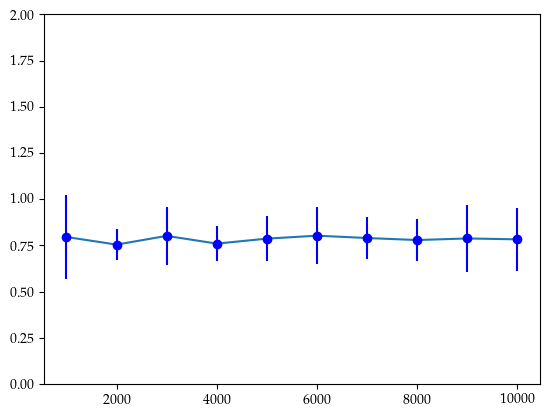

In [159]:
plt.plot(dimensions, time_ratio)
# plt.scatter(dimensions, time_ratio)
plt.errorbar(dimensions, time_ratio, yerr=time_ratio_error, fmt="bo")
plt.ylim(0,2)
plt.show()

In [2]:
def calculate_mean_cov(samples):
    """
    The input is of shape N x p, where N is the number of samples and p is the number of dimensions. 
    """
    sample_mean = np.mean(samples, axis = 0)
    sample_cov = np.cov(samples.T)
    return sample_mean, sample_cov

def calculate_summary(samples_1, samples_2, nlike, ndecimal = 3):
    
    print(f'Number of likelihood evaluations is : {nlike}')
    record = []
    for i in range(samples_1.shape[1]):
        x1 = samples_1[:,i]
        x2 = samples_2[:,i]
            
        testsamples = np.vstack(([x1, x2]))
        summary_stats = summary(testsamples)
        summary_stats[f'p_{i}'] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(ndecimal).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    record_df['scaled_n_eff'] = record_df['n_eff'] / nlike 
    return record_df
    
def compute_kl(mean0, mean1, cov0, cov1):
    cov1_inv = np.linalg.inv(cov1)
    ndim = cov1.shape[0]
    term1 = np.trace(cov1_inv @ cov0) - ndim 
    term2 = (mean1 - mean0) @ cov1_inv @ (mean1 - mean0)
    sign0, logdet0 = np.linalg.slogdet(cov0)
    sign1, logdet1 = np.linalg.slogdet(cov1)
    term3 = sign1 * logdet1 - sign0 * logdet0 
    return 0.5*(term1 + term2 + term3)

# Sample Multivariate Normal with EMCEE

In [43]:
def emcee_log_prob(position, mean, covariance):
    diff = position - mean
    return -0.5 * np.dot(diff, np.linalg.solve(covariance, diff))
    
def emcee_sampler(ndim, nsamples = 10000):
    mean = np.zeros(ndim)
    cov = np.eye(ndim)
    nwalkers = 2 * ndim 
    initial_1 = np.random.rand(nwalkers, ndim)
    initial_2 = np.random.rand(nwalkers, ndim)

    # we use two samplers (to compute the Gelman-Rubin statistics)
    sampler_1 = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob, args=[mean, cov])
    runsampler_1 = sampler_1.run_mcmc(initial_1, nsamples, progress = True)

    sampler_2 = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob, args=[mean, cov])
    runsampler_2 = sampler_2.run_mcmc(initial_2, nsamples, progress = True)

    return sampler_1, sampler_2, mean, cov

def process_emcee(sampler_1, sampler_2):
    samples_1 = sampler_1.flatchain
    samples_2 = sampler_2.flatchain 
    ndim = samples_1.shape[1]
    ap_1 = np.mean(sampler_1.acceptance_fraction)
    ap_2 = np.mean(sampler_2.acceptance_fraction)
    return samples_1, samples_2, ap_1, ap_2

In [5]:
# emcee_record_time = list()

# for d in dimensions:

#     # generate the samples 
#     start_time = time.time()
#     sampler_1, sampler_2, true_mean, true_cov = emcee_sampler(d, nsamples = NSAMPLES_EMCEE)    
#     time_taken = time.time() - start_time
#     emcee_record_time.append(time_taken)
    
#     # save the entire sampler
#     pickle_save(sampler_1, 'samples/mvn', f'sampler_emcee_mvn_1_{d}')
#     pickle_save(sampler_1, 'samples/mvn', f'sampler_emcee_mvn_2_{d}')

# NUTS

In [3]:
def nuts_model(ndim = 5):
    locs = jnp.zeros(ndim)
    covs = jnp.eye(ndim)
    mvn = dist.MultivariateNormal(loc = locs, covariance_matrix = covs)
    numpyro.sample('y', mvn)
    return locs, covs

In [45]:
%%capture
def run_nuts(dimension):
    
    nuts_kernel = NUTS(nuts_model, 
                       step_size=EPS, 
                       init_strategy=init_to_median, 
                       dense_mass=True, 
                       max_tree_depth=TREEDEPTH)

    mcmc = MCMC(nuts_kernel, 
                num_chains=2, 
                num_warmup = NWARMUP, 
                num_samples=NSAMPLES_NUTS, 
                chain_method="vectorized")
    
    mcmc.run(jax.random.PRNGKey(random.randint(0, 1000)), 
             ndim=dimension, 
             extra_fields=('potential_energy', 'num_steps'))
    return mcmc

In [46]:
# nuts_record_time = list()

# for d in dimensions:
#     start_time = time.time()
#     mcmc = run_nuts(d)
#     time_taken = time.time() - start_time 
#     nuts_record_time.append(time_taken)
    
#     # save the sampler 
#     pickle_save(mcmc, 'samples/mvn', f'sampler_nuts_mvn_{d}')   

sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 15500/15500 [04:35<00:00, 56.20it/s]


# Cobaya

In [37]:
def cobaya_mvn(ndim, number):
    
    position = {
            "prior": {"min": -5.0, "max": 5.0},
            "ref": {"dist": "norm", "loc": 0.0, "scale": 1},
            "proposal": EPS
             }
    
    likelihood = {
                    "gaussian_mixture": {
                    "means": np.zeros(ndim),
                    "covs": np.eye(ndim),
                    "derived": False}
                 }
    
    parameters = {f'p{i}': position for i in range(ndim)}
    
    pnames = [f'p{i}' for i in range(ndim)]
    
    info = {"likelihood" : likelihood}
    info["params"] = parameters
    info["sampler"] = {"mcmc": {"max_samples": NSAMPLES_COBAYA, 
                                "Rminus1_stop": 0.01, 
                                "covmat": np.eye(ndim),
                                "covmat_params": pnames
                               },
                      }
    
    path =  OUTPUT_FOLDER + f"experiment_{ndim}_{number}/"
    if os.path.exists(path) and os.path.isdir(path):
        shutil.rmtree(path)
    info["output"] = path + 'mvn'
    updated_info, sampler = run(info)
    return sampler

def stats_cobaya(ndim):
    
    nsamples = []
    nevals = []
    record_samples = []
    for number in range(2):
        path =  OUTPUT_FOLDER + f"experiment_{ndim}_{number+1}/"
        samples = np.loadtxt(path + 'mvn.1.txt')
        nsamples.append(samples.shape[0])
        nevals.append(sum(samples[:,0]))
        record_samples.append(samples[:,2:-4])
    min_nsamples = min(nsamples)
    nevals_tot = int(sum(nevals))
    print(f'Number of likelihood evaluation is :{nevals_tot}')
    return calculate_summary(record_samples[0][-min_nsamples:], record_samples[1][-min_nsamples:], nevals_tot)

def run_cobaya(ndim):
    sampler_1 = cobaya_mvn(ndim, 1)
    sampler_2 = cobaya_mvn(ndim, 2)
    return sampler_1, sampler_2

def get_cobaya_samples(sampler_1, sampler_2, ndim):
    
    data_1 = sampler_1.samples()
    data_2 = sampler_2.samples()
    
    samples_1 = data_1.data[data_1.sampled_params].values
    samples_2 = data_2.data[data_2.sampled_params].values
    
    nevals = sum(data_1.data.weight.values) + sum(data_2.data.weight.values)
    
    nsamples = [samples_1.shape[0], samples_2.shape[0]]
    min_samples = min(nsamples)
    
    return samples_1[-min_samples:], samples_2[-min_samples:], nevals

In [38]:
# testing = cobaya_mvn(100, 'testing_2')

In [39]:
# cb_record_time = list()

# for d in dimensions:
#     start_time = time.time()
#     sampler_1, sampler_2 = run_cobaya(d)
#     time_taken = time.time() - start_time 
#     cb_record_time.append(time_taken)

INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_10_1', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_10_1', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.1858219, p1:1.063612, p2:-0.7223632, p3:1.124191, p4:-1.411252, p5:-0.8088424, p6:-0.4179106, p7:0.1518385, p8:0.03686091, p9:1.457435


[mcmc] Initial point: p0:-0.1858219, p1:1.063612, p2:-0.7223632, p3:1.124191, p4:-1.411252, p5:-0.8088424, p6:-0.4179106, p7:0.1518385, p8:0.03686091, p9:1.457435


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 10400.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 10400.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:08:13 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:08:13 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 400 samples accepted.


[mcmc] Learn + convergence test @ 400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 1.907074 after 320 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.907074 after 320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.321


[mcmc]  - Acceptance rate: 0.321


INFO:mcmc: - Convergence of means: R-1 = 1.302258 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.302258 after 640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.308


[mcmc]  - Acceptance rate: 0.308


INFO:mcmc: - Convergence of means: R-1 = 0.612725 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.612725 after 960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.285841 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.285841 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2000 samples accepted.


[mcmc] Learn + convergence test @ 2000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.161312 after 1600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.161312 after 1600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.308


[mcmc]  - Acceptance rate: 0.308


INFO:mcmc: - Convergence of means: R-1 = 0.163131 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.163131 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2800 samples accepted.


[mcmc] Learn + convergence test @ 2800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.308


[mcmc]  - Acceptance rate: 0.308


INFO:mcmc: - Convergence of means: R-1 = 0.133220 after 2240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.133220 after 2240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.309


[mcmc]  - Acceptance rate: 0.309


INFO:mcmc: - Convergence of means: R-1 = 0.125742 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.125742 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.076027 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076027 after 2880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.307


[mcmc]  - Acceptance rate: 0.307


INFO:mcmc: - Convergence of means: R-1 = 0.070058 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070058 after 3200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4400 samples accepted.


[mcmc] Learn + convergence test @ 4400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.312


[mcmc]  - Acceptance rate: 0.312


INFO:mcmc: - Convergence of means: R-1 = 0.073306 after 3520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073306 after 3520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.310


[mcmc]  - Acceptance rate: 0.310


INFO:mcmc: - Convergence of means: R-1 = 0.068881 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068881 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5200 samples accepted.


[mcmc] Learn + convergence test @ 5200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.308


[mcmc]  - Acceptance rate: 0.308


INFO:mcmc: - Convergence of means: R-1 = 0.080464 after 4160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080464 after 4160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.307


[mcmc]  - Acceptance rate: 0.307


INFO:mcmc: - Convergence of means: R-1 = 0.054854 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054854 after 4480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.063153 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063153 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.057463 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057463 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6800 samples accepted.


[mcmc] Learn + convergence test @ 6800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.056774 after 5440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056774 after 5440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.050002 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050002 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7600 samples accepted.


[mcmc] Learn + convergence test @ 7600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.039776 after 6080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039776 after 6080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.036492 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036492 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.034292 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034292 after 6720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.034398 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034398 after 7040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9200 samples accepted.


[mcmc] Learn + convergence test @ 9200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.036508 after 7360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036508 after 7360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.038474 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038474 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10000 samples accepted.


[mcmc] Learn + convergence test @ 10000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.039515 after 8000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039515 after 8000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.041010 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041010 after 8320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.031216 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031216 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.024582 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024582 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11600 samples accepted.


[mcmc] Learn + convergence test @ 11600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.027826 after 9280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027826 after 9280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.025578 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025578 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12400 samples accepted.


[mcmc] Learn + convergence test @ 12400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.029198 after 9920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029198 after 9920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.033702 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033702 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.036181 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036181 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.030770 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030770 after 10880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.023774 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023774 after 11200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.029701 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029701 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14800 samples accepted.


[mcmc] Learn + convergence test @ 14800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.030874 after 11840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030874 after 11840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.030061 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030061 after 12160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.027439 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027439 after 12480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.020816 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020816 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16400 samples accepted.


[mcmc] Learn + convergence test @ 16400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023393 after 13120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023393 after 13120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017909 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017909 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17200 samples accepted.


[mcmc] Learn + convergence test @ 17200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016083 after 13760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016083 after 13760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027343 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027343 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.024478 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024478 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.015749 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015749 after 14720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18800 samples accepted.


[mcmc] Learn + convergence test @ 18800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.016411 after 15040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016411 after 15040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011295 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011295 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19600 samples accepted.


[mcmc] Learn + convergence test @ 19600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011056 after 15680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011056 after 15680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.013725 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013725 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20400 samples accepted.


[mcmc] Learn + convergence test @ 20400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012412 after 16320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012412 after 16320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.012422 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012422 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21200 samples accepted.


[mcmc] Learn + convergence test @ 21200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013483 after 16960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013483 after 16960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012919 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012919 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22000 samples accepted.


[mcmc] Learn + convergence test @ 22000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014864 after 17600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014864 after 17600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016981 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016981 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22800 samples accepted.


[mcmc] Learn + convergence test @ 22800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015310 after 18240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015310 after 18240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23200 samples accepted.


[mcmc] Learn + convergence test @ 23200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015525 after 18560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015525 after 18560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23600 samples accepted.


[mcmc] Learn + convergence test @ 23600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017954 after 18880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017954 after 18880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016812 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016812 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24400 samples accepted.


[mcmc] Learn + convergence test @ 24400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016698 after 19520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016698 after 19520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24800 samples accepted.


[mcmc] Learn + convergence test @ 24800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013446 after 19840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013446 after 19840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017688 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017688 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018768 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018768 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26000 samples accepted.


[mcmc] Learn + convergence test @ 26000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017151 after 20800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017151 after 20800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023275 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023275 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26800 samples accepted.


[mcmc] Learn + convergence test @ 26800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015602 after 21440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015602 after 21440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014239 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014239 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27600 samples accepted.


[mcmc] Learn + convergence test @ 27600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.011150 after 22080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011150 after 22080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.011455 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011455 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28400 samples accepted.


[mcmc] Learn + convergence test @ 28400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012303 after 22720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012303 after 22720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.011801 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011801 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29200 samples accepted.


[mcmc] Learn + convergence test @ 29200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.011539 after 23360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011539 after 23360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29600 samples accepted.


[mcmc] Learn + convergence test @ 29600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.008663 after 23680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008663 after 23680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.009023 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009023 after 24000 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.072241 after 30000 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.072241 after 30000 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 30000 accepted steps.


[mcmc] Sampling complete after 30000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_10_2', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_10_2', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:2.179893, p1:-0.01084135, p2:-0.02179947, p3:0.4779353, p4:2.474143, p5:-0.3876425, p6:1.926078, p7:0.8195115, p8:2.875081, p9:-2.802867


[mcmc] Initial point: p0:2.179893, p1:-0.01084135, p2:-0.02179947, p3:0.4779353, p4:2.474143, p5:-0.3876425, p6:1.926078, p7:0.8195115, p8:2.875081, p9:-2.802867


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 18800.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 18800.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:08:28 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:08:28 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 400 samples accepted.


[mcmc] Learn + convergence test @ 400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.286


[mcmc]  - Acceptance rate: 0.286


INFO:mcmc: - Convergence of means: R-1 = 0.662755 after 320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.662755 after 320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.424022 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.424022 after 640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.294


[mcmc]  - Acceptance rate: 0.294


INFO:mcmc: - Convergence of means: R-1 = 0.301511 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.301511 after 960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.223264 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.223264 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2000 samples accepted.


[mcmc] Learn + convergence test @ 2000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.307


[mcmc]  - Acceptance rate: 0.307


INFO:mcmc: - Convergence of means: R-1 = 0.190249 after 1600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.190249 after 1600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.237623 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.237623 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2800 samples accepted.


[mcmc] Learn + convergence test @ 2800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.170678 after 2240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170678 after 2240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.132076 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132076 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.293


[mcmc]  - Acceptance rate: 0.293


INFO:mcmc: - Convergence of means: R-1 = 0.078741 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078741 after 2880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.294


[mcmc]  - Acceptance rate: 0.294


INFO:mcmc: - Convergence of means: R-1 = 0.092363 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092363 after 3200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4400 samples accepted.


[mcmc] Learn + convergence test @ 4400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.079996 after 3520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079996 after 3520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.076756 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076756 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5200 samples accepted.


[mcmc] Learn + convergence test @ 5200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.076733 after 4160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076733 after 4160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.057934 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057934 after 4480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.057029 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057029 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.059087 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059087 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6800 samples accepted.


[mcmc] Learn + convergence test @ 6800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.049837 after 5440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049837 after 5440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.041760 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041760 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7600 samples accepted.


[mcmc] Learn + convergence test @ 7600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.046229 after 6080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046229 after 6080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.065195 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065195 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.045365 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045365 after 6720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.039701 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039701 after 7040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9200 samples accepted.


[mcmc] Learn + convergence test @ 9200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.053407 after 7360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053407 after 7360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.048066 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048066 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10000 samples accepted.


[mcmc] Learn + convergence test @ 10000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.048379 after 8000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048379 after 8000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.044037 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044037 after 8320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.050181 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050181 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.041579 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041579 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11600 samples accepted.


[mcmc] Learn + convergence test @ 11600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.033575 after 9280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033575 after 9280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032297 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032297 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12400 samples accepted.


[mcmc] Learn + convergence test @ 12400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030594 after 9920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030594 after 9920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026632 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026632 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022484 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022484 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028893 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028893 after 10880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.038328 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038328 after 11200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031004 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031004 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14800 samples accepted.


[mcmc] Learn + convergence test @ 14800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.028101 after 11840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028101 after 11840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.023047 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023047 after 12160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.023737 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023737 after 12480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.021633 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021633 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16400 samples accepted.


[mcmc] Learn + convergence test @ 16400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.020410 after 13120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020410 after 13120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.020161 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020161 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17200 samples accepted.


[mcmc] Learn + convergence test @ 17200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.019743 after 13760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019743 after 13760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.020968 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020968 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.025743 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025743 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.023465 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023465 after 14720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18800 samples accepted.


[mcmc] Learn + convergence test @ 18800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.021929 after 15040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021929 after 15040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.023211 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023211 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19600 samples accepted.


[mcmc] Learn + convergence test @ 19600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.021158 after 15680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021158 after 15680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017536 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017536 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20400 samples accepted.


[mcmc] Learn + convergence test @ 20400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019020 after 16320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019020 after 16320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017437 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017437 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21200 samples accepted.


[mcmc] Learn + convergence test @ 21200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019174 after 16960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019174 after 16960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020915 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020915 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22000 samples accepted.


[mcmc] Learn + convergence test @ 22000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018548 after 17600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018548 after 17600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018565 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018565 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22800 samples accepted.


[mcmc] Learn + convergence test @ 22800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016507 after 18240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016507 after 18240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23200 samples accepted.


[mcmc] Learn + convergence test @ 23200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012297 after 18560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012297 after 18560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23600 samples accepted.


[mcmc] Learn + convergence test @ 23600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012756 after 18880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012756 after 18880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014521 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014521 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24400 samples accepted.


[mcmc] Learn + convergence test @ 24400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014064 after 19520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014064 after 19520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24800 samples accepted.


[mcmc] Learn + convergence test @ 24800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013528 after 19840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013528 after 19840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016112 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016112 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014244 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014244 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26000 samples accepted.


[mcmc] Learn + convergence test @ 26000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016636 after 20800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016636 after 20800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022293 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022293 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26800 samples accepted.


[mcmc] Learn + convergence test @ 26800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.024153 after 21440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024153 after 21440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023890 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023890 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27600 samples accepted.


[mcmc] Learn + convergence test @ 27600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.023398 after 22080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023398 after 22080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.025714 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025714 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28400 samples accepted.


[mcmc] Learn + convergence test @ 28400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028441 after 22720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028441 after 22720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.025179 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025179 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29200 samples accepted.


[mcmc] Learn + convergence test @ 29200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.024470 after 23360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024470 after 23360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29600 samples accepted.


[mcmc] Learn + convergence test @ 29600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.020384 after 23680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020384 after 23680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019767 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019767 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016698 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016698 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30800 samples accepted.


[mcmc] Learn + convergence test @ 30800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016941 after 24640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016941 after 24640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016134 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016134 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31600 samples accepted.


[mcmc] Learn + convergence test @ 31600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014279 after 25280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014279 after 25280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014087 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014087 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012552 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012552 after 25920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32800 samples accepted.


[mcmc] Learn + convergence test @ 32800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011071 after 26240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011071 after 26240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33200 samples accepted.


[mcmc] Learn + convergence test @ 33200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.009121 after 26560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009121 after 26560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.009515 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009515 after 26880 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.056029 after 33600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.056029 after 33600 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 33600 accepted steps.


[mcmc] Sampling complete after 33600 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_20_1', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_20_1', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.06913692, p1:1.003275, p2:-0.1709407, p3:0.02259551, p4:-0.5778891, p5:1.323717, p6:0.7578007, p7:-0.2709035, p8:0.2163841, p9:0.8830007, p10:0.9157917, p11:-0.7518958, p12:-1.13816, p13:1.477943, p14:-0.6182185, p15:0.0519757, p16:1.176022, p17:-1.242374, p18:1.143299, p19:-0.07843132


[mcmc] Initial point: p0:-0.06913692, p1:1.003275, p2:-0.1709407, p3:0.02259551, p4:-0.5778891, p5:1.323717, p6:0.7578007, p7:-0.2709035, p8:0.2163841, p9:0.8830007, p10:0.9157917, p11:-0.7518958, p12:-1.13816, p13:1.477943, p14:-0.6182185, p15:0.0519757, p16:1.176022, p17:-1.242374, p18:1.143299, p19:-0.07843132


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 18700.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 18700.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:08:46 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:08:46 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.284


[mcmc]  - Acceptance rate: 0.284


INFO:mcmc: - Convergence of means: R-1 = 1.880688 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.880688 after 640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.319


[mcmc]  - Acceptance rate: 0.319


INFO:mcmc: - Convergence of means: R-1 = 2.998156 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.998156 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.322


[mcmc]  - Acceptance rate: 0.322


INFO:mcmc: - Convergence of means: R-1 = 0.976191 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.976191 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.319


[mcmc]  - Acceptance rate: 0.319


INFO:mcmc: - Convergence of means: R-1 = 0.432718 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.432718 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.312


[mcmc]  - Acceptance rate: 0.312


INFO:mcmc: - Convergence of means: R-1 = 0.321848 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.321848 after 3200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.332202 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.332202 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.192331 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.192331 after 4480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.210840 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.210840 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.180545 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.180545 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.119478 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119478 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.129135 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129135 after 7040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.144055 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.144055 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.127138 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.127138 after 8320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.087171 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087171 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.101317 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101317 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.104377 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104377 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.107143 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107143 after 10880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.093869 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093869 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.098138 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098138 after 12160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.088015 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088015 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.090934 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090934 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.077909 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077909 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.069802 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069802 after 14720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.071386 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071386 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.063430 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063430 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.058658 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058658 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.047708 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047708 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.059411 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059411 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23200 samples accepted.


[mcmc] Learn + convergence test @ 23200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.053328 after 18560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053328 after 18560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.051938 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051938 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24800 samples accepted.


[mcmc] Learn + convergence test @ 24800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.050231 after 19840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050231 after 19840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.053002 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053002 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.057100 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057100 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.066542 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066542 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.053576 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053576 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.042533 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042533 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29600 samples accepted.


[mcmc] Learn + convergence test @ 29600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.031754 after 23680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031754 after 23680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.037181 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037181 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.031979 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031979 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.035647 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035647 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32800 samples accepted.


[mcmc] Learn + convergence test @ 32800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.049785 after 26240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049785 after 26240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.064994 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064994 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34400 samples accepted.


[mcmc] Learn + convergence test @ 34400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.047141 after 27520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047141 after 27520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.037509 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037509 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.046435 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046435 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.042636 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042636 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37600 samples accepted.


[mcmc] Learn + convergence test @ 37600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.043339 after 30080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043339 after 30080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.041153 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041153 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.035556 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035556 after 31360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.021250 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021250 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.025165 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025165 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.022089 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022089 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42400 samples accepted.


[mcmc] Learn + convergence test @ 42400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.023401 after 33920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023401 after 33920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.025042 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025042 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.029835 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029835 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.035333 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035333 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.033439 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033439 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.024924 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024924 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47200 samples accepted.


[mcmc] Learn + convergence test @ 47200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.028046 after 37760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028046 after 37760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.025552 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025552 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48800 samples accepted.


[mcmc] Learn + convergence test @ 48800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.026048 after 39040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026048 after 39040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.028393 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028393 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.028302 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028302 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.029332 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029332 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.023779 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023779 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.023460 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023460 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53600 samples accepted.


[mcmc] Learn + convergence test @ 53600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.017832 after 42880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017832 after 42880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.023699 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023699 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.023048 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023048 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.022680 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022680 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56800 samples accepted.


[mcmc] Learn + convergence test @ 56800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.020914 after 45440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020914 after 45440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.022374 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022374 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58400 samples accepted.


[mcmc] Learn + convergence test @ 58400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.023630 after 46720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023630 after 46720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.022434 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022434 after 47360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.020514 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020514 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.020019 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020019 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.016482 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016482 after 49280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.015314 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015314 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63200 samples accepted.


[mcmc] Learn + convergence test @ 63200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.016220 after 50560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016220 after 50560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.016851 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016851 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.018655 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018655 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.019002 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019002 after 52480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66400 samples accepted.


[mcmc] Learn + convergence test @ 66400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.021130 after 53120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021130 after 53120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.023531 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023531 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.021113 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021113 after 54400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.019791 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019791 after 55040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.017955 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017955 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.017193 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017193 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71200 samples accepted.


[mcmc] Learn + convergence test @ 71200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.017639 after 56960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017639 after 56960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.017421 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017421 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.017872 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017872 after 58240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.018977 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018977 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.019747 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019747 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.019536 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019536 after 60160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.017280 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017280 after 60800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.017211 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017211 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 77600 samples accepted.


[mcmc] Learn + convergence test @ 77600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.018302 after 62080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018302 after 62080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.015194 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015194 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.016855 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016855 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.014886 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014886 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80800 samples accepted.


[mcmc] Learn + convergence test @ 80800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.013858 after 64640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013858 after 64640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.017067 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017067 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82400 samples accepted.


[mcmc] Learn + convergence test @ 82400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.016838 after 65920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016838 after 65920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.015601 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015601 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.013873 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013873 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.016065 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016065 after 67840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85600 samples accepted.


[mcmc] Learn + convergence test @ 85600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.015024 after 68480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015024 after 68480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.014882 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014882 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87200 samples accepted.


[mcmc] Learn + convergence test @ 87200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.013384 after 69760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013384 after 69760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.012822 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012822 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.013347 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013347 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.014635 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014635 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90400 samples accepted.


[mcmc] Learn + convergence test @ 90400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.017224 after 72320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017224 after 72320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.014867 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014867 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.013035 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013035 after 73600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.010883 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010883 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.009883 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009883 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.009617 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009617 after 75520 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.064807 after 94400 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.064807 after 94400 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 94400 accepted steps.


[mcmc] Sampling complete after 94400 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_20_2', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_20_2', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.134048, p1:-0.6032604, p2:0.5792547, p3:-1.176992, p4:-0.4533052, p5:2.606849, p6:-1.055782, p7:0.8477507, p8:-1.378992, p9:-1.682716, p10:-0.001030223, p11:-0.9370919, p12:0.9827555, p13:0.102929, p14:0.2883414, p15:2.415817, p16:-0.299567, p17:1.98382, p18:0.5884787, p19:0.007467973


[mcmc] Initial point: p0:1.134048, p1:-0.6032604, p2:0.5792547, p3:-1.176992, p4:-0.4533052, p5:2.606849, p6:-1.055782, p7:0.8477507, p8:-1.378992, p9:-1.682716, p10:-0.001030223, p11:-0.9370919, p12:0.9827555, p13:0.102929, p14:0.2883414, p15:2.415817, p16:-0.299567, p17:1.98382, p18:0.5884787, p19:0.007467973


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 19000.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 19000.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:09:37 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:09:37 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.292


[mcmc]  - Acceptance rate: 0.292


INFO:mcmc: - Convergence of means: R-1 = 3.251598 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.251598 after 640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.293


[mcmc]  - Acceptance rate: 0.293


INFO:mcmc: - Convergence of means: R-1 = 1.176001 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.176001 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.391187 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.391187 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.335444 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.335444 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.844251 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.844251 after 3200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.307


[mcmc]  - Acceptance rate: 0.307


INFO:mcmc: - Convergence of means: R-1 = 0.537446 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.537446 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.287224 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.287224 after 4480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.308


[mcmc]  - Acceptance rate: 0.308


INFO:mcmc: - Convergence of means: R-1 = 0.295767 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.295767 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.273117 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.273117 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.203489 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.203489 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8800 samples accepted.


[mcmc] Learn + convergence test @ 8800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.307


[mcmc]  - Acceptance rate: 0.307


INFO:mcmc: - Convergence of means: R-1 = 0.143412 after 7040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143412 after 7040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.307


[mcmc]  - Acceptance rate: 0.307


INFO:mcmc: - Convergence of means: R-1 = 0.149560 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149560 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10400 samples accepted.


[mcmc] Learn + convergence test @ 10400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.150104 after 8320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150104 after 8320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.136069 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136069 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.121149 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121149 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.093697 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093697 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13600 samples accepted.


[mcmc] Learn + convergence test @ 13600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.101835 after 10880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101835 after 10880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.088448 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088448 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15200 samples accepted.


[mcmc] Learn + convergence test @ 15200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.081737 after 12160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081737 after 12160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.077157 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077157 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.069595 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069595 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.072526 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072526 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18400 samples accepted.


[mcmc] Learn + convergence test @ 18400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.072399 after 14720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072399 after 14720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.102546 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102546 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.094114 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094114 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.079745 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079745 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.069584 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069584 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.067319 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067319 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 23200 samples accepted.


[mcmc] Learn + convergence test @ 23200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.052833 after 18560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052833 after 18560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.056707 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056707 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24800 samples accepted.


[mcmc] Learn + convergence test @ 24800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.068809 after 19840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068809 after 19840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.084788 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084788 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.068156 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068156 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.069465 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069465 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.058492 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058492 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.045866 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045866 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 29600 samples accepted.


[mcmc] Learn + convergence test @ 29600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.038050 after 23680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038050 after 23680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.043394 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043394 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.045013 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045013 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.034292 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034292 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32800 samples accepted.


[mcmc] Learn + convergence test @ 32800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.036004 after 26240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036004 after 26240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.040589 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040589 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34400 samples accepted.


[mcmc] Learn + convergence test @ 34400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.040596 after 27520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040596 after 27520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.042583 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042583 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.044090 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044090 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.043954 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043954 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37600 samples accepted.


[mcmc] Learn + convergence test @ 37600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.048059 after 30080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048059 after 30080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.050398 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050398 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.050045 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050045 after 31360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.038665 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038665 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.044358 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044358 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.036041 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036041 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42400 samples accepted.


[mcmc] Learn + convergence test @ 42400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.030357 after 33920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030357 after 33920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.029372 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029372 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.029332 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029332 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.026795 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026795 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.023629 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023629 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.024358 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024358 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47200 samples accepted.


[mcmc] Learn + convergence test @ 47200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.022903 after 37760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022903 after 37760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.023847 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023847 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48800 samples accepted.


[mcmc] Learn + convergence test @ 48800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.019055 after 39040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019055 after 39040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020860 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020860 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017591 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017591 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018220 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018220 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.018929 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018929 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019899 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019899 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53600 samples accepted.


[mcmc] Learn + convergence test @ 53600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018666 after 42880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018666 after 42880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.014570 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014570 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015121 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015121 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014720 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014720 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56800 samples accepted.


[mcmc] Learn + convergence test @ 56800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017513 after 45440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017513 after 45440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015117 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015117 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58400 samples accepted.


[mcmc] Learn + convergence test @ 58400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016440 after 46720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016440 after 46720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016962 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016962 after 47360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.018387 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018387 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.020716 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020716 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.018476 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018476 after 49280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.016972 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016972 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63200 samples accepted.


[mcmc] Learn + convergence test @ 63200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.016292 after 50560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016292 after 50560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016840 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016840 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017440 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017440 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016146 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016146 after 52480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66400 samples accepted.


[mcmc] Learn + convergence test @ 66400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016184 after 53120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016184 after 53120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013386 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013386 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011501 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011501 after 54400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012908 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012908 after 55040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012991 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012991 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015365 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015365 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 71200 samples accepted.


[mcmc] Learn + convergence test @ 71200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014118 after 56960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014118 after 56960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016258 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016258 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014367 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014367 after 58240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017629 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017629 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016172 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016172 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016488 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016488 after 60160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016799 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016799 after 60800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019021 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019021 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 77600 samples accepted.


[mcmc] Learn + convergence test @ 77600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019856 after 62080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019856 after 62080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019806 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019806 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020269 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020269 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020862 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020862 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80800 samples accepted.


[mcmc] Learn + convergence test @ 80800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018059 after 64640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018059 after 64640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015328 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015328 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82400 samples accepted.


[mcmc] Learn + convergence test @ 82400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018236 after 65920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018236 after 65920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018263 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018263 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016381 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016381 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016505 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016505 after 67840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85600 samples accepted.


[mcmc] Learn + convergence test @ 85600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014112 after 68480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014112 after 68480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016314 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016314 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87200 samples accepted.


[mcmc] Learn + convergence test @ 87200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016303 after 69760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016303 after 69760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017788 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017788 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014183 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014183 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013120 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013120 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90400 samples accepted.


[mcmc] Learn + convergence test @ 90400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014676 after 72320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014676 after 72320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014906 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014906 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012640 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012640 after 73600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011246 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011246 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012152 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012152 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011483 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011483 after 75520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012424 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012424 after 76160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011060 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011060 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96800 samples accepted.


[mcmc] Learn + convergence test @ 96800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.009954 after 77440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009954 after 77440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010438 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010438 after 78080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010764 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010764 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010105 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010105 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.009980 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009980 after 80000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010617 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010617 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 101600 samples accepted.


[mcmc] Learn + convergence test @ 101600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011395 after 81280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011395 after 81280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013136 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013136 after 81920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014890 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014890 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014401 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014401 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104800 samples accepted.


[mcmc] Learn + convergence test @ 104800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014976 after 83840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014976 after 83840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014969 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014969 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 106400 samples accepted.


[mcmc] Learn + convergence test @ 106400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013794 after 85120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013794 after 85120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 107200 samples accepted.


[mcmc] Learn + convergence test @ 107200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013290 after 85760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013290 after 85760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014290 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014290 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012594 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012594 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 109600 samples accepted.


[mcmc] Learn + convergence test @ 109600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011101 after 87680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011101 after 87680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012935 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012935 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 111200 samples accepted.


[mcmc] Learn + convergence test @ 111200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012194 after 88960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012194 after 88960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.010618 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010618 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:10:37 : 375283 steps taken, and 112001 accepted.


[mcmc] Progress @ 2024-05-02 17:10:37 : 375283 steps taken, and 112001 accepted.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.009566 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009566 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 113600 samples accepted.


[mcmc] Learn + convergence test @ 113600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.008786 after 90880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008786 after 90880 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.053128 after 113600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.053128 after 113600 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 113600 accepted steps.


[mcmc] Sampling complete after 113600 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_30_1', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_30_1', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-2.12337, p1:-1.503951, p2:0.02644275, p3:1.609324, p4:-0.9039002, p5:0.4763365, p6:-0.940812, p7:-0.006229082, p8:-0.4260997, p9:-0.4756884, p10:-1.294609, p11:-0.9905079, p12:0.03561633, p13:-1.145254, p14:-1.837015, p15:-1.721608, p16:-1.574414, p17:1.373169, p18:-1.610818, p19:-0.1349739, p20:-0.4214639, p21:0.3791634, p22:0.1003475, p23:-1.421755, p24:0.925698, p25:0.7609069, p26:-0.2225509, p27:-1.484732, p28:-0.7225124, p29:0.9536821


[mcmc] Initial point: p0:-2.12337, p1:-1.503951, p2:0.02644275, p3:1.609324, p4:-0.9039002, p5:0.4763365, p6:-0.940812, p7:-0.006229082, p8:-0.4260997, p9:-0.4756884, p10:-1.294609, p11:-0.9905079, p12:0.03561633, p13:-1.145254, p14:-1.837015, p15:-1.721608, p16:-1.574414, p17:1.373169, p18:-1.610818, p19:-0.1349739, p20:-0.4214639, p21:0.3791634, p22:0.1003475, p23:-1.421755, p24:0.925698, p25:0.7609069, p26:-0.2225509, p27:-1.484732, p28:-0.7225124, p29:0.9536821


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 16300.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 16300.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:10:40 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:10:40 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 3.762483 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.762483 after 960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.294


[mcmc]  - Acceptance rate: 0.294


INFO:mcmc: - Convergence of means: R-1 = 1.536228 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.536228 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 1.291533 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.291533 after 2880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 1.205217 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.205217 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.307


[mcmc]  - Acceptance rate: 0.307


INFO:mcmc: - Convergence of means: R-1 = 0.527168 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.527168 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.443267 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.443267 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.486801 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.486801 after 6720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.525426 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.525426 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.374841 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.374841 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.476011 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.476011 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.309249 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.309249 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.230711 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.230711 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.288219 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.288219 after 12480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.213540 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213540 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.181006 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.181006 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.163227 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.163227 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20400 samples accepted.


[mcmc] Learn + convergence test @ 20400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.156632 after 16320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156632 after 16320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.145467 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145467 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22800 samples accepted.


[mcmc] Learn + convergence test @ 22800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.131302 after 18240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.131302 after 18240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.173576 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173576 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.178788 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.178788 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.139560 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.139560 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27600 samples accepted.


[mcmc] Learn + convergence test @ 27600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.123067 after 22080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123067 after 22080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.119252 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119252 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.102945 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102945 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.102531 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102531 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.099321 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099321 after 25920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.088015 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088015 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34800 samples accepted.


[mcmc] Learn + convergence test @ 34800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.061751 after 27840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061751 after 27840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.048092 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048092 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37200 samples accepted.


[mcmc] Learn + convergence test @ 37200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.061685 after 29760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061685 after 29760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.069418 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069418 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39600 samples accepted.


[mcmc] Learn + convergence test @ 39600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.072309 after 31680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072309 after 31680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.059462 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059462 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.053773 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053773 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.051947 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051947 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44400 samples accepted.


[mcmc] Learn + convergence test @ 44400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.053931 after 35520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053931 after 35520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.042213 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042213 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46800 samples accepted.


[mcmc] Learn + convergence test @ 46800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.049787 after 37440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049787 after 37440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.051692 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051692 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49200 samples accepted.


[mcmc] Learn + convergence test @ 49200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.052040 after 39360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052040 after 39360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.051722 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051722 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51600 samples accepted.


[mcmc] Learn + convergence test @ 51600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.047989 after 41280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047989 after 41280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.051141 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051141 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.043766 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043766 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.052944 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052944 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56400 samples accepted.


[mcmc] Learn + convergence test @ 56400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.048713 after 45120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048713 after 45120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.041097 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041097 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58800 samples accepted.


[mcmc] Learn + convergence test @ 58800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.032915 after 47040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032915 after 47040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.031621 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031621 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61200 samples accepted.


[mcmc] Learn + convergence test @ 61200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.026189 after 48960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026189 after 48960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.032714 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032714 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63600 samples accepted.


[mcmc] Learn + convergence test @ 63600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.035321 after 50880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035321 after 50880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.036429 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036429 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66000 samples accepted.


[mcmc] Learn + convergence test @ 66000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.036498 after 52800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036498 after 52800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.036108 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036108 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68400 samples accepted.


[mcmc] Learn + convergence test @ 68400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.035015 after 54720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035015 after 54720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.035485 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035485 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70800 samples accepted.


[mcmc] Learn + convergence test @ 70800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.039238 after 56640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039238 after 56640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.032789 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032789 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73200 samples accepted.


[mcmc] Learn + convergence test @ 73200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.034874 after 58560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034874 after 58560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.034053 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034053 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.033809 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033809 after 60480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.031098 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031098 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78000 samples accepted.


[mcmc] Learn + convergence test @ 78000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.029865 after 62400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029865 after 62400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.027407 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027407 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80400 samples accepted.


[mcmc] Learn + convergence test @ 80400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.029407 after 64320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029407 after 64320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.027694 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027694 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82800 samples accepted.


[mcmc] Learn + convergence test @ 82800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.025224 after 66240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025224 after 66240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.024227 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024227 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85200 samples accepted.


[mcmc] Learn + convergence test @ 85200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.022230 after 68160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022230 after 68160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.022642 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022642 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87600 samples accepted.


[mcmc] Learn + convergence test @ 87600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.022213 after 70080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022213 after 70080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.023699 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023699 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.019494 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019494 after 72000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.019247 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019247 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92400 samples accepted.


[mcmc] Learn + convergence test @ 92400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.017720 after 73920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017720 after 73920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.020403 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020403 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94800 samples accepted.


[mcmc] Learn + convergence test @ 94800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.020934 after 75840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020934 after 75840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.019561 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019561 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97200 samples accepted.


[mcmc] Learn + convergence test @ 97200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.018680 after 77760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018680 after 77760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.020852 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020852 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99600 samples accepted.


[mcmc] Learn + convergence test @ 99600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.018974 after 79680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018974 after 79680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.020901 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020901 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102000 samples accepted.


[mcmc] Learn + convergence test @ 102000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.021021 after 81600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021021 after 81600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.021207 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021207 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104400 samples accepted.


[mcmc] Learn + convergence test @ 104400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.023055 after 83520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023055 after 83520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020147 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020147 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 106800 samples accepted.


[mcmc] Learn + convergence test @ 106800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021169 after 85440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021169 after 85440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022357 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022357 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 109200 samples accepted.


[mcmc] Learn + convergence test @ 109200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020061 after 87360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020061 after 87360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019758 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019758 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:11:40 : 372642 steps taken, and 111030 accepted.


[mcmc] Progress @ 2024-05-02 17:11:40 : 372642 steps taken, and 111030 accepted.


INFO:mcmc:Learn + convergence test @ 111600 samples accepted.


[mcmc] Learn + convergence test @ 111600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016740 after 89280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016740 after 89280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014918 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014918 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 114000 samples accepted.


[mcmc] Learn + convergence test @ 114000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014332 after 91200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014332 after 91200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016483 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016483 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116400 samples accepted.


[mcmc] Learn + convergence test @ 116400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016796 after 93120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016796 after 93120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016421 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016421 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118800 samples accepted.


[mcmc] Learn + convergence test @ 118800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016946 after 95040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016946 after 95040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014191 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014191 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 121200 samples accepted.


[mcmc] Learn + convergence test @ 121200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014610 after 96960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014610 after 96960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015568 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015568 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123600 samples accepted.


[mcmc] Learn + convergence test @ 123600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014975 after 98880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014975 after 98880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015387 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015387 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016460 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016460 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 127200 samples accepted.


[mcmc] Learn + convergence test @ 127200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016329 after 101760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016329 after 101760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128400 samples accepted.


[mcmc] Learn + convergence test @ 128400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013878 after 102720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013878 after 102720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011847 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011847 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 130800 samples accepted.


[mcmc] Learn + convergence test @ 130800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011241 after 104640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011241 after 104640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012886 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012886 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 133200 samples accepted.


[mcmc] Learn + convergence test @ 133200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015689 after 106560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015689 after 106560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017277 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017277 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 135600 samples accepted.


[mcmc] Learn + convergence test @ 135600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016358 after 108480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016358 after 108480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013651 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013651 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 138000 samples accepted.


[mcmc] Learn + convergence test @ 138000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013455 after 110400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013455 after 110400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011673 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011673 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140400 samples accepted.


[mcmc] Learn + convergence test @ 140400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011491 after 112320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011491 after 112320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 141600 samples accepted.


[mcmc] Learn + convergence test @ 141600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010338 after 113280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010338 after 113280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142800 samples accepted.


[mcmc] Learn + convergence test @ 142800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010203 after 114240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010203 after 114240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010184 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010184 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 145200 samples accepted.


[mcmc] Learn + convergence test @ 145200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011378 after 116160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011378 after 116160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 146400 samples accepted.


[mcmc] Learn + convergence test @ 146400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011043 after 117120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011043 after 117120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147600 samples accepted.


[mcmc] Learn + convergence test @ 147600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.011854 after 118080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011854 after 118080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.010802 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010802 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150000 samples accepted.


[mcmc] Learn + convergence test @ 150000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011618 after 120000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011618 after 120000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.010872 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010872 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152400 samples accepted.


[mcmc] Learn + convergence test @ 152400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013712 after 121920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013712 after 121920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013601 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013601 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154800 samples accepted.


[mcmc] Learn + convergence test @ 154800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012965 after 123840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012965 after 123840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013392 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013392 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 157200 samples accepted.


[mcmc] Learn + convergence test @ 157200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012018 after 125760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012018 after 125760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.011685 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011685 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 159600 samples accepted.


[mcmc] Learn + convergence test @ 159600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011017 after 127680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011017 after 127680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160800 samples accepted.


[mcmc] Learn + convergence test @ 160800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012055 after 128640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012055 after 128640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.011527 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011527 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.010686 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010686 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164400 samples accepted.


[mcmc] Learn + convergence test @ 164400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012371 after 131520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012371 after 131520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.011848 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011848 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166800 samples accepted.


[mcmc] Learn + convergence test @ 166800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012342 after 133440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012342 after 133440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.010976 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010976 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169200 samples accepted.


[mcmc] Learn + convergence test @ 169200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012379 after 135360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012379 after 135360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170400 samples accepted.


[mcmc] Learn + convergence test @ 170400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012284 after 136320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012284 after 136320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 171600 samples accepted.


[mcmc] Learn + convergence test @ 171600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011839 after 137280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011839 after 137280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011011 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011011 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174000 samples accepted.


[mcmc] Learn + convergence test @ 174000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010572 after 139200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010572 after 139200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 175200 samples accepted.


[mcmc] Learn + convergence test @ 175200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011766 after 140160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011766 after 140160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012376 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012376 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012088 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012088 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 178800 samples accepted.


[mcmc] Learn + convergence test @ 178800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011725 after 143040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011725 after 143040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012220 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012220 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 181200 samples accepted.


[mcmc] Learn + convergence test @ 181200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011604 after 144960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011604 after 144960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012321 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012321 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 183600 samples accepted.


[mcmc] Learn + convergence test @ 183600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012237 after 146880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012237 after 146880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012189 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012189 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 186000 samples accepted.


[mcmc] Learn + convergence test @ 186000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011128 after 148800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011128 after 148800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010718 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010718 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188400 samples accepted.


[mcmc] Learn + convergence test @ 188400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010367 after 150720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010367 after 150720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 189600 samples accepted.


[mcmc] Learn + convergence test @ 189600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010688 after 151680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010688 after 151680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 190800 samples accepted.


[mcmc] Learn + convergence test @ 190800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012094 after 152640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012094 after 152640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010089 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010089 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193200 samples accepted.


[mcmc] Learn + convergence test @ 193200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.009437 after 154560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009437 after 154560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.009271 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009271 after 155520 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.050745 after 194400 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.050745 after 194400 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 194400 accepted steps.


[mcmc] Sampling complete after 194400 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_30_2', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_30_2', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.139267, p1:0.5791181, p2:-0.944311, p3:-0.2822991, p4:0.1912402, p5:-0.228349, p6:-0.05687158, p7:-1.272143, p8:-0.1693378, p9:-0.5253139, p10:-0.05515612, p11:0.9214635, p12:-0.08241889, p13:0.7808115, p14:0.5813567, p15:-0.1850111, p16:-0.481843, p17:-1.001213, p18:0.01236754, p19:0.3459547, p20:0.130624, p21:0.4286239, p22:0.867244, p23:0.003945634, p24:-0.9643679, p25:-0.2709608, p26:-0.05302577, p27:-0.8317711, p28:2.06407, p29:0.7715502


[mcmc] Initial point: p0:1.139267, p1:0.5791181, p2:-0.944311, p3:-0.2822991, p4:0.1912402, p5:-0.228349, p6:-0.05687158, p7:-1.272143, p8:-0.1693378, p9:-0.5253139, p10:-0.05515612, p11:0.9214635, p12:-0.08241889, p13:0.7808115, p14:0.5813567, p15:-0.1850111, p16:-0.481843, p17:-1.001213, p18:0.01236754, p19:0.3459547, p20:0.130624, p21:0.4286239, p22:0.867244, p23:0.003945634, p24:-0.9643679, p25:-0.2709608, p26:-0.05302577, p27:-0.8317711, p28:2.06407, p29:0.7715502


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 14100.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 14100.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:12:36 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:12:36 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1200 samples accepted.


[mcmc] Learn + convergence test @ 1200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 3.004123 after 960 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.004123 after 960 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 2.286064 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.286064 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.293


[mcmc]  - Acceptance rate: 0.293


INFO:mcmc: - Convergence of means: R-1 = 1.109062 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.109062 after 2880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.290


[mcmc]  - Acceptance rate: 0.290


INFO:mcmc: - Convergence of means: R-1 = 0.839937 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.839937 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.290


[mcmc]  - Acceptance rate: 0.290


INFO:mcmc: - Convergence of means: R-1 = 0.685478 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.685478 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.292


[mcmc]  - Acceptance rate: 0.292


INFO:mcmc: - Convergence of means: R-1 = 0.566738 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.566738 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.294


[mcmc]  - Acceptance rate: 0.294


INFO:mcmc: - Convergence of means: R-1 = 0.535926 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.535926 after 6720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.417432 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.417432 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.393743 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.393743 after 8640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.343305 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.343305 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 13200 samples accepted.


[mcmc] Learn + convergence test @ 13200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.243732 after 10560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.243732 after 10560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.269697 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.269697 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 15600 samples accepted.


[mcmc] Learn + convergence test @ 15600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.230548 after 12480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.230548 after 12480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.241784 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.241784 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.235080 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.235080 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.189037 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.189037 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20400 samples accepted.


[mcmc] Learn + convergence test @ 20400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.168611 after 16320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.168611 after 16320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.158431 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158431 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22800 samples accepted.


[mcmc] Learn + convergence test @ 22800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.138206 after 18240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138206 after 18240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.136135 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136135 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.134627 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134627 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.137895 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.137895 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27600 samples accepted.


[mcmc] Learn + convergence test @ 27600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.127017 after 22080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.127017 after 22080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.118093 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118093 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.092460 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092460 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.091576 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091576 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.116076 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116076 after 25920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.120456 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120456 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34800 samples accepted.


[mcmc] Learn + convergence test @ 34800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.100432 after 27840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100432 after 27840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.095654 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095654 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 37200 samples accepted.


[mcmc] Learn + convergence test @ 37200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.076116 after 29760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076116 after 29760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.070277 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070277 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39600 samples accepted.


[mcmc] Learn + convergence test @ 39600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.073689 after 31680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073689 after 31680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.078297 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078297 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.068470 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068470 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.088124 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088124 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44400 samples accepted.


[mcmc] Learn + convergence test @ 44400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.098123 after 35520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098123 after 35520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.089839 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089839 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46800 samples accepted.


[mcmc] Learn + convergence test @ 46800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.084169 after 37440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084169 after 37440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.093141 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093141 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49200 samples accepted.


[mcmc] Learn + convergence test @ 49200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.081040 after 39360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081040 after 39360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.075046 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075046 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51600 samples accepted.


[mcmc] Learn + convergence test @ 51600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.067655 after 41280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067655 after 41280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.056867 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056867 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.052446 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052446 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.054323 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054323 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56400 samples accepted.


[mcmc] Learn + convergence test @ 56400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.052364 after 45120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052364 after 45120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.049095 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049095 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58800 samples accepted.


[mcmc] Learn + convergence test @ 58800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.041208 after 47040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041208 after 47040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.047998 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047998 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61200 samples accepted.


[mcmc] Learn + convergence test @ 61200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.057949 after 48960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057949 after 48960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.049370 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049370 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 63600 samples accepted.


[mcmc] Learn + convergence test @ 63600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.046397 after 50880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046397 after 50880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.046060 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046060 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66000 samples accepted.


[mcmc] Learn + convergence test @ 66000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.040902 after 52800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040902 after 52800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.046226 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046226 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68400 samples accepted.


[mcmc] Learn + convergence test @ 68400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.042715 after 54720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042715 after 54720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.038592 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038592 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70800 samples accepted.


[mcmc] Learn + convergence test @ 70800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.041599 after 56640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041599 after 56640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.044719 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044719 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73200 samples accepted.


[mcmc] Learn + convergence test @ 73200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.045137 after 58560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045137 after 58560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.047460 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047460 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.043653 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043653 after 60480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.042494 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042494 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78000 samples accepted.


[mcmc] Learn + convergence test @ 78000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.041709 after 62400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041709 after 62400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.042121 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042121 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80400 samples accepted.


[mcmc] Learn + convergence test @ 80400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.039401 after 64320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039401 after 64320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.041914 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041914 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82800 samples accepted.


[mcmc] Learn + convergence test @ 82800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.040642 after 66240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040642 after 66240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.044898 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044898 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 85200 samples accepted.


[mcmc] Learn + convergence test @ 85200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.047199 after 68160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047199 after 68160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.041910 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041910 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 87600 samples accepted.


[mcmc] Learn + convergence test @ 87600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.037788 after 70080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037788 after 70080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.037219 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037219 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.035287 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035287 after 72000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.033104 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033104 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92400 samples accepted.


[mcmc] Learn + convergence test @ 92400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.028378 after 73920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028378 after 73920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027982 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027982 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94800 samples accepted.


[mcmc] Learn + convergence test @ 94800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.030000 after 75840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030000 after 75840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.025984 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025984 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97200 samples accepted.


[mcmc] Learn + convergence test @ 97200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.027845 after 77760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027845 after 77760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.026953 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026953 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99600 samples accepted.


[mcmc] Learn + convergence test @ 99600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026584 after 79680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026584 after 79680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.024647 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024647 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102000 samples accepted.


[mcmc] Learn + convergence test @ 102000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023386 after 81600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023386 after 81600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021684 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021684 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104400 samples accepted.


[mcmc] Learn + convergence test @ 104400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017712 after 83520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017712 after 83520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015897 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015897 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 106800 samples accepted.


[mcmc] Learn + convergence test @ 106800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017225 after 85440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017225 after 85440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015319 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015319 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 109200 samples accepted.


[mcmc] Learn + convergence test @ 109200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013548 after 87360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013548 after 87360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012549 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012549 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:13:36 : 371091 steps taken, and 110400 accepted.


[mcmc] Progress @ 2024-05-02 17:13:36 : 371091 steps taken, and 110400 accepted.


INFO:mcmc:Learn + convergence test @ 111600 samples accepted.


[mcmc] Learn + convergence test @ 111600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014191 after 89280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014191 after 89280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016568 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016568 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 114000 samples accepted.


[mcmc] Learn + convergence test @ 114000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015638 after 91200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015638 after 91200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018135 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018135 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116400 samples accepted.


[mcmc] Learn + convergence test @ 116400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013824 after 93120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013824 after 93120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013260 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013260 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118800 samples accepted.


[mcmc] Learn + convergence test @ 118800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013939 after 95040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013939 after 95040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014116 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014116 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 121200 samples accepted.


[mcmc] Learn + convergence test @ 121200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015042 after 96960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015042 after 96960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016172 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016172 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123600 samples accepted.


[mcmc] Learn + convergence test @ 123600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018408 after 98880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018408 after 98880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019453 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019453 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019919 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019919 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 127200 samples accepted.


[mcmc] Learn + convergence test @ 127200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018897 after 101760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018897 after 101760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128400 samples accepted.


[mcmc] Learn + convergence test @ 128400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019328 after 102720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019328 after 102720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018058 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018058 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 130800 samples accepted.


[mcmc] Learn + convergence test @ 130800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017597 after 104640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017597 after 104640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015645 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015645 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 133200 samples accepted.


[mcmc] Learn + convergence test @ 133200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016350 after 106560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016350 after 106560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016867 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016867 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 135600 samples accepted.


[mcmc] Learn + convergence test @ 135600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016527 after 108480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016527 after 108480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.018537 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018537 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 138000 samples accepted.


[mcmc] Learn + convergence test @ 138000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019161 after 110400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019161 after 110400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019583 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019583 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140400 samples accepted.


[mcmc] Learn + convergence test @ 140400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019482 after 112320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019482 after 112320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 141600 samples accepted.


[mcmc] Learn + convergence test @ 141600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019127 after 113280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019127 after 113280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142800 samples accepted.


[mcmc] Learn + convergence test @ 142800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017172 after 114240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017172 after 114240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016170 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016170 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 145200 samples accepted.


[mcmc] Learn + convergence test @ 145200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016171 after 116160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016171 after 116160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 146400 samples accepted.


[mcmc] Learn + convergence test @ 146400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015475 after 117120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015475 after 117120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147600 samples accepted.


[mcmc] Learn + convergence test @ 147600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016616 after 118080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016616 after 118080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016742 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016742 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150000 samples accepted.


[mcmc] Learn + convergence test @ 150000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016389 after 120000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016389 after 120000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015097 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015097 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152400 samples accepted.


[mcmc] Learn + convergence test @ 152400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014950 after 121920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014950 after 121920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013739 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013739 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154800 samples accepted.


[mcmc] Learn + convergence test @ 154800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014438 after 123840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014438 after 123840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013418 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013418 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 157200 samples accepted.


[mcmc] Learn + convergence test @ 157200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014086 after 125760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014086 after 125760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014858 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014858 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 159600 samples accepted.


[mcmc] Learn + convergence test @ 159600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014592 after 127680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014592 after 127680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160800 samples accepted.


[mcmc] Learn + convergence test @ 160800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014295 after 128640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014295 after 128640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016808 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016808 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015992 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015992 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164400 samples accepted.


[mcmc] Learn + convergence test @ 164400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016003 after 131520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016003 after 131520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014187 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014187 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166800 samples accepted.


[mcmc] Learn + convergence test @ 166800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013984 after 133440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013984 after 133440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013684 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013684 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169200 samples accepted.


[mcmc] Learn + convergence test @ 169200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012810 after 135360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012810 after 135360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170400 samples accepted.


[mcmc] Learn + convergence test @ 170400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013364 after 136320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013364 after 136320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 171600 samples accepted.


[mcmc] Learn + convergence test @ 171600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014032 after 137280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014032 after 137280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013093 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013093 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174000 samples accepted.


[mcmc] Learn + convergence test @ 174000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012988 after 139200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012988 after 139200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 175200 samples accepted.


[mcmc] Learn + convergence test @ 175200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012872 after 140160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012872 after 140160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012836 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012836 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011610 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011610 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 178800 samples accepted.


[mcmc] Learn + convergence test @ 178800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011325 after 143040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011325 after 143040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010782 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010782 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 181200 samples accepted.


[mcmc] Learn + convergence test @ 181200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010604 after 144960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010604 after 144960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011304 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011304 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 183600 samples accepted.


[mcmc] Learn + convergence test @ 183600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011832 after 146880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011832 after 146880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012693 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012693 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 186000 samples accepted.


[mcmc] Learn + convergence test @ 186000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012668 after 148800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012668 after 148800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012879 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012879 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188400 samples accepted.


[mcmc] Learn + convergence test @ 188400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012174 after 150720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012174 after 150720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 189600 samples accepted.


[mcmc] Learn + convergence test @ 189600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012310 after 151680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012310 after 151680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 190800 samples accepted.


[mcmc] Learn + convergence test @ 190800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010996 after 152640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010996 after 152640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012698 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012698 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193200 samples accepted.


[mcmc] Learn + convergence test @ 193200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013122 after 154560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013122 after 154560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013547 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013547 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 195600 samples accepted.


[mcmc] Learn + convergence test @ 195600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012157 after 156480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012157 after 156480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011921 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011921 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013385 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013385 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 199200 samples accepted.


[mcmc] Learn + convergence test @ 199200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014428 after 159360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014428 after 159360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200400 samples accepted.


[mcmc] Learn + convergence test @ 200400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013302 after 160320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013302 after 160320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013008 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013008 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:14:36 : 678503 steps taken, and 201887 accepted.


[mcmc] Progress @ 2024-05-02 17:14:36 : 678503 steps taken, and 201887 accepted.


INFO:mcmc:Learn + convergence test @ 202800 samples accepted.


[mcmc] Learn + convergence test @ 202800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013806 after 162240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013806 after 162240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012350 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012350 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 205200 samples accepted.


[mcmc] Learn + convergence test @ 205200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012455 after 164160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012455 after 164160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012697 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012697 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 207600 samples accepted.


[mcmc] Learn + convergence test @ 207600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012887 after 166080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012887 after 166080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013078 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013078 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013570 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013570 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013419 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013419 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212400 samples accepted.


[mcmc] Learn + convergence test @ 212400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012125 after 169920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012125 after 169920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 213600 samples accepted.


[mcmc] Learn + convergence test @ 213600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012348 after 170880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012348 after 170880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214800 samples accepted.


[mcmc] Learn + convergence test @ 214800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013145 after 171840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013145 after 171840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012937 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012937 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 217200 samples accepted.


[mcmc] Learn + convergence test @ 217200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012290 after 173760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012290 after 173760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011496 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011496 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 219600 samples accepted.


[mcmc] Learn + convergence test @ 219600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010546 after 175680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010546 after 175680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011179 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011179 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 222000 samples accepted.


[mcmc] Learn + convergence test @ 222000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010503 after 177600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010503 after 177600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010037 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010037 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224400 samples accepted.


[mcmc] Learn + convergence test @ 224400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.008326 after 179520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008326 after 179520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.008655 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.008655 after 180480 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.043475 after 225600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.043475 after 225600 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 225600 accepted steps.


[mcmc] Sampling complete after 225600 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_40_1', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_40_1', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.4819599, p1:0.7162896, p2:0.5914994, p3:-0.8580631, p4:0.3811165, p5:-0.5211386, p6:-0.33406, p7:-0.2989048, p8:-0.5272424, p9:-2.171324, p10:-0.8552076, p11:0.7922749, p12:-0.2534154, p13:0.4968369, p14:1.465826, p15:-0.8278958, p16:0.5149135, p17:0.0469476, p18:-0.8343632, p19:-0.5235454, p20:-1.332529, p21:1.95315, p22:1.222744, p23:0.1188997, p24:-0.006597744, p25:0.4864842, p26:-1.124126, p27:-0.563772, p28:0.2067526, p29:1.720911, p30:0.3087053, p31:-0.1427634, p32:-0.3710502, p33:2.059685, p34:-0.7711703, p35:0.4764643, p36:1.589428, p37:0.0122461, p38:1.517804, p39:-0.517314


[mcmc] Initial point: p0:-0.4819599, p1:0.7162896, p2:0.5914994, p3:-0.8580631, p4:0.3811165, p5:-0.5211386, p6:-0.33406, p7:-0.2989048, p8:-0.5272424, p9:-2.171324, p10:-0.8552076, p11:0.7922749, p12:-0.2534154, p13:0.4968369, p14:1.465826, p15:-0.8278958, p16:0.5149135, p17:0.0469476, p18:-0.8343632, p19:-0.5235454, p20:-1.332529, p21:1.95315, p22:1.222744, p23:0.1188997, p24:-0.006597744, p25:0.4864842, p26:-1.124126, p27:-0.563772, p28:0.2067526, p29:1.720911, p30:0.3087053, p31:-0.1427634, p32:-0.3710502, p33:2.059685, p34:-0.7711703, p35:0.4764643, p36:1.589428, p37:0.0122461, p38:1.517804, p39:-0.517314


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 5620.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 5620.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:14:56 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:14:56 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.285


[mcmc]  - Acceptance rate: 0.285


INFO:mcmc: - Convergence of means: R-1 = 5.695600 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.695600 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 1.934236 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.934236 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 2.377934 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.377934 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.311


[mcmc]  - Acceptance rate: 0.311


INFO:mcmc: - Convergence of means: R-1 = 1.606019 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.606019 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.310


[mcmc]  - Acceptance rate: 0.310


INFO:mcmc: - Convergence of means: R-1 = 0.900806 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.900806 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.308


[mcmc]  - Acceptance rate: 0.308


INFO:mcmc: - Convergence of means: R-1 = 0.809001 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.809001 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.688687 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.688687 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.546676 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.546676 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.498423 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.498423 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.492882 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.492882 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.302103 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.302103 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.322706 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.322706 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.433541 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.433541 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.354778 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.354778 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.292100 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.292100 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.256997 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.256997 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.219204 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219204 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.210983 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.210983 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.176573 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.176573 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.134480 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134480 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.141232 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.141232 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.137390 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.137390 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.147412 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.147412 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.111945 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111945 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.122099 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122099 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.129936 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129936 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.119801 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119801 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.092554 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092554 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.105690 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105690 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.108318 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.108318 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.102822 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102822 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.106925 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106925 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.105757 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105757 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.117519 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.117519 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.128078 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.128078 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.097083 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097083 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.084325 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084325 after 47360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.088985 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088985 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.076440 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076440 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.074122 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074122 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.057441 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057441 after 52480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.067142 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067142 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.080051 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080051 after 55040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.089411 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089411 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075595 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075595 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.078170 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078170 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075443 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075443 after 60160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.080634 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080634 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075681 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075681 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.076296 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076296 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.064841 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064841 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.065696 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065696 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.065821 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065821 after 67840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.066662 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066662 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061849 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061849 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061121 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061121 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.067058 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067058 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.067577 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067577 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061436 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061436 after 75520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.057063 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057063 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.043728 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043728 after 78080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.044304 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044304 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.045429 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045429 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.050939 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050939 after 81920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.053850 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053850 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.053211 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053211 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:15:56 : 357147 steps taken, and 106147 accepted.


[mcmc] Progress @ 2024-05-02 17:15:56 : 357147 steps taken, and 106147 accepted.


INFO:mcmc:Learn + convergence test @ 107200 samples accepted.


[mcmc] Learn + convergence test @ 107200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.050306 after 85760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050306 after 85760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.045912 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045912 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.048274 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048274 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.046127 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046127 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 113600 samples accepted.


[mcmc] Learn + convergence test @ 113600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.040589 after 90880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040589 after 90880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.041523 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041523 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116800 samples accepted.


[mcmc] Learn + convergence test @ 116800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.040751 after 93440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040751 after 93440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118400 samples accepted.


[mcmc] Learn + convergence test @ 118400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.041710 after 94720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041710 after 94720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.042944 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042944 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 121600 samples accepted.


[mcmc] Learn + convergence test @ 121600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.037935 after 97280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037935 after 97280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123200 samples accepted.


[mcmc] Learn + convergence test @ 123200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.035710 after 98560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035710 after 98560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.036050 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036050 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126400 samples accepted.


[mcmc] Learn + convergence test @ 126400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.035132 after 101120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035132 after 101120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.036552 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036552 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.036079 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036079 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 131200 samples accepted.


[mcmc] Learn + convergence test @ 131200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.037261 after 104960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037261 after 104960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132800 samples accepted.


[mcmc] Learn + convergence test @ 132800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.034544 after 106240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034544 after 106240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033349 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033349 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.041304 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041304 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 137600 samples accepted.


[mcmc] Learn + convergence test @ 137600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.042050 after 110080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042050 after 110080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.042714 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042714 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140800 samples accepted.


[mcmc] Learn + convergence test @ 140800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.044295 after 112640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044295 after 112640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142400 samples accepted.


[mcmc] Learn + convergence test @ 142400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.044420 after 113920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044420 after 113920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.039779 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039779 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 145600 samples accepted.


[mcmc] Learn + convergence test @ 145600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.038351 after 116480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038351 after 116480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147200 samples accepted.


[mcmc] Learn + convergence test @ 147200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.037712 after 117760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037712 after 117760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.038563 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038563 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150400 samples accepted.


[mcmc] Learn + convergence test @ 150400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.035723 after 120320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035723 after 120320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.035669 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035669 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.038917 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038917 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 155200 samples accepted.


[mcmc] Learn + convergence test @ 155200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.041309 after 124160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041309 after 124160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.039789 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039789 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.036698 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036698 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.034633 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034633 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 161600 samples accepted.


[mcmc] Learn + convergence test @ 161600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031078 after 129280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031078 after 129280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030307 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030307 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164800 samples accepted.


[mcmc] Learn + convergence test @ 164800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027934 after 131840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027934 after 131840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166400 samples accepted.


[mcmc] Learn + convergence test @ 166400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028234 after 133120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028234 after 133120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028785 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028785 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169600 samples accepted.


[mcmc] Learn + convergence test @ 169600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.025016 after 135680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025016 after 135680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 171200 samples accepted.


[mcmc] Learn + convergence test @ 171200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023666 after 136960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023666 after 136960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023577 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023577 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174400 samples accepted.


[mcmc] Learn + convergence test @ 174400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.024483 after 139520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024483 after 139520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026493 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026493 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026779 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026779 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028251 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028251 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180800 samples accepted.


[mcmc] Learn + convergence test @ 180800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032307 after 144640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032307 after 144640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030395 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030395 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028915 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028915 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 185600 samples accepted.


[mcmc] Learn + convergence test @ 185600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027474 after 148480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027474 after 148480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.024626 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024626 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188800 samples accepted.


[mcmc] Learn + convergence test @ 188800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.025193 after 151040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025193 after 151040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 190400 samples accepted.


[mcmc] Learn + convergence test @ 190400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026801 after 152320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026801 after 152320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:16:56 : 644363 steps taken, and 191529 accepted.


[mcmc] Progress @ 2024-05-02 17:16:56 : 644363 steps taken, and 191529 accepted.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028057 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028057 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193600 samples accepted.


[mcmc] Learn + convergence test @ 193600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.024466 after 154880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024466 after 154880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 195200 samples accepted.


[mcmc] Learn + convergence test @ 195200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023345 after 156160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023345 after 156160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.024130 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024130 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198400 samples accepted.


[mcmc] Learn + convergence test @ 198400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022436 after 158720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022436 after 158720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022864 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022864 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020938 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020938 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 203200 samples accepted.


[mcmc] Learn + convergence test @ 203200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020704 after 162560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020704 after 162560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204800 samples accepted.


[mcmc] Learn + convergence test @ 204800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021387 after 163840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021387 after 163840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022550 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022550 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022409 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022409 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 209600 samples accepted.


[mcmc] Learn + convergence test @ 209600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022073 after 167680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022073 after 167680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022611 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022611 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212800 samples accepted.


[mcmc] Learn + convergence test @ 212800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020889 after 170240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020889 after 170240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214400 samples accepted.


[mcmc] Learn + convergence test @ 214400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020406 after 171520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020406 after 171520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021678 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021678 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 217600 samples accepted.


[mcmc] Learn + convergence test @ 217600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020408 after 174080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020408 after 174080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 219200 samples accepted.


[mcmc] Learn + convergence test @ 219200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021824 after 175360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021824 after 175360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022957 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022957 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 222400 samples accepted.


[mcmc] Learn + convergence test @ 222400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020591 after 177920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020591 after 177920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020819 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020819 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020338 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020338 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 227200 samples accepted.


[mcmc] Learn + convergence test @ 227200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019126 after 181760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019126 after 181760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228800 samples accepted.


[mcmc] Learn + convergence test @ 228800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019851 after 183040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019851 after 183040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019466 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019466 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021233 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021233 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 233600 samples accepted.


[mcmc] Learn + convergence test @ 233600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017419 after 186880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017419 after 186880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018524 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018524 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236800 samples accepted.


[mcmc] Learn + convergence test @ 236800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019474 after 189440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019474 after 189440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238400 samples accepted.


[mcmc] Learn + convergence test @ 238400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020138 after 190720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020138 after 190720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019585 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019585 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 241600 samples accepted.


[mcmc] Learn + convergence test @ 241600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020044 after 193280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020044 after 193280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 243200 samples accepted.


[mcmc] Learn + convergence test @ 243200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018578 after 194560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018578 after 194560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016117 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016117 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016768 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016768 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016465 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016465 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016044 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016044 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 251200 samples accepted.


[mcmc] Learn + convergence test @ 251200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015112 after 200960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015112 after 200960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252800 samples accepted.


[mcmc] Learn + convergence test @ 252800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014923 after 202240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014923 after 202240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016905 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016905 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017723 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017723 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 257600 samples accepted.


[mcmc] Learn + convergence test @ 257600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017709 after 206080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017709 after 206080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017626 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017626 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260800 samples accepted.


[mcmc] Learn + convergence test @ 260800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018282 after 208640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018282 after 208640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262400 samples accepted.


[mcmc] Learn + convergence test @ 262400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017239 after 209920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017239 after 209920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016832 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016832 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 265600 samples accepted.


[mcmc] Learn + convergence test @ 265600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016359 after 212480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016359 after 212480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 267200 samples accepted.


[mcmc] Learn + convergence test @ 267200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017470 after 213760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017470 after 213760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017217 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017217 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:17:56 : 905057 steps taken, and 269319 accepted.


[mcmc] Progress @ 2024-05-02 17:17:56 : 905057 steps taken, and 269319 accepted.


INFO:mcmc:Learn + convergence test @ 270400 samples accepted.


[mcmc] Learn + convergence test @ 270400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017464 after 216320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017464 after 216320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018632 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018632 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018209 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018209 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 275200 samples accepted.


[mcmc] Learn + convergence test @ 275200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016761 after 220160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016761 after 220160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276800 samples accepted.


[mcmc] Learn + convergence test @ 276800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015657 after 221440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015657 after 221440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015594 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015594 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014938 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014938 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 281600 samples accepted.


[mcmc] Learn + convergence test @ 281600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015186 after 225280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015186 after 225280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015502 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015502 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284800 samples accepted.


[mcmc] Learn + convergence test @ 284800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.016272 after 227840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016272 after 227840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 286400 samples accepted.


[mcmc] Learn + convergence test @ 286400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.016650 after 229120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016650 after 229120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.016915 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016915 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 289600 samples accepted.


[mcmc] Learn + convergence test @ 289600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.016081 after 231680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016081 after 231680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.014531 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014531 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.015655 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015655 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294400 samples accepted.


[mcmc] Learn + convergence test @ 294400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015315 after 235520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015315 after 235520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014669 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014669 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014995 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014995 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 299200 samples accepted.


[mcmc] Learn + convergence test @ 299200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015519 after 239360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015519 after 239360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300800 samples accepted.


[mcmc] Learn + convergence test @ 300800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014392 after 240640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014392 after 240640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014560 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014560 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014650 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014650 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 305600 samples accepted.


[mcmc] Learn + convergence test @ 305600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014538 after 244480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014538 after 244480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013241 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013241 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308800 samples accepted.


[mcmc] Learn + convergence test @ 308800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014331 after 247040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014331 after 247040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310400 samples accepted.


[mcmc] Learn + convergence test @ 310400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013504 after 248320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013504 after 248320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012690 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012690 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012707 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012707 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 315200 samples accepted.


[mcmc] Learn + convergence test @ 315200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012425 after 252160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012425 after 252160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012033 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012033 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 318400 samples accepted.


[mcmc] Learn + convergence test @ 318400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013562 after 254720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013562 after 254720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012556 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012556 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012271 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012271 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 323200 samples accepted.


[mcmc] Learn + convergence test @ 323200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012248 after 258560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012248 after 258560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324800 samples accepted.


[mcmc] Learn + convergence test @ 324800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.012712 after 259840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012712 after 259840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011779 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011779 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011785 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011785 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 329600 samples accepted.


[mcmc] Learn + convergence test @ 329600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.012030 after 263680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012030 after 263680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011409 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011409 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332800 samples accepted.


[mcmc] Learn + convergence test @ 332800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.010745 after 266240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010745 after 266240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 334400 samples accepted.


[mcmc] Learn + convergence test @ 334400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.010186 after 267520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010186 after 267520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.010879 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010879 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 337600 samples accepted.


[mcmc] Learn + convergence test @ 337600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011922 after 270080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011922 after 270080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 339200 samples accepted.


[mcmc] Learn + convergence test @ 339200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.012056 after 271360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012056 after 271360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.012177 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012177 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342400 samples accepted.


[mcmc] Learn + convergence test @ 342400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011795 after 273920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011795 after 273920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:18:56 : 1150856 steps taken, and 342671 accepted.


[mcmc] Progress @ 2024-05-02 17:18:56 : 1150856 steps taken, and 342671 accepted.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.012060 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012060 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.010982 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010982 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 347200 samples accepted.


[mcmc] Learn + convergence test @ 347200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011515 after 277760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011515 after 277760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348800 samples accepted.


[mcmc] Learn + convergence test @ 348800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011107 after 279040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011107 after 279040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011699 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011699 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.012266 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012266 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 353600 samples accepted.


[mcmc] Learn + convergence test @ 353600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.013439 after 282880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013439 after 282880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.013907 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013907 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356800 samples accepted.


[mcmc] Learn + convergence test @ 356800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.012493 after 285440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012493 after 285440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.010921 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010921 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011532 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011532 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 361600 samples accepted.


[mcmc] Learn + convergence test @ 361600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011006 after 289280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011006 after 289280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 363200 samples accepted.


[mcmc] Learn + convergence test @ 363200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.011378 after 290560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011378 after 290560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.010825 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010825 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366400 samples accepted.


[mcmc] Learn + convergence test @ 366400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.010500 after 293120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010500 after 293120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.009694 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009694 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.009833 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009833 after 295680 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.045495 after 369600 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.045495 after 369600 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 369600 accepted steps.


[mcmc] Sampling complete after 369600 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_40_2', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_40_2', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.1410198, p1:-1.458024, p2:0.7266849, p3:0.3933674, p4:-0.3691135, p5:1.64136, p6:-0.7452206, p7:0.4032348, p8:0.2249256, p9:-0.1882327, p10:0.2999671, p11:0.5929259, p12:0.156199, p13:-0.6400138, p14:-0.6643132, p15:0.5684022, p16:0.2465923, p17:-0.197665, p18:-0.4024263, p19:1.233376, p20:0.03546164, p21:0.281452, p22:1.664844, p23:0.7392683, p24:-0.308283, p25:-1.163871, p26:1.124702, p27:-0.7937442, p28:1.302104, p29:0.2164526, p30:0.02401705, p31:-0.2266122, p32:0.6859103, p33:-2.334154, p34:-1.521917, p35:-1.181918, p36:0.1898428, p37:0.05513284, p38:0.6295112, p39:-0.5553472


[mcmc] Initial point: p0:-0.1410198, p1:-1.458024, p2:0.7266849, p3:0.3933674, p4:-0.3691135, p5:1.64136, p6:-0.7452206, p7:0.4032348, p8:0.2249256, p9:-0.1882327, p10:0.2999671, p11:0.5929259, p12:0.156199, p13:-0.6400138, p14:-0.6643132, p15:0.5684022, p16:0.2465923, p17:-0.197665, p18:-0.4024263, p19:1.233376, p20:0.03546164, p21:0.281452, p22:1.664844, p23:0.7392683, p24:-0.308283, p25:-1.163871, p26:1.124702, p27:-0.7937442, p28:1.302104, p29:0.2164526, p30:0.02401705, p31:-0.2266122, p32:0.6859103, p33:-2.334154, p34:-1.521917, p35:-1.181918, p36:0.1898428, p37:0.05513284, p38:0.6295112, p39:-0.5553472


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 17500.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 17500.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:19:22 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:19:22 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.291


[mcmc]  - Acceptance rate: 0.291


INFO:mcmc: - Convergence of means: R-1 = 6.846008 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.846008 after 1280 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.294


[mcmc]  - Acceptance rate: 0.294


INFO:mcmc: - Convergence of means: R-1 = 2.989930 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.989930 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 1.121489 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.121489 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 1.062018 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.062018 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.766887 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.766887 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.643795 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.643795 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.461978 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.461978 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.664515 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.664515 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.564772 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.564772 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.439034 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.439034 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 17600 samples accepted.


[mcmc] Learn + convergence test @ 17600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.464979 after 14080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.464979 after 14080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.426123 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.426123 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20800 samples accepted.


[mcmc] Learn + convergence test @ 20800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.380510 after 16640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.380510 after 16640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.264006 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.264006 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.253317 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.253317 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.334229 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334229 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 27200 samples accepted.


[mcmc] Learn + convergence test @ 27200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.310159 after 21760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.310159 after 21760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.285106 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.285106 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30400 samples accepted.


[mcmc] Learn + convergence test @ 30400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.282843 after 24320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.282843 after 24320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.211002 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.211002 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.200749 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.200749 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.154622 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154622 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36800 samples accepted.


[mcmc] Learn + convergence test @ 36800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.156375 after 29440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156375 after 29440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.196642 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.196642 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.176281 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.176281 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.136956 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136956 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.135839 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.135839 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.132159 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132159 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46400 samples accepted.


[mcmc] Learn + convergence test @ 46400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.137045 after 37120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.137045 after 37120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.115087 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115087 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 49600 samples accepted.


[mcmc] Learn + convergence test @ 49600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.122695 after 39680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122695 after 39680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.118080 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118080 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.111422 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111422 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.122115 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122115 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.117186 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.117186 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.113934 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113934 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 59200 samples accepted.


[mcmc] Learn + convergence test @ 59200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.111513 after 47360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111513 after 47360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.093456 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093456 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.078362 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078362 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.080832 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080832 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 65600 samples accepted.


[mcmc] Learn + convergence test @ 65600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.070720 after 52480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070720 after 52480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.063528 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063528 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68800 samples accepted.


[mcmc] Learn + convergence test @ 68800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.068716 after 55040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068716 after 55040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.071841 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071841 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.066095 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066095 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.061608 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061608 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75200 samples accepted.


[mcmc] Learn + convergence test @ 75200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.061185 after 60160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061185 after 60160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.056012 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056012 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.053777 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053777 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.052186 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052186 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047805 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047805 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047319 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047319 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84800 samples accepted.


[mcmc] Learn + convergence test @ 84800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.048078 after 67840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048078 after 67840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047795 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047795 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.047265 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047265 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.054552 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054552 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.046696 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046696 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045111 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045111 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94400 samples accepted.


[mcmc] Learn + convergence test @ 94400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.042619 after 75520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042619 after 75520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.038537 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038537 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97600 samples accepted.


[mcmc] Learn + convergence test @ 97600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.041295 after 78080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041295 after 78080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.044070 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044070 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.048038 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048038 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.043778 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043778 after 81920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.049489 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049489 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.047120 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047120 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:20:22 : 357667 steps taken, and 105743 accepted.


[mcmc] Progress @ 2024-05-02 17:20:22 : 357667 steps taken, and 105743 accepted.


INFO:mcmc:Learn + convergence test @ 107200 samples accepted.


[mcmc] Learn + convergence test @ 107200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.047606 after 85760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047606 after 85760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.044675 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044675 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.045966 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045966 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.043977 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043977 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 113600 samples accepted.


[mcmc] Learn + convergence test @ 113600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.037155 after 90880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037155 after 90880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.037692 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037692 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116800 samples accepted.


[mcmc] Learn + convergence test @ 116800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.034553 after 93440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034553 after 93440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118400 samples accepted.


[mcmc] Learn + convergence test @ 118400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.034975 after 94720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034975 after 94720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.031963 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031963 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 121600 samples accepted.


[mcmc] Learn + convergence test @ 121600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.031519 after 97280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031519 after 97280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123200 samples accepted.


[mcmc] Learn + convergence test @ 123200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.031398 after 98560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031398 after 98560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.030105 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030105 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126400 samples accepted.


[mcmc] Learn + convergence test @ 126400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.030928 after 101120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030928 after 101120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.029092 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029092 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.032772 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032772 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 131200 samples accepted.


[mcmc] Learn + convergence test @ 131200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.036090 after 104960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036090 after 104960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132800 samples accepted.


[mcmc] Learn + convergence test @ 132800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.033492 after 106240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033492 after 106240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.036243 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036243 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.035452 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035452 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 137600 samples accepted.


[mcmc] Learn + convergence test @ 137600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.035230 after 110080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035230 after 110080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.031677 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031677 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140800 samples accepted.


[mcmc] Learn + convergence test @ 140800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.031738 after 112640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031738 after 112640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142400 samples accepted.


[mcmc] Learn + convergence test @ 142400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.029126 after 113920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029126 after 113920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.027279 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027279 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 145600 samples accepted.


[mcmc] Learn + convergence test @ 145600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.029285 after 116480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029285 after 116480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147200 samples accepted.


[mcmc] Learn + convergence test @ 147200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.032396 after 117760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032396 after 117760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.033592 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033592 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150400 samples accepted.


[mcmc] Learn + convergence test @ 150400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.036550 after 120320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036550 after 120320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.035432 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035432 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.034983 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034983 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 155200 samples accepted.


[mcmc] Learn + convergence test @ 155200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.035155 after 124160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035155 after 124160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.032996 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032996 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.031846 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031846 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.032116 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032116 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 161600 samples accepted.


[mcmc] Learn + convergence test @ 161600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.029882 after 129280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029882 after 129280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.029517 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029517 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164800 samples accepted.


[mcmc] Learn + convergence test @ 164800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.027607 after 131840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027607 after 131840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166400 samples accepted.


[mcmc] Learn + convergence test @ 166400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.023898 after 133120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023898 after 133120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.025748 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025748 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169600 samples accepted.


[mcmc] Learn + convergence test @ 169600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.026390 after 135680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026390 after 135680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 171200 samples accepted.


[mcmc] Learn + convergence test @ 171200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.027976 after 136960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027976 after 136960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.030143 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030143 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174400 samples accepted.


[mcmc] Learn + convergence test @ 174400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.030806 after 139520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030806 after 139520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.031001 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031001 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.033105 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033105 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.028001 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028001 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180800 samples accepted.


[mcmc] Learn + convergence test @ 180800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.028786 after 144640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028786 after 144640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.026769 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026769 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.023322 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023322 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 185600 samples accepted.


[mcmc] Learn + convergence test @ 185600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.023978 after 148480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023978 after 148480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.024101 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024101 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188800 samples accepted.


[mcmc] Learn + convergence test @ 188800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.026449 after 151040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026449 after 151040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 190400 samples accepted.


[mcmc] Learn + convergence test @ 190400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.025219 after 152320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025219 after 152320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.021102 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021102 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193600 samples accepted.


[mcmc] Learn + convergence test @ 193600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.024859 after 154880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024859 after 154880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:21:22 : 659323 steps taken, and 194931 accepted.


[mcmc] Progress @ 2024-05-02 17:21:22 : 659323 steps taken, and 194931 accepted.


INFO:mcmc:Learn + convergence test @ 195200 samples accepted.


[mcmc] Learn + convergence test @ 195200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.021934 after 156160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021934 after 156160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.022444 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022444 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198400 samples accepted.


[mcmc] Learn + convergence test @ 198400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.023164 after 158720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023164 after 158720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.026325 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026325 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.025683 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025683 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 203200 samples accepted.


[mcmc] Learn + convergence test @ 203200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.025579 after 162560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025579 after 162560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204800 samples accepted.


[mcmc] Learn + convergence test @ 204800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.023785 after 163840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023785 after 163840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.023609 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023609 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.021873 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021873 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 209600 samples accepted.


[mcmc] Learn + convergence test @ 209600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.019905 after 167680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019905 after 167680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.020341 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020341 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212800 samples accepted.


[mcmc] Learn + convergence test @ 212800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.019352 after 170240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019352 after 170240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214400 samples accepted.


[mcmc] Learn + convergence test @ 214400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.021115 after 171520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021115 after 171520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.020022 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020022 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 217600 samples accepted.


[mcmc] Learn + convergence test @ 217600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.020415 after 174080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020415 after 174080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 219200 samples accepted.


[mcmc] Learn + convergence test @ 219200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.023314 after 175360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023314 after 175360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.020527 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020527 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 222400 samples accepted.


[mcmc] Learn + convergence test @ 222400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.019261 after 177920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019261 after 177920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.016299 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016299 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.015905 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015905 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 227200 samples accepted.


[mcmc] Learn + convergence test @ 227200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.015509 after 181760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015509 after 181760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228800 samples accepted.


[mcmc] Learn + convergence test @ 228800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015936 after 183040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015936 after 183040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.016721 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016721 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.017399 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017399 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 233600 samples accepted.


[mcmc] Learn + convergence test @ 233600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.015736 after 186880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015736 after 186880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015748 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015748 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236800 samples accepted.


[mcmc] Learn + convergence test @ 236800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017895 after 189440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017895 after 189440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238400 samples accepted.


[mcmc] Learn + convergence test @ 238400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017227 after 190720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017227 after 190720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017483 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017483 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 241600 samples accepted.


[mcmc] Learn + convergence test @ 241600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017951 after 193280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017951 after 193280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 243200 samples accepted.


[mcmc] Learn + convergence test @ 243200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017791 after 194560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017791 after 194560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020279 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020279 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019855 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019855 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019620 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019620 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019513 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019513 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 251200 samples accepted.


[mcmc] Learn + convergence test @ 251200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017663 after 200960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017663 after 200960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252800 samples accepted.


[mcmc] Learn + convergence test @ 252800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015771 after 202240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015771 after 202240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018259 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018259 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017338 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017338 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 257600 samples accepted.


[mcmc] Learn + convergence test @ 257600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017863 after 206080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017863 after 206080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017634 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017634 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260800 samples accepted.


[mcmc] Learn + convergence test @ 260800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016833 after 208640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016833 after 208640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262400 samples accepted.


[mcmc] Learn + convergence test @ 262400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018044 after 209920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018044 after 209920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019000 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019000 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 265600 samples accepted.


[mcmc] Learn + convergence test @ 265600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019059 after 212480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019059 after 212480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 267200 samples accepted.


[mcmc] Learn + convergence test @ 267200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020403 after 213760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020403 after 213760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.021667 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021667 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 270400 samples accepted.


[mcmc] Learn + convergence test @ 270400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023596 after 216320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023596 after 216320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024335 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024335 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019733 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019733 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 275200 samples accepted.


[mcmc] Learn + convergence test @ 275200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018571 after 220160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018571 after 220160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:22:22 : 929530 steps taken, and 275200 accepted.


[mcmc] Progress @ 2024-05-02 17:22:22 : 929530 steps taken, and 275200 accepted.


INFO:mcmc:Learn + convergence test @ 276800 samples accepted.


[mcmc] Learn + convergence test @ 276800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019347 after 221440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019347 after 221440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019069 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019069 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018846 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018846 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 281600 samples accepted.


[mcmc] Learn + convergence test @ 281600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017731 after 225280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017731 after 225280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017820 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017820 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284800 samples accepted.


[mcmc] Learn + convergence test @ 284800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018058 after 227840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018058 after 227840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 286400 samples accepted.


[mcmc] Learn + convergence test @ 286400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018140 after 229120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018140 after 229120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018449 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018449 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 289600 samples accepted.


[mcmc] Learn + convergence test @ 289600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019956 after 231680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019956 after 231680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018580 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018580 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018812 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018812 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294400 samples accepted.


[mcmc] Learn + convergence test @ 294400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017712 after 235520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017712 after 235520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017854 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017854 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014804 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014804 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 299200 samples accepted.


[mcmc] Learn + convergence test @ 299200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014409 after 239360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014409 after 239360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300800 samples accepted.


[mcmc] Learn + convergence test @ 300800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013250 after 240640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013250 after 240640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013891 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013891 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013993 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013993 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 305600 samples accepted.


[mcmc] Learn + convergence test @ 305600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014314 after 244480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014314 after 244480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014398 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014398 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308800 samples accepted.


[mcmc] Learn + convergence test @ 308800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014505 after 247040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014505 after 247040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310400 samples accepted.


[mcmc] Learn + convergence test @ 310400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015474 after 248320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015474 after 248320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014453 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014453 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013755 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013755 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 315200 samples accepted.


[mcmc] Learn + convergence test @ 315200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013518 after 252160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013518 after 252160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012872 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012872 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 318400 samples accepted.


[mcmc] Learn + convergence test @ 318400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013336 after 254720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013336 after 254720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013104 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013104 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014336 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014336 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 323200 samples accepted.


[mcmc] Learn + convergence test @ 323200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014235 after 258560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014235 after 258560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324800 samples accepted.


[mcmc] Learn + convergence test @ 324800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013906 after 259840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013906 after 259840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015260 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015260 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015973 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015973 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 329600 samples accepted.


[mcmc] Learn + convergence test @ 329600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017511 after 263680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017511 after 263680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015753 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015753 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332800 samples accepted.


[mcmc] Learn + convergence test @ 332800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015731 after 266240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015731 after 266240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 334400 samples accepted.


[mcmc] Learn + convergence test @ 334400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015775 after 267520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015775 after 267520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015056 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015056 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 337600 samples accepted.


[mcmc] Learn + convergence test @ 337600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015141 after 270080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015141 after 270080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 339200 samples accepted.


[mcmc] Learn + convergence test @ 339200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014241 after 271360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014241 after 271360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013848 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013848 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342400 samples accepted.


[mcmc] Learn + convergence test @ 342400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013924 after 273920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013924 after 273920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014318 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014318 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014539 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014539 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 347200 samples accepted.


[mcmc] Learn + convergence test @ 347200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014726 after 277760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014726 after 277760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348800 samples accepted.


[mcmc] Learn + convergence test @ 348800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014551 after 279040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014551 after 279040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015006 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015006 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:23:22 : 1184027 steps taken, and 350533 accepted.


[mcmc] Progress @ 2024-05-02 17:23:22 : 1184027 steps taken, and 350533 accepted.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014709 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014709 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 353600 samples accepted.


[mcmc] Learn + convergence test @ 353600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014182 after 282880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014182 after 282880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014593 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014593 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356800 samples accepted.


[mcmc] Learn + convergence test @ 356800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014859 after 285440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014859 after 285440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014589 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014589 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015000 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015000 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 361600 samples accepted.


[mcmc] Learn + convergence test @ 361600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016017 after 289280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016017 after 289280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 363200 samples accepted.


[mcmc] Learn + convergence test @ 363200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015168 after 290560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015168 after 290560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014337 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014337 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366400 samples accepted.


[mcmc] Learn + convergence test @ 366400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013442 after 293120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013442 after 293120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012559 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012559 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012407 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012407 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 371200 samples accepted.


[mcmc] Learn + convergence test @ 371200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012164 after 296960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012164 after 296960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372800 samples accepted.


[mcmc] Learn + convergence test @ 372800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012420 after 298240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012420 after 298240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012559 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012559 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013027 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013027 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 377600 samples accepted.


[mcmc] Learn + convergence test @ 377600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013109 after 302080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013109 after 302080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012734 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012734 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013002 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013002 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 382400 samples accepted.


[mcmc] Learn + convergence test @ 382400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012821 after 305920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012821 after 305920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012720 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012720 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 385600 samples accepted.


[mcmc] Learn + convergence test @ 385600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013248 after 308480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013248 after 308480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 387200 samples accepted.


[mcmc] Learn + convergence test @ 387200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013729 after 309760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013729 after 309760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013202 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013202 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 390400 samples accepted.


[mcmc] Learn + convergence test @ 390400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013133 after 312320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013133 after 312320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012666 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012666 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.011968 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011968 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 395200 samples accepted.


[mcmc] Learn + convergence test @ 395200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.011211 after 316160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011211 after 316160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396800 samples accepted.


[mcmc] Learn + convergence test @ 396800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.010979 after 317440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010979 after 317440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.010773 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010773 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.010446 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010446 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 401600 samples accepted.


[mcmc] Learn + convergence test @ 401600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.010057 after 321280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010057 after 321280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.009953 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009953 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 404800 samples accepted.


[mcmc] Learn + convergence test @ 404800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.009491 after 323840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009491 after 323840 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.039839 after 404800 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.039839 after 404800 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 404800 accepted steps.


[mcmc] Sampling complete after 404800 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_50_1', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_50_1', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.11292, p1:0.5358895, p2:0.2032534, p3:-1.294923, p4:0.1104798, p5:0.5568961, p6:-1.888634, p7:0.08236483, p8:-2.657171, p9:2.218249, p10:-1.628826, p11:0.3988221, p12:-1.435469, p13:0.8362316, p14:0.6956365, p15:1.505897, p16:1.213961, p17:0.07195171, p18:0.6432084, p19:-0.9095701, p20:0.3282775, p21:2.282959, p22:0.07278208, p23:-1.562566, p24:-0.5632208, p25:0.90628, p26:-0.05541194, p27:-1.254829, p28:1.519571, p29:-0.103103, p30:0.005685856, p31:0.488304, p32:0.0456897, p33:0.65808, p34:-1.113322, p35:-0.8116827, p36:0.9643721, p37:-0.6643602, p38:-1.618767, p39:-1.226978, p40:-0.4541594, p41:-0.9665954, p42:-1.221583, p43:-0.4764061, p44:-0.1056201, p45:-0.3781862, p46:0.967013, p47:1.153495, p48:0.7064434, p49:-0.7813422


[mcmc] Initial point: p0:1.11292, p1:0.5358895, p2:0.2032534, p3:-1.294923, p4:0.1104798, p5:0.5568961, p6:-1.888634, p7:0.08236483, p8:-2.657171, p9:2.218249, p10:-1.628826, p11:0.3988221, p12:-1.435469, p13:0.8362316, p14:0.6956365, p15:1.505897, p16:1.213961, p17:0.07195171, p18:0.6432084, p19:-0.9095701, p20:0.3282775, p21:2.282959, p22:0.07278208, p23:-1.562566, p24:-0.5632208, p25:0.90628, p26:-0.05541194, p27:-1.254829, p28:1.519571, p29:-0.103103, p30:0.005685856, p31:0.488304, p32:0.0456897, p33:0.65808, p34:-1.113322, p35:-0.8116827, p36:0.9643721, p37:-0.6643602, p38:-1.618767, p39:-1.226978, p40:-0.4541594, p41:-0.9665954, p42:-1.221583, p43:-0.4764061, p44:-0.1056201, p45:-0.3781862, p46:0.967013, p47:1.153495, p48:0.7064434, p49:-0.7813422


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 17200.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 17200.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:24:14 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:24:14 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2000 samples accepted.


[mcmc] Learn + convergence test @ 2000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.286


[mcmc]  - Acceptance rate: 0.286


INFO:mcmc: - Convergence of means: R-1 = 6.639720 after 1600 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.639720 after 1600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.291


[mcmc]  - Acceptance rate: 0.291


INFO:mcmc: - Convergence of means: R-1 = 3.888424 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.888424 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.292


[mcmc]  - Acceptance rate: 0.292


INFO:mcmc: - Convergence of means: R-1 = 1.998329 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.998329 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 1.344530 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.344530 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 10000 samples accepted.


[mcmc] Learn + convergence test @ 10000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 1.540602 after 8000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.540602 after 8000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 1.087185 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.087185 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.765847 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.765847 after 11200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.728896 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.728896 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.568482 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.568482 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.476216 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.476216 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22000 samples accepted.


[mcmc] Learn + convergence test @ 22000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.451103 after 17600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.451103 after 17600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.291625 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.291625 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26000 samples accepted.


[mcmc] Learn + convergence test @ 26000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.299397 after 20800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.299397 after 20800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.280609 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.280609 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.240478 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.240478 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.241558 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.241558 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34000 samples accepted.


[mcmc] Learn + convergence test @ 34000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.296345 after 27200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.296345 after 27200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.219971 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219971 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38000 samples accepted.


[mcmc] Learn + convergence test @ 38000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.204347 after 30400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.204347 after 30400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.246054 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.246054 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.215671 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.215671 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.172476 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.172476 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46000 samples accepted.


[mcmc] Learn + convergence test @ 46000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.150546 after 36800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150546 after 36800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.148103 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148103 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50000 samples accepted.


[mcmc] Learn + convergence test @ 50000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.144941 after 40000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.144941 after 40000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.152800 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.152800 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.140237 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140237 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.135356 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.135356 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58000 samples accepted.


[mcmc] Learn + convergence test @ 58000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.123875 after 46400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123875 after 46400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.126558 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126558 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62000 samples accepted.


[mcmc] Learn + convergence test @ 62000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.133580 after 49600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.133580 after 49600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.142449 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142449 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66000 samples accepted.


[mcmc] Learn + convergence test @ 66000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.127613 after 52800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.127613 after 52800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.124989 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124989 after 54400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70000 samples accepted.


[mcmc] Learn + convergence test @ 70000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.129540 after 56000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129540 after 56000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.093936 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093936 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74000 samples accepted.


[mcmc] Learn + convergence test @ 74000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.083163 after 59200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083163 after 59200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.087387 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087387 after 60800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78000 samples accepted.


[mcmc] Learn + convergence test @ 78000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.097134 after 62400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097134 after 62400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.104357 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104357 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82000 samples accepted.


[mcmc] Learn + convergence test @ 82000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.114560 after 65600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.114560 after 65600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.103943 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103943 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86000 samples accepted.


[mcmc] Learn + convergence test @ 86000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.098505 after 68800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098505 after 68800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.093424 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093424 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.085990 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085990 after 72000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.081659 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081659 after 73600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94000 samples accepted.


[mcmc] Learn + convergence test @ 94000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.074311 after 75200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074311 after 75200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.063497 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063497 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98000 samples accepted.


[mcmc] Learn + convergence test @ 98000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.060956 after 78400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060956 after 78400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.069092 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069092 after 80000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102000 samples accepted.


[mcmc] Learn + convergence test @ 102000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.084286 after 81600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084286 after 81600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.083565 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083565 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:25:14 : 347566 steps taken, and 104000 accepted.


[mcmc] Progress @ 2024-05-02 17:25:14 : 347566 steps taken, and 104000 accepted.


INFO:mcmc:Learn + convergence test @ 106000 samples accepted.


[mcmc] Learn + convergence test @ 106000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.073898 after 84800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073898 after 84800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.071633 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071633 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110000 samples accepted.


[mcmc] Learn + convergence test @ 110000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.064968 after 88000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064968 after 88000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.065860 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065860 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 114000 samples accepted.


[mcmc] Learn + convergence test @ 114000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.068305 after 91200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068305 after 91200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116000 samples accepted.


[mcmc] Learn + convergence test @ 116000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.070995 after 92800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070995 after 92800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118000 samples accepted.


[mcmc] Learn + convergence test @ 118000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.071872 after 94400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071872 after 94400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.062820 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062820 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122000 samples accepted.


[mcmc] Learn + convergence test @ 122000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.062767 after 97600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062767 after 97600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124000 samples accepted.


[mcmc] Learn + convergence test @ 124000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.059113 after 99200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059113 after 99200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.056872 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056872 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.060329 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060329 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 130000 samples accepted.


[mcmc] Learn + convergence test @ 130000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.062705 after 104000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062705 after 104000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.061004 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061004 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134000 samples accepted.


[mcmc] Learn + convergence test @ 134000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.058261 after 107200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058261 after 107200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.054042 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054042 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 138000 samples accepted.


[mcmc] Learn + convergence test @ 138000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.052861 after 110400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052861 after 110400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.048656 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048656 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142000 samples accepted.


[mcmc] Learn + convergence test @ 142000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.046497 after 113600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046497 after 113600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.047619 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047619 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 146000 samples accepted.


[mcmc] Learn + convergence test @ 146000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.049964 after 116800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049964 after 116800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148000 samples accepted.


[mcmc] Learn + convergence test @ 148000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.049303 after 118400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049303 after 118400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150000 samples accepted.


[mcmc] Learn + convergence test @ 150000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.049168 after 120000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049168 after 120000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.052629 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052629 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154000 samples accepted.


[mcmc] Learn + convergence test @ 154000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.050731 after 123200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050731 after 123200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.050510 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050510 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158000 samples accepted.


[mcmc] Learn + convergence test @ 158000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.047351 after 126400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047351 after 126400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.044532 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044532 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.045190 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045190 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164000 samples accepted.


[mcmc] Learn + convergence test @ 164000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.047638 after 131200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047638 after 131200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166000 samples accepted.


[mcmc] Learn + convergence test @ 166000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.050411 after 132800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050411 after 132800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.057302 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057302 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170000 samples accepted.


[mcmc] Learn + convergence test @ 170000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.056370 after 136000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056370 after 136000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172000 samples accepted.


[mcmc] Learn + convergence test @ 172000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.054321 after 137600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054321 after 137600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174000 samples accepted.


[mcmc] Learn + convergence test @ 174000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.052468 after 139200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052468 after 139200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.051511 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051511 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 178000 samples accepted.


[mcmc] Learn + convergence test @ 178000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.051098 after 142400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051098 after 142400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.051720 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051720 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182000 samples accepted.


[mcmc] Learn + convergence test @ 182000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.044718 after 145600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044718 after 145600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.041948 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041948 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 186000 samples accepted.


[mcmc] Learn + convergence test @ 186000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.040782 after 148800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040782 after 148800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188000 samples accepted.


[mcmc] Learn + convergence test @ 188000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.040029 after 150400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040029 after 150400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:26:14 : 631824 steps taken, and 188205 accepted.


[mcmc] Progress @ 2024-05-02 17:26:14 : 631824 steps taken, and 188205 accepted.


INFO:mcmc:Learn + convergence test @ 190000 samples accepted.


[mcmc] Learn + convergence test @ 190000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.037423 after 152000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037423 after 152000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032102 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032102 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194000 samples accepted.


[mcmc] Learn + convergence test @ 194000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031121 after 155200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031121 after 155200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030123 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030123 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032039 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032039 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030671 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030671 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 202000 samples accepted.


[mcmc] Learn + convergence test @ 202000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.034923 after 161600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034923 after 161600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033897 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033897 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206000 samples accepted.


[mcmc] Learn + convergence test @ 206000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.034721 after 164800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034721 after 164800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031598 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031598 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.029428 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029428 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212000 samples accepted.


[mcmc] Learn + convergence test @ 212000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030859 after 169600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030859 after 169600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214000 samples accepted.


[mcmc] Learn + convergence test @ 214000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026044 after 171200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026044 after 171200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.024961 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024961 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 218000 samples accepted.


[mcmc] Learn + convergence test @ 218000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029167 after 174400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029167 after 174400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220000 samples accepted.


[mcmc] Learn + convergence test @ 220000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032693 after 176000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032693 after 176000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 222000 samples accepted.


[mcmc] Learn + convergence test @ 222000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029148 after 177600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029148 after 177600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032512 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032512 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 226000 samples accepted.


[mcmc] Learn + convergence test @ 226000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034680 after 180800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034680 after 180800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035296 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035296 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230000 samples accepted.


[mcmc] Learn + convergence test @ 230000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035885 after 184000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035885 after 184000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034851 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034851 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 234000 samples accepted.


[mcmc] Learn + convergence test @ 234000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.035468 after 187200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035468 after 187200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236000 samples accepted.


[mcmc] Learn + convergence test @ 236000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.038489 after 188800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038489 after 188800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238000 samples accepted.


[mcmc] Learn + convergence test @ 238000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.034324 after 190400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034324 after 190400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032549 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032549 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 242000 samples accepted.


[mcmc] Learn + convergence test @ 242000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031362 after 193600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031362 after 193600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244000 samples accepted.


[mcmc] Learn + convergence test @ 244000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031634 after 195200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031634 after 195200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 246000 samples accepted.


[mcmc] Learn + convergence test @ 246000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032708 after 196800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032708 after 196800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031200 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031200 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 250000 samples accepted.


[mcmc] Learn + convergence test @ 250000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030236 after 200000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030236 after 200000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030504 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030504 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254000 samples accepted.


[mcmc] Learn + convergence test @ 254000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028231 after 203200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028231 after 203200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027061 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027061 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 258000 samples accepted.


[mcmc] Learn + convergence test @ 258000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026663 after 206400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026663 after 206400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260000 samples accepted.


[mcmc] Learn + convergence test @ 260000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026286 after 208000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026286 after 208000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262000 samples accepted.


[mcmc] Learn + convergence test @ 262000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026098 after 209600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026098 after 209600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023083 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023083 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266000 samples accepted.


[mcmc] Learn + convergence test @ 266000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022379 after 212800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022379 after 212800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:27:14 : 895735 steps taken, and 266447 accepted.


[mcmc] Progress @ 2024-05-02 17:27:14 : 895735 steps taken, and 266447 accepted.


INFO:mcmc:Learn + convergence test @ 268000 samples accepted.


[mcmc] Learn + convergence test @ 268000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023651 after 214400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023651 after 214400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 270000 samples accepted.


[mcmc] Learn + convergence test @ 270000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023325 after 216000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023325 after 216000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022353 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022353 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 274000 samples accepted.


[mcmc] Learn + convergence test @ 274000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021991 after 219200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021991 after 219200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023688 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023688 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278000 samples accepted.


[mcmc] Learn + convergence test @ 278000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022006 after 222400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022006 after 222400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021776 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021776 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 282000 samples accepted.


[mcmc] Learn + convergence test @ 282000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021617 after 225600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021617 after 225600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284000 samples accepted.


[mcmc] Learn + convergence test @ 284000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021398 after 227200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021398 after 227200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 286000 samples accepted.


[mcmc] Learn + convergence test @ 286000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021802 after 228800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021802 after 228800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020784 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020784 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 290000 samples accepted.


[mcmc] Learn + convergence test @ 290000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021524 after 232000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021524 after 232000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292000 samples accepted.


[mcmc] Learn + convergence test @ 292000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021547 after 233600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021547 after 233600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294000 samples accepted.


[mcmc] Learn + convergence test @ 294000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022364 after 235200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022364 after 235200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021409 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021409 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 298000 samples accepted.


[mcmc] Learn + convergence test @ 298000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020756 after 238400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020756 after 238400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021648 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021648 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302000 samples accepted.


[mcmc] Learn + convergence test @ 302000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021732 after 241600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021732 after 241600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020892 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020892 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 306000 samples accepted.


[mcmc] Learn + convergence test @ 306000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022518 after 244800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022518 after 244800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021369 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021369 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310000 samples accepted.


[mcmc] Learn + convergence test @ 310000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022525 after 248000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022525 after 248000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021852 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021852 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 314000 samples accepted.


[mcmc] Learn + convergence test @ 314000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023799 after 251200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023799 after 251200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316000 samples accepted.


[mcmc] Learn + convergence test @ 316000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.024667 after 252800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024667 after 252800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 318000 samples accepted.


[mcmc] Learn + convergence test @ 318000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.025301 after 254400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025301 after 254400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.025841 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025841 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 322000 samples accepted.


[mcmc] Learn + convergence test @ 322000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.025770 after 257600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025770 after 257600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022357 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022357 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326000 samples accepted.


[mcmc] Learn + convergence test @ 326000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.023384 after 260800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023384 after 260800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021576 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021576 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 330000 samples accepted.


[mcmc] Learn + convergence test @ 330000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019895 after 264000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019895 after 264000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332000 samples accepted.


[mcmc] Learn + convergence test @ 332000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019336 after 265600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019336 after 265600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 334000 samples accepted.


[mcmc] Learn + convergence test @ 334000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019031 after 267200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019031 after 267200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020177 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020177 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338000 samples accepted.


[mcmc] Learn + convergence test @ 338000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021981 after 270400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021981 after 270400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340000 samples accepted.


[mcmc] Learn + convergence test @ 340000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022878 after 272000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022878 after 272000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:28:14 : 1144516 steps taken, and 340348 accepted.


[mcmc] Progress @ 2024-05-02 17:28:14 : 1144516 steps taken, and 340348 accepted.


INFO:mcmc:Learn + convergence test @ 342000 samples accepted.


[mcmc] Learn + convergence test @ 342000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022531 after 273600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022531 after 273600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021378 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021378 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 346000 samples accepted.


[mcmc] Learn + convergence test @ 346000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019892 after 276800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019892 after 276800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019099 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019099 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 350000 samples accepted.


[mcmc] Learn + convergence test @ 350000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018271 after 280000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018271 after 280000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016518 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016518 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 354000 samples accepted.


[mcmc] Learn + convergence test @ 354000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015271 after 283200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015271 after 283200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356000 samples accepted.


[mcmc] Learn + convergence test @ 356000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016272 after 284800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016272 after 284800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358000 samples accepted.


[mcmc] Learn + convergence test @ 358000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016417 after 286400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016417 after 286400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016751 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016751 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 362000 samples accepted.


[mcmc] Learn + convergence test @ 362000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016810 after 289600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016810 after 289600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018046 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018046 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366000 samples accepted.


[mcmc] Learn + convergence test @ 366000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017991 after 292800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017991 after 292800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017912 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017912 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 370000 samples accepted.


[mcmc] Learn + convergence test @ 370000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017764 after 296000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017764 after 296000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017592 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017592 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374000 samples accepted.


[mcmc] Learn + convergence test @ 374000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016848 after 299200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016848 after 299200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018218 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018218 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018879 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018879 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380000 samples accepted.


[mcmc] Learn + convergence test @ 380000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020425 after 304000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020425 after 304000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 382000 samples accepted.


[mcmc] Learn + convergence test @ 382000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019712 after 305600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019712 after 305600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020038 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020038 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 386000 samples accepted.


[mcmc] Learn + convergence test @ 386000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020870 after 308800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020870 after 308800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388000 samples accepted.


[mcmc] Learn + convergence test @ 388000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020156 after 310400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020156 after 310400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 390000 samples accepted.


[mcmc] Learn + convergence test @ 390000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020156 after 312000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020156 after 312000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018176 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018176 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 394000 samples accepted.


[mcmc] Learn + convergence test @ 394000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018803 after 315200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018803 after 315200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017008 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017008 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 398000 samples accepted.


[mcmc] Learn + convergence test @ 398000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016943 after 318400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016943 after 318400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018481 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018481 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 402000 samples accepted.


[mcmc] Learn + convergence test @ 402000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020488 after 321600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020488 after 321600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 404000 samples accepted.


[mcmc] Learn + convergence test @ 404000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020686 after 323200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020686 after 323200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406000 samples accepted.


[mcmc] Learn + convergence test @ 406000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020559 after 324800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020559 after 324800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020682 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020682 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:29:14 : 1377376 steps taken, and 409476 accepted.


[mcmc] Progress @ 2024-05-02 17:29:14 : 1377376 steps taken, and 409476 accepted.


INFO:mcmc:Learn + convergence test @ 410000 samples accepted.


[mcmc] Learn + convergence test @ 410000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020315 after 328000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020315 after 328000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412000 samples accepted.


[mcmc] Learn + convergence test @ 412000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019964 after 329600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019964 after 329600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414000 samples accepted.


[mcmc] Learn + convergence test @ 414000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019827 after 331200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019827 after 331200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019337 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019337 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 418000 samples accepted.


[mcmc] Learn + convergence test @ 418000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018578 after 334400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018578 after 334400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018690 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018690 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422000 samples accepted.


[mcmc] Learn + convergence test @ 422000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019926 after 337600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019926 after 337600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022833 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022833 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 426000 samples accepted.


[mcmc] Learn + convergence test @ 426000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.022073 after 340800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022073 after 340800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428000 samples accepted.


[mcmc] Learn + convergence test @ 428000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.021976 after 342400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021976 after 342400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 430000 samples accepted.


[mcmc] Learn + convergence test @ 430000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.020890 after 344000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020890 after 344000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.019141 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019141 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 434000 samples accepted.


[mcmc] Learn + convergence test @ 434000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.018868 after 347200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018868 after 347200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436000 samples accepted.


[mcmc] Learn + convergence test @ 436000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017749 after 348800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017749 after 348800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 438000 samples accepted.


[mcmc] Learn + convergence test @ 438000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016412 after 350400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016412 after 350400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015660 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015660 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 442000 samples accepted.


[mcmc] Learn + convergence test @ 442000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015000 after 353600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015000 after 353600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014376 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014376 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446000 samples accepted.


[mcmc] Learn + convergence test @ 446000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014880 after 356800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014880 after 356800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014840 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014840 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 450000 samples accepted.


[mcmc] Learn + convergence test @ 450000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015417 after 360000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015417 after 360000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 452000 samples accepted.


[mcmc] Learn + convergence test @ 452000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015612 after 361600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015612 after 361600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 454000 samples accepted.


[mcmc] Learn + convergence test @ 454000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014976 after 363200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014976 after 363200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015181 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015181 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 458000 samples accepted.


[mcmc] Learn + convergence test @ 458000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014466 after 366400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014466 after 366400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460000 samples accepted.


[mcmc] Learn + convergence test @ 460000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014397 after 368000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014397 after 368000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 462000 samples accepted.


[mcmc] Learn + convergence test @ 462000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014333 after 369600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014333 after 369600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014874 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014874 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 466000 samples accepted.


[mcmc] Learn + convergence test @ 466000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014980 after 372800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014980 after 372800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014723 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014723 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470000 samples accepted.


[mcmc] Learn + convergence test @ 470000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014682 after 376000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014682 after 376000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014479 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014479 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:30:14 : 1587142 steps taken, and 472000 accepted.


[mcmc] Progress @ 2024-05-02 17:30:14 : 1587142 steps taken, and 472000 accepted.


INFO:mcmc:Learn + convergence test @ 474000 samples accepted.


[mcmc] Learn + convergence test @ 474000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015632 after 379200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015632 after 379200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014935 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014935 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 478000 samples accepted.


[mcmc] Learn + convergence test @ 478000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015187 after 382400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015187 after 382400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016035 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016035 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 482000 samples accepted.


[mcmc] Learn + convergence test @ 482000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017470 after 385600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017470 after 385600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484000 samples accepted.


[mcmc] Learn + convergence test @ 484000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017473 after 387200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017473 after 387200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 486000 samples accepted.


[mcmc] Learn + convergence test @ 486000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016520 after 388800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016520 after 388800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.016368 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016368 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 490000 samples accepted.


[mcmc] Learn + convergence test @ 490000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015311 after 392000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015311 after 392000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015455 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015455 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 494000 samples accepted.


[mcmc] Learn + convergence test @ 494000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015800 after 395200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015800 after 395200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015554 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015554 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 498000 samples accepted.


[mcmc] Learn + convergence test @ 498000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.015102 after 398400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015102 after 398400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 500000 samples accepted.


[mcmc] Learn + convergence test @ 500000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014884 after 400000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014884 after 400000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_50_2', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_50_2', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.298948, p1:-0.05072111, p2:0.303688, p3:-1.582264, p4:-0.1962666, p5:-0.8821264, p6:-0.853958, p7:0.7291991, p8:0.5315696, p9:0.1654561, p10:2.12548, p11:1.120423, p12:0.5831184, p13:0.9057092, p14:1.022261, p15:1.506436, p16:0.7075211, p17:0.1592982, p18:-0.2283128, p19:0.3989789, p20:2.057282, p21:-0.1905454, p22:0.06271031, p23:-0.5153227, p24:1.246697, p25:0.5741581, p26:-1.989161, p27:-0.02166989, p28:0.1833126, p29:-1.745831, p30:-1.504421, p31:0.1951476, p32:1.332047, p33:2.649481, p34:1.017125, p35:0.05418453, p36:1.242646, p37:0.354847, p38:-0.3126722, p39:-0.4217201, p40:-0.7375557, p41:0.1701602, p42:-0.4939696, p43:0.2050841, p44:-0.3625759, p45:-2.327977, p46:0.392938, p47:0.7885802, p48:0.8578912, p49:-0.3705848


[mcmc] Initial point: p0:1.298948, p1:-0.05072111, p2:0.303688, p3:-1.582264, p4:-0.1962666, p5:-0.8821264, p6:-0.853958, p7:0.7291991, p8:0.5315696, p9:0.1654561, p10:2.12548, p11:1.120423, p12:0.5831184, p13:0.9057092, p14:1.022261, p15:1.506436, p16:0.7075211, p17:0.1592982, p18:-0.2283128, p19:0.3989789, p20:2.057282, p21:-0.1905454, p22:0.06271031, p23:-0.5153227, p24:1.246697, p25:0.5741581, p26:-1.989161, p27:-0.02166989, p28:0.1833126, p29:-1.745831, p30:-1.504421, p31:0.1951476, p32:1.332047, p33:2.649481, p34:1.017125, p35:0.05418453, p36:1.242646, p37:0.354847, p38:-0.3126722, p39:-0.4217201, p40:-0.7375557, p41:0.1701602, p42:-0.4939696, p43:0.2050841, p44:-0.3625759, p45:-2.327977, p46:0.392938, p47:0.7885802, p48:0.8578912, p49:-0.3705848


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 16100.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 16100.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:30:44 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:30:44 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2000 samples accepted.


[mcmc] Learn + convergence test @ 2000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.289


[mcmc]  - Acceptance rate: 0.289


INFO:mcmc: - Convergence of means: R-1 = 7.559391 after 1600 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.559391 after 1600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.294


[mcmc]  - Acceptance rate: 0.294


INFO:mcmc: - Convergence of means: R-1 = 2.794304 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.794304 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6000 samples accepted.


[mcmc] Learn + convergence test @ 6000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 1.449409 after 4800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.449409 after 4800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 2.389447 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.389447 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10000 samples accepted.


[mcmc] Learn + convergence test @ 10000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 1.126382 after 8000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.126382 after 8000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 1.096183 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.096183 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.858855 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.858855 after 11200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.698005 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.698005 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.467860 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.467860 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.379613 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.379613 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22000 samples accepted.


[mcmc] Learn + convergence test @ 22000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.394863 after 17600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.394863 after 17600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.457055 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.457055 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26000 samples accepted.


[mcmc] Learn + convergence test @ 26000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.408088 after 20800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.408088 after 20800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.342225 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.342225 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30000 samples accepted.


[mcmc] Learn + convergence test @ 30000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.357569 after 24000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.357569 after 24000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.389172 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.389172 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 34000 samples accepted.


[mcmc] Learn + convergence test @ 34000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.306399 after 27200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.306399 after 27200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.290217 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.290217 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38000 samples accepted.


[mcmc] Learn + convergence test @ 38000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.222834 after 30400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.222834 after 30400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.177812 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.177812 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.187075 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.187075 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.186846 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.186846 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46000 samples accepted.


[mcmc] Learn + convergence test @ 46000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.211772 after 36800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.211772 after 36800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.196523 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.196523 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50000 samples accepted.


[mcmc] Learn + convergence test @ 50000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.188642 after 40000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.188642 after 40000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.176796 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.176796 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.176808 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.176808 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.158484 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158484 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58000 samples accepted.


[mcmc] Learn + convergence test @ 58000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.148704 after 46400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148704 after 46400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.153246 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153246 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62000 samples accepted.


[mcmc] Learn + convergence test @ 62000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.166143 after 49600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.166143 after 49600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.155880 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155880 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 66000 samples accepted.


[mcmc] Learn + convergence test @ 66000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.146152 after 52800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146152 after 52800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.119846 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119846 after 54400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70000 samples accepted.


[mcmc] Learn + convergence test @ 70000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.110714 after 56000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110714 after 56000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.102228 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102228 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74000 samples accepted.


[mcmc] Learn + convergence test @ 74000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.112238 after 59200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112238 after 59200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.116006 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116006 after 60800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78000 samples accepted.


[mcmc] Learn + convergence test @ 78000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.122879 after 62400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122879 after 62400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.112167 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112167 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82000 samples accepted.


[mcmc] Learn + convergence test @ 82000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.110902 after 65600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110902 after 65600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.103994 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103994 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86000 samples accepted.


[mcmc] Learn + convergence test @ 86000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.109754 after 68800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109754 after 68800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.110025 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110025 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.096195 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096195 after 72000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.096641 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096641 after 73600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 94000 samples accepted.


[mcmc] Learn + convergence test @ 94000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.086868 after 75200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086868 after 75200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.080819 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080819 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98000 samples accepted.


[mcmc] Learn + convergence test @ 98000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.086963 after 78400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086963 after 78400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.092993 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092993 after 80000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102000 samples accepted.


[mcmc] Learn + convergence test @ 102000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.092195 after 81600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092195 after 81600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.076439 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076439 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:31:44 : 354624 steps taken, and 105777 accepted.


[mcmc] Progress @ 2024-05-02 17:31:44 : 354624 steps taken, and 105777 accepted.


INFO:mcmc:Learn + convergence test @ 106000 samples accepted.


[mcmc] Learn + convergence test @ 106000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.082977 after 84800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082977 after 84800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.079551 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079551 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110000 samples accepted.


[mcmc] Learn + convergence test @ 110000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.085922 after 88000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085922 after 88000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.076280 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076280 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 114000 samples accepted.


[mcmc] Learn + convergence test @ 114000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.070915 after 91200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070915 after 91200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116000 samples accepted.


[mcmc] Learn + convergence test @ 116000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.066605 after 92800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066605 after 92800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118000 samples accepted.


[mcmc] Learn + convergence test @ 118000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.067731 after 94400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067731 after 94400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.063349 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063349 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122000 samples accepted.


[mcmc] Learn + convergence test @ 122000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.066660 after 97600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066660 after 97600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124000 samples accepted.


[mcmc] Learn + convergence test @ 124000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.055393 after 99200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055393 after 99200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.059055 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059055 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.060309 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060309 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 130000 samples accepted.


[mcmc] Learn + convergence test @ 130000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.065186 after 104000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065186 after 104000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.073043 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073043 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134000 samples accepted.


[mcmc] Learn + convergence test @ 134000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075401 after 107200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075401 after 107200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.070545 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070545 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 138000 samples accepted.


[mcmc] Learn + convergence test @ 138000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061599 after 110400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061599 after 110400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.054563 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054563 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142000 samples accepted.


[mcmc] Learn + convergence test @ 142000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.053864 after 113600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053864 after 113600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.053964 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053964 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 146000 samples accepted.


[mcmc] Learn + convergence test @ 146000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.052711 after 116800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052711 after 116800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148000 samples accepted.


[mcmc] Learn + convergence test @ 148000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.056552 after 118400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056552 after 118400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150000 samples accepted.


[mcmc] Learn + convergence test @ 150000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.052364 after 120000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052364 after 120000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.049204 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049204 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154000 samples accepted.


[mcmc] Learn + convergence test @ 154000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.052765 after 123200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052765 after 123200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.049593 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049593 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158000 samples accepted.


[mcmc] Learn + convergence test @ 158000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.045518 after 126400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045518 after 126400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.044961 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044961 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.044541 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044541 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164000 samples accepted.


[mcmc] Learn + convergence test @ 164000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.047637 after 131200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047637 after 131200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166000 samples accepted.


[mcmc] Learn + convergence test @ 166000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.043654 after 132800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043654 after 132800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.047238 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047238 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170000 samples accepted.


[mcmc] Learn + convergence test @ 170000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.042885 after 136000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042885 after 136000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172000 samples accepted.


[mcmc] Learn + convergence test @ 172000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045388 after 137600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045388 after 137600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 174000 samples accepted.


[mcmc] Learn + convergence test @ 174000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.042975 after 139200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042975 after 139200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.043476 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043476 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 178000 samples accepted.


[mcmc] Learn + convergence test @ 178000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.044895 after 142400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044895 after 142400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.040071 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040071 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182000 samples accepted.


[mcmc] Learn + convergence test @ 182000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.044046 after 145600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044046 after 145600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.039979 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039979 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 186000 samples accepted.


[mcmc] Learn + convergence test @ 186000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036792 after 148800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036792 after 148800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188000 samples accepted.


[mcmc] Learn + convergence test @ 188000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038430 after 150400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038430 after 150400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 190000 samples accepted.


[mcmc] Learn + convergence test @ 190000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036768 after 152000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036768 after 152000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:32:44 : 645024 steps taken, and 191338 accepted.


[mcmc] Progress @ 2024-05-02 17:32:44 : 645024 steps taken, and 191338 accepted.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033614 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033614 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194000 samples accepted.


[mcmc] Learn + convergence test @ 194000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035223 after 155200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035223 after 155200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037469 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037469 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038817 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038817 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037492 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037492 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 202000 samples accepted.


[mcmc] Learn + convergence test @ 202000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038500 after 161600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038500 after 161600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036412 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036412 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206000 samples accepted.


[mcmc] Learn + convergence test @ 206000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031946 after 164800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031946 after 164800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032428 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032428 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031685 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031685 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212000 samples accepted.


[mcmc] Learn + convergence test @ 212000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032812 after 169600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032812 after 169600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214000 samples accepted.


[mcmc] Learn + convergence test @ 214000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032896 after 171200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032896 after 171200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031520 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031520 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 218000 samples accepted.


[mcmc] Learn + convergence test @ 218000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031344 after 174400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031344 after 174400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220000 samples accepted.


[mcmc] Learn + convergence test @ 220000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033343 after 176000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033343 after 176000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 222000 samples accepted.


[mcmc] Learn + convergence test @ 222000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031439 after 177600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031439 after 177600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030732 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030732 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 226000 samples accepted.


[mcmc] Learn + convergence test @ 226000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029260 after 180800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029260 after 180800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030313 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030313 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230000 samples accepted.


[mcmc] Learn + convergence test @ 230000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032123 after 184000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032123 after 184000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033861 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033861 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 234000 samples accepted.


[mcmc] Learn + convergence test @ 234000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030657 after 187200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030657 after 187200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236000 samples accepted.


[mcmc] Learn + convergence test @ 236000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030445 after 188800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030445 after 188800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238000 samples accepted.


[mcmc] Learn + convergence test @ 238000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029749 after 190400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029749 after 190400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029351 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029351 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 242000 samples accepted.


[mcmc] Learn + convergence test @ 242000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027243 after 193600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027243 after 193600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244000 samples accepted.


[mcmc] Learn + convergence test @ 244000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028357 after 195200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028357 after 195200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 246000 samples accepted.


[mcmc] Learn + convergence test @ 246000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028761 after 196800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028761 after 196800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029400 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029400 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 250000 samples accepted.


[mcmc] Learn + convergence test @ 250000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027996 after 200000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027996 after 200000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027916 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027916 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254000 samples accepted.


[mcmc] Learn + convergence test @ 254000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026140 after 203200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026140 after 203200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026935 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026935 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 258000 samples accepted.


[mcmc] Learn + convergence test @ 258000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025988 after 206400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025988 after 206400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260000 samples accepted.


[mcmc] Learn + convergence test @ 260000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026355 after 208000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026355 after 208000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262000 samples accepted.


[mcmc] Learn + convergence test @ 262000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026034 after 209600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026034 after 209600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026598 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026598 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266000 samples accepted.


[mcmc] Learn + convergence test @ 266000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025723 after 212800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025723 after 212800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268000 samples accepted.


[mcmc] Learn + convergence test @ 268000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025641 after 214400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025641 after 214400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 270000 samples accepted.


[mcmc] Learn + convergence test @ 270000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026058 after 216000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026058 after 216000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:33:44 : 911479 steps taken, and 270401 accepted.


[mcmc] Progress @ 2024-05-02 17:33:44 : 911479 steps taken, and 270401 accepted.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025649 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025649 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 274000 samples accepted.


[mcmc] Learn + convergence test @ 274000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025365 after 219200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025365 after 219200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025132 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025132 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278000 samples accepted.


[mcmc] Learn + convergence test @ 278000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023778 after 222400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023778 after 222400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023538 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023538 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 282000 samples accepted.


[mcmc] Learn + convergence test @ 282000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024321 after 225600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024321 after 225600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284000 samples accepted.


[mcmc] Learn + convergence test @ 284000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024268 after 227200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024268 after 227200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 286000 samples accepted.


[mcmc] Learn + convergence test @ 286000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023379 after 228800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023379 after 228800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022977 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022977 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 290000 samples accepted.


[mcmc] Learn + convergence test @ 290000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022619 after 232000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022619 after 232000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292000 samples accepted.


[mcmc] Learn + convergence test @ 292000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022991 after 233600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022991 after 233600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294000 samples accepted.


[mcmc] Learn + convergence test @ 294000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024412 after 235200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024412 after 235200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024358 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024358 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 298000 samples accepted.


[mcmc] Learn + convergence test @ 298000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023373 after 238400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023373 after 238400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023648 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023648 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302000 samples accepted.


[mcmc] Learn + convergence test @ 302000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022715 after 241600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022715 after 241600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020842 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020842 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 306000 samples accepted.


[mcmc] Learn + convergence test @ 306000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020912 after 244800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020912 after 244800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020578 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020578 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310000 samples accepted.


[mcmc] Learn + convergence test @ 310000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019585 after 248000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019585 after 248000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019297 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019297 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 314000 samples accepted.


[mcmc] Learn + convergence test @ 314000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019648 after 251200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019648 after 251200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316000 samples accepted.


[mcmc] Learn + convergence test @ 316000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020724 after 252800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020724 after 252800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 318000 samples accepted.


[mcmc] Learn + convergence test @ 318000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019862 after 254400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019862 after 254400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019736 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019736 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 322000 samples accepted.


[mcmc] Learn + convergence test @ 322000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022224 after 257600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022224 after 257600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022009 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022009 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326000 samples accepted.


[mcmc] Learn + convergence test @ 326000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022354 after 260800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022354 after 260800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022466 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022466 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 330000 samples accepted.


[mcmc] Learn + convergence test @ 330000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.021664 after 264000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021664 after 264000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332000 samples accepted.


[mcmc] Learn + convergence test @ 332000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.021732 after 265600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021732 after 265600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 334000 samples accepted.


[mcmc] Learn + convergence test @ 334000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023072 after 267200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023072 after 267200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020577 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020577 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338000 samples accepted.


[mcmc] Learn + convergence test @ 338000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020418 after 270400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020418 after 270400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340000 samples accepted.


[mcmc] Learn + convergence test @ 340000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020847 after 272000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020847 after 272000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342000 samples accepted.


[mcmc] Learn + convergence test @ 342000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020681 after 273600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020681 after 273600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:34:44 : 1153064 steps taken, and 342000 accepted.


[mcmc] Progress @ 2024-05-02 17:34:44 : 1153064 steps taken, and 342000 accepted.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.021004 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021004 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 346000 samples accepted.


[mcmc] Learn + convergence test @ 346000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020227 after 276800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020227 after 276800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019495 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019495 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 350000 samples accepted.


[mcmc] Learn + convergence test @ 350000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017144 after 280000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017144 after 280000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016086 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016086 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 354000 samples accepted.


[mcmc] Learn + convergence test @ 354000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016781 after 283200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016781 after 283200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356000 samples accepted.


[mcmc] Learn + convergence test @ 356000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016231 after 284800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016231 after 284800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358000 samples accepted.


[mcmc] Learn + convergence test @ 358000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016208 after 286400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016208 after 286400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014783 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014783 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 362000 samples accepted.


[mcmc] Learn + convergence test @ 362000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015525 after 289600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015525 after 289600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016226 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016226 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366000 samples accepted.


[mcmc] Learn + convergence test @ 366000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015179 after 292800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015179 after 292800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015838 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015838 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 370000 samples accepted.


[mcmc] Learn + convergence test @ 370000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014816 after 296000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014816 after 296000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015957 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015957 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374000 samples accepted.


[mcmc] Learn + convergence test @ 374000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016113 after 299200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016113 after 299200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015958 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015958 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016095 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016095 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380000 samples accepted.


[mcmc] Learn + convergence test @ 380000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015667 after 304000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015667 after 304000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 382000 samples accepted.


[mcmc] Learn + convergence test @ 382000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016551 after 305600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016551 after 305600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016228 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016228 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 386000 samples accepted.


[mcmc] Learn + convergence test @ 386000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015478 after 308800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015478 after 308800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388000 samples accepted.


[mcmc] Learn + convergence test @ 388000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017119 after 310400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017119 after 310400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 390000 samples accepted.


[mcmc] Learn + convergence test @ 390000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017537 after 312000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017537 after 312000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018110 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018110 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 394000 samples accepted.


[mcmc] Learn + convergence test @ 394000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019426 after 315200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019426 after 315200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019014 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019014 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 398000 samples accepted.


[mcmc] Learn + convergence test @ 398000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020644 after 318400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020644 after 318400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020599 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020599 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 402000 samples accepted.


[mcmc] Learn + convergence test @ 402000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019635 after 321600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019635 after 321600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 404000 samples accepted.


[mcmc] Learn + convergence test @ 404000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018498 after 323200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018498 after 323200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406000 samples accepted.


[mcmc] Learn + convergence test @ 406000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017965 after 324800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017965 after 324800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018439 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018439 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:35:44 : 1381103 steps taken, and 409494 accepted.


[mcmc] Progress @ 2024-05-02 17:35:44 : 1381103 steps taken, and 409494 accepted.


INFO:mcmc:Learn + convergence test @ 410000 samples accepted.


[mcmc] Learn + convergence test @ 410000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018458 after 328000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018458 after 328000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412000 samples accepted.


[mcmc] Learn + convergence test @ 412000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018513 after 329600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018513 after 329600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414000 samples accepted.


[mcmc] Learn + convergence test @ 414000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017939 after 331200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017939 after 331200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018398 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018398 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 418000 samples accepted.


[mcmc] Learn + convergence test @ 418000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016867 after 334400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016867 after 334400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016553 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016553 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422000 samples accepted.


[mcmc] Learn + convergence test @ 422000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016762 after 337600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016762 after 337600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017755 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017755 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 426000 samples accepted.


[mcmc] Learn + convergence test @ 426000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017238 after 340800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017238 after 340800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428000 samples accepted.


[mcmc] Learn + convergence test @ 428000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018037 after 342400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018037 after 342400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 430000 samples accepted.


[mcmc] Learn + convergence test @ 430000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016850 after 344000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016850 after 344000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017046 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017046 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 434000 samples accepted.


[mcmc] Learn + convergence test @ 434000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016092 after 347200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016092 after 347200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436000 samples accepted.


[mcmc] Learn + convergence test @ 436000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015535 after 348800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015535 after 348800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 438000 samples accepted.


[mcmc] Learn + convergence test @ 438000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016111 after 350400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016111 after 350400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016634 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016634 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 442000 samples accepted.


[mcmc] Learn + convergence test @ 442000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016472 after 353600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016472 after 353600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016504 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016504 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446000 samples accepted.


[mcmc] Learn + convergence test @ 446000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016603 after 356800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016603 after 356800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015968 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015968 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 450000 samples accepted.


[mcmc] Learn + convergence test @ 450000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015943 after 360000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015943 after 360000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 452000 samples accepted.


[mcmc] Learn + convergence test @ 452000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015520 after 361600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015520 after 361600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 454000 samples accepted.


[mcmc] Learn + convergence test @ 454000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017138 after 363200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017138 after 363200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017123 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017123 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 458000 samples accepted.


[mcmc] Learn + convergence test @ 458000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017218 after 366400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017218 after 366400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460000 samples accepted.


[mcmc] Learn + convergence test @ 460000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017003 after 368000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017003 after 368000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 462000 samples accepted.


[mcmc] Learn + convergence test @ 462000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016726 after 369600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016726 after 369600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017250 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017250 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 466000 samples accepted.


[mcmc] Learn + convergence test @ 466000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016891 after 372800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016891 after 372800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017067 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017067 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470000 samples accepted.


[mcmc] Learn + convergence test @ 470000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016451 after 376000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016451 after 376000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016285 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016285 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:36:44 : 1591116 steps taken, and 472001 accepted.


[mcmc] Progress @ 2024-05-02 17:36:44 : 1591116 steps taken, and 472001 accepted.


INFO:mcmc:Learn + convergence test @ 474000 samples accepted.


[mcmc] Learn + convergence test @ 474000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016476 after 379200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016476 after 379200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016115 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016115 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 478000 samples accepted.


[mcmc] Learn + convergence test @ 478000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015713 after 382400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015713 after 382400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016055 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016055 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 482000 samples accepted.


[mcmc] Learn + convergence test @ 482000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015927 after 385600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015927 after 385600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484000 samples accepted.


[mcmc] Learn + convergence test @ 484000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.015719 after 387200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015719 after 387200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 486000 samples accepted.


[mcmc] Learn + convergence test @ 486000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016130 after 388800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016130 after 388800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014593 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014593 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 490000 samples accepted.


[mcmc] Learn + convergence test @ 490000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014123 after 392000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014123 after 392000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013907 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013907 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 494000 samples accepted.


[mcmc] Learn + convergence test @ 494000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013289 after 395200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013289 after 395200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013697 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013697 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 498000 samples accepted.


[mcmc] Learn + convergence test @ 498000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013903 after 398400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013903 after 398400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 500000 samples accepted.


[mcmc] Learn + convergence test @ 500000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.013382 after 400000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013382 after 400000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_60_1', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_60_1', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.4022748, p1:-0.3392226, p2:0.8890044, p3:-1.137934, p4:-0.1073716, p5:0.4183951, p6:-0.5664701, p7:-0.7623768, p8:-0.9110818, p9:-0.8650348, p10:-0.4876282, p11:0.0279138, p12:0.2635357, p13:-1.601738, p14:-1.219832, p15:0.2260447, p16:-1.420717, p17:0.9029381, p18:0.8239723, p19:-0.3733248, p20:1.236774, p21:0.3111769, p22:0.5264971, p23:-0.3946902, p24:-1.791032, p25:-0.5411446, p26:-0.440196, p27:-0.7752965, p28:-0.05641066, p29:-0.5895228, p30:-0.2468392, p31:0.3530399, p32:-0.6283618, p33:0.5977922, p34:0.8037418, p35:-0.2543261, p36:-0.6321403, p37:0.1596546, p38:-0.9537773, p39:-0.3121133, p40:0.8521427, p41:-0.951138, p42:1.051956, p43:-0.4128921, p44:0.283006, p45:0.7158255, p46:0.4187943, p47:-1.716164, p48:0.4043383, p49:0.4293688, p50:0.3675353, p51:-0.2265068, p52:-1.520028, p53:0.5742425, p54:-0.471848, p55:-0.3480937, p56:0.9235607, p57:-0.8477181, p58:-1.267419, p59:0.7350725


[mcmc] Initial point: p0:0.4022748, p1:-0.3392226, p2:0.8890044, p3:-1.137934, p4:-0.1073716, p5:0.4183951, p6:-0.5664701, p7:-0.7623768, p8:-0.9110818, p9:-0.8650348, p10:-0.4876282, p11:0.0279138, p12:0.2635357, p13:-1.601738, p14:-1.219832, p15:0.2260447, p16:-1.420717, p17:0.9029381, p18:0.8239723, p19:-0.3733248, p20:1.236774, p21:0.3111769, p22:0.5264971, p23:-0.3946902, p24:-1.791032, p25:-0.5411446, p26:-0.440196, p27:-0.7752965, p28:-0.05641066, p29:-0.5895228, p30:-0.2468392, p31:0.3530399, p32:-0.6283618, p33:0.5977922, p34:0.8037418, p35:-0.2543261, p36:-0.6321403, p37:0.1596546, p38:-0.9537773, p39:-0.3121133, p40:0.8521427, p41:-0.951138, p42:1.051956, p43:-0.4128921, p44:0.283006, p45:0.7158255, p46:0.4187943, p47:-1.716164, p48:0.4043383, p49:0.4293688, p50:0.3675353, p51:-0.2265068, p52:-1.520028, p53:0.5742425, p54:-0.471848, p55:-0.3480937, p56:0.9235607, p57:-0.8477181, p58:-1.267419, p59:0.7350725


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 15500.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 15500.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:37:14 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:37:14 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 10.996286 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 10.996286 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 4.179502 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.179502 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 2.407085 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.407085 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 1.486793 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.486793 after 7680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 1.262430 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.262430 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 1.135213 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.135213 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 1.019431 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.019431 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.820335 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.820335 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.806301 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.806301 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.520166 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.520166 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.528679 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.528679 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.515826 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.515826 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.428269 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.428269 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.379390 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.379390 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.334139 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334139 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.306595 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.306595 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.275235 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.275235 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.302655 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.302655 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.333797 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.333797 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.317831 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.317831 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.284767 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.284767 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.315498 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.315498 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.267993 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.267993 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.228988 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.228988 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.222571 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.222571 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.207236 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.207236 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.224590 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.224590 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.189851 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.189851 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.193601 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.193601 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.167454 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.167454 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.178560 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.178560 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.170852 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170852 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.161320 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.161320 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.153805 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153805 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.136917 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136917 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.124366 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124366 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.136748 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136748 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.148282 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148282 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.141563 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.141563 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.133466 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.133466 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.129940 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.129940 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:38:14 : 337066 steps taken, and 100668 accepted.


[mcmc] Progress @ 2024-05-02 17:38:14 : 337066 steps taken, and 100668 accepted.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.136472 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136472 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.113510 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113510 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.105914 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105914 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.111196 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111196 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.110624 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110624 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.105790 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105790 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.095182 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095182 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.097237 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097237 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.092829 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092829 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.099247 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099247 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.097074 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097074 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 127200 samples accepted.


[mcmc] Learn + convergence test @ 127200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.085876 after 101760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085876 after 101760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.086127 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086127 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.084882 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084882 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.085054 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085054 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.093306 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093306 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.090905 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090905 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 141600 samples accepted.


[mcmc] Learn + convergence test @ 141600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.081867 after 113280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081867 after 113280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.079847 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079847 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 146400 samples accepted.


[mcmc] Learn + convergence test @ 146400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.082878 after 117120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082878 after 117120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.081622 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081622 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.076381 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076381 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.078599 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078599 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.080170 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080170 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075570 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075570 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160800 samples accepted.


[mcmc] Learn + convergence test @ 160800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075713 after 128640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075713 after 128640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.069345 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069345 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.064129 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064129 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.067556 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067556 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170400 samples accepted.


[mcmc] Learn + convergence test @ 170400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.072726 after 136320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072726 after 136320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.069594 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069594 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 175200 samples accepted.


[mcmc] Learn + convergence test @ 175200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.069098 after 140160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069098 after 140160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.069301 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069301 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.068157 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068157 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.078475 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078475 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:39:14 : 620821 steps taken, and 184672 accepted.


[mcmc] Progress @ 2024-05-02 17:39:14 : 620821 steps taken, and 184672 accepted.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.072761 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072761 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.064522 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064522 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 189600 samples accepted.


[mcmc] Learn + convergence test @ 189600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.055830 after 151680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055830 after 151680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.054251 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054251 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.057064 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057064 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.055650 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055650 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 199200 samples accepted.


[mcmc] Learn + convergence test @ 199200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.057824 after 159360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057824 after 159360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.057368 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057368 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.061573 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061573 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.050195 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050195 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047958 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047958 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.050019 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050019 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 213600 samples accepted.


[mcmc] Learn + convergence test @ 213600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.048080 after 170880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048080 after 170880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047797 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047797 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045093 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045093 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.041202 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041202 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.043042 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043042 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045349 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045349 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.040069 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040069 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.039363 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039363 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232800 samples accepted.


[mcmc] Learn + convergence test @ 232800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038688 after 186240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038688 after 186240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.040812 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040812 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.043975 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043975 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.040932 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040932 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 242400 samples accepted.


[mcmc] Learn + convergence test @ 242400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.040746 after 193920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040746 after 193920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.041721 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041721 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 247200 samples accepted.


[mcmc] Learn + convergence test @ 247200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.041385 after 197760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041385 after 197760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.041666 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041666 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036790 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036790 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037046 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037046 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256800 samples accepted.


[mcmc] Learn + convergence test @ 256800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034922 after 205440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034922 after 205440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036130 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036130 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:40:14 : 878313 steps taken, and 260730 accepted.


[mcmc] Progress @ 2024-05-02 17:40:14 : 878313 steps taken, and 260730 accepted.


INFO:mcmc:Learn + convergence test @ 261600 samples accepted.


[mcmc] Learn + convergence test @ 261600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036661 after 209280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036661 after 209280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035801 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035801 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037644 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037644 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034987 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034987 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 271200 samples accepted.


[mcmc] Learn + convergence test @ 271200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036139 after 216960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036139 after 216960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033051 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033051 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033348 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033348 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032995 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032995 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032128 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032128 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029712 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029712 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031365 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031365 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031934 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031934 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 290400 samples accepted.


[mcmc] Learn + convergence test @ 290400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032750 after 232320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032750 after 232320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031095 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031095 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029390 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029390 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028861 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028861 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027397 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027397 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027735 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027735 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304800 samples accepted.


[mcmc] Learn + convergence test @ 304800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026591 after 243840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026591 after 243840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026224 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026224 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026929 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026929 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027059 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027059 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 314400 samples accepted.


[mcmc] Learn + convergence test @ 314400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029155 after 251520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029155 after 251520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031017 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031017 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030415 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030415 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031121 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031121 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030398 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030398 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028027 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028027 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328800 samples accepted.


[mcmc] Learn + convergence test @ 328800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028222 after 263040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028222 after 263040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:41:14 : 1115193 steps taken, and 330764 accepted.


[mcmc] Progress @ 2024-05-02 17:41:14 : 1115193 steps taken, and 330764 accepted.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030851 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030851 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 333600 samples accepted.


[mcmc] Learn + convergence test @ 333600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031340 after 266880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031340 after 266880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030238 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030238 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030409 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030409 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029530 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029530 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 343200 samples accepted.


[mcmc] Learn + convergence test @ 343200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029924 after 274560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029924 after 274560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030552 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030552 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030001 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030001 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029973 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029973 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030383 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030383 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029115 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029115 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 357600 samples accepted.


[mcmc] Learn + convergence test @ 357600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028867 after 286080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028867 after 286080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026840 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026840 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 362400 samples accepted.


[mcmc] Learn + convergence test @ 362400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026409 after 289920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026409 after 289920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027199 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027199 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026492 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026492 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028511 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028511 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029147 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029147 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026751 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026751 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376800 samples accepted.


[mcmc] Learn + convergence test @ 376800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026127 after 301440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026127 after 301440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023910 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023910 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023606 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023606 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026599 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026599 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028818 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028818 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029542 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029542 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 391200 samples accepted.


[mcmc] Learn + convergence test @ 391200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030504 after 312960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030504 after 312960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.028773 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028773 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:42:14 : 1330295 steps taken, and 394247 accepted.


[mcmc] Progress @ 2024-05-02 17:42:14 : 1330295 steps taken, and 394247 accepted.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028646 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028646 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.029306 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029306 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400800 samples accepted.


[mcmc] Learn + convergence test @ 400800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.030163 after 320640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030163 after 320640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029244 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029244 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 405600 samples accepted.


[mcmc] Learn + convergence test @ 405600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031263 after 324480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031263 after 324480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031169 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031169 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029964 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029964 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030522 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030522 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 415200 samples accepted.


[mcmc] Learn + convergence test @ 415200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029379 after 332160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029379 after 332160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028493 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028493 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028092 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028092 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028021 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028021 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028019 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028019 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 427200 samples accepted.


[mcmc] Learn + convergence test @ 427200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027059 after 341760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027059 after 341760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 429600 samples accepted.


[mcmc] Learn + convergence test @ 429600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027315 after 343680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027315 after 343680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026178 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026178 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 434400 samples accepted.


[mcmc] Learn + convergence test @ 434400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026939 after 347520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026939 after 347520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025594 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025594 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025355 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025355 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025134 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025134 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024652 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024652 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024690 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024690 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448800 samples accepted.


[mcmc] Learn + convergence test @ 448800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024086 after 359040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024086 after 359040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024638 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024638 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023533 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023533 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:43:14 : 1533902 steps taken, and 454601 accepted.


[mcmc] Progress @ 2024-05-02 17:43:14 : 1533902 steps taken, and 454601 accepted.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024484 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024484 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 458400 samples accepted.


[mcmc] Learn + convergence test @ 458400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025270 after 366720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025270 after 366720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026421 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026421 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 463200 samples accepted.


[mcmc] Learn + convergence test @ 463200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027216 after 370560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027216 after 370560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 465600 samples accepted.


[mcmc] Learn + convergence test @ 465600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028820 after 372480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028820 after 372480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029436 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029436 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027721 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027721 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 472800 samples accepted.


[mcmc] Learn + convergence test @ 472800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026305 after 378240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026305 after 378240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025944 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025944 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 477600 samples accepted.


[mcmc] Learn + convergence test @ 477600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025729 after 382080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025729 after 382080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027814 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027814 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027844 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027844 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484800 samples accepted.


[mcmc] Learn + convergence test @ 484800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028498 after 387840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028498 after 387840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027389 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027389 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027334 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027334 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026773 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026773 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 494400 samples accepted.


[mcmc] Learn + convergence test @ 494400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025808 after 395520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025808 after 395520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025085 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025085 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024995 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024995 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_60_2', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_60_2', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.0007151812, p1:-2.296748, p2:1.190977, p3:1.233255, p4:2.122739, p5:0.2183028, p6:-0.3233046, p7:0.8930644, p8:0.1713441, p9:-1.517894, p10:-2.208442, p11:-0.6934297, p12:-1.436632, p13:-0.2059302, p14:-0.1605814, p15:-0.992978, p16:-0.5284963, p17:-0.222747, p18:0.390742, p19:1.529933, p20:0.289754, p21:-0.7019883, p22:-0.7559557, p23:0.1396442, p24:0.3053319, p25:-0.4815378, p26:-0.3416419, p27:0.7145403, p28:0.3607437, p29:-1.524348, p30:0.2180225, p31:0.3072836, p32:-0.8023913, p33:-0.8734314, p34:-0.2274822, p35:1.211725, p36:0.4310319, p37:1.411546, p38:1.526002, p39:-0.07124426, p40:-0.4770372, p41:0.6737976, p42:-0.8068264, p43:0.5636435, p44:-0.5753873, p45:0.240246, p46:1.128311, p47:0.8686838, p48:0.9732128, p49:-0.5385116, p50:0.1256498, p51:0.4507746, p52:0.02617995, p53:0.769759, p54:1.128863, p55:0.4347349, p56:1.829405, p57:-1.238387, p58:-0.2661802, p59:0.5194478


[mcmc] Initial point: p0:0.0007151812, p1:-2.296748, p2:1.190977, p3:1.233255, p4:2.122739, p5:0.2183028, p6:-0.3233046, p7:0.8930644, p8:0.1713441, p9:-1.517894, p10:-2.208442, p11:-0.6934297, p12:-1.436632, p13:-0.2059302, p14:-0.1605814, p15:-0.992978, p16:-0.5284963, p17:-0.222747, p18:0.390742, p19:1.529933, p20:0.289754, p21:-0.7019883, p22:-0.7559557, p23:0.1396442, p24:0.3053319, p25:-0.4815378, p26:-0.3416419, p27:0.7145403, p28:0.3607437, p29:-1.524348, p30:0.2180225, p31:0.3072836, p32:-0.8023913, p33:-0.8734314, p34:-0.2274822, p35:1.211725, p36:0.4310319, p37:1.411546, p38:1.526002, p39:-0.07124426, p40:-0.4770372, p41:0.6737976, p42:-0.8068264, p43:0.5636435, p44:-0.5753873, p45:0.240246, p46:1.128311, p47:0.8686838, p48:0.9732128, p49:-0.5385116, p50:0.1256498, p51:0.4507746, p52:0.02617995, p53:0.769759, p54:1.128863, p55:0.4347349, p56:1.829405, p57:-1.238387, p58:-0.2661802, p59:0.5194478


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 16700.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 16700.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:44:04 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:44:04 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 11.631787 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 11.631787 after 1920 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 2.781871 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.781871 after 3840 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 1.849830 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.849830 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 2.085693 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.085693 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 1.640181 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.640181 after 9600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 1.056005 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.056005 after 11520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.994384 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.994384 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.730693 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.730693 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.649657 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.649657 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.691632 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.691632 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 26400 samples accepted.


[mcmc] Learn + convergence test @ 26400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.523809 after 21120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.523809 after 21120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.525933 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.525933 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 31200 samples accepted.


[mcmc] Learn + convergence test @ 31200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.404221 after 24960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.404221 after 24960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.398466 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.398466 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.330856 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.330856 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.355802 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.355802 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40800 samples accepted.


[mcmc] Learn + convergence test @ 40800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.301206 after 32640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.301206 after 32640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.319558 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.319558 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 45600 samples accepted.


[mcmc] Learn + convergence test @ 45600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.402375 after 36480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.402375 after 36480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.284583 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.284583 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.263437 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.263437 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52800 samples accepted.


[mcmc] Learn + convergence test @ 52800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.247755 after 42240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.247755 after 42240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 55200 samples accepted.


[mcmc] Learn + convergence test @ 55200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.231480 after 44160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.231480 after 44160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.258968 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.258968 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.256290 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.256290 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 62400 samples accepted.


[mcmc] Learn + convergence test @ 62400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.218112 after 49920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.218112 after 49920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.197910 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.197910 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.197001 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.197001 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 69600 samples accepted.


[mcmc] Learn + convergence test @ 69600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.184784 after 55680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.184784 after 55680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.158135 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158135 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 74400 samples accepted.


[mcmc] Learn + convergence test @ 74400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.146749 after 59520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146749 after 59520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.160445 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160445 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.159907 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159907 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81600 samples accepted.


[mcmc] Learn + convergence test @ 81600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.160765 after 65280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160765 after 65280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.161455 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.161455 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.167234 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.167234 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88800 samples accepted.


[mcmc] Learn + convergence test @ 88800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.165457 after 71040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.165457 after 71040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 91200 samples accepted.


[mcmc] Learn + convergence test @ 91200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.173201 after 72960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173201 after 72960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.128349 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.128349 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.106319 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106319 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 98400 samples accepted.


[mcmc] Learn + convergence test @ 98400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.109523 after 78720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109523 after 78720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:45:04 : 334681 steps taken, and 100417 accepted.


[mcmc] Progress @ 2024-05-02 17:45:04 : 334681 steps taken, and 100417 accepted.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.110800 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110800 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 103200 samples accepted.


[mcmc] Learn + convergence test @ 103200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.092429 after 82560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092429 after 82560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.096227 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096227 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.092035 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092035 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 110400 samples accepted.


[mcmc] Learn + convergence test @ 110400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.093316 after 88320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093316 after 88320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112800 samples accepted.


[mcmc] Learn + convergence test @ 112800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.092622 after 90240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092622 after 90240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.092097 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092097 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.082343 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082343 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.081405 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081405 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.077933 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077933 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.077667 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077667 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 127200 samples accepted.


[mcmc] Learn + convergence test @ 127200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.072759 after 101760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072759 after 101760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.078068 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078068 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.072255 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072255 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.071590 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071590 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.066246 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066246 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 139200 samples accepted.


[mcmc] Learn + convergence test @ 139200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.061242 after 111360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061242 after 111360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 141600 samples accepted.


[mcmc] Learn + convergence test @ 141600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.056829 after 113280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056829 after 113280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.071006 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071006 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 146400 samples accepted.


[mcmc] Learn + convergence test @ 146400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.069434 after 117120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069434 after 117120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148800 samples accepted.


[mcmc] Learn + convergence test @ 148800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.077102 after 119040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077102 after 119040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.069063 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069063 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.076741 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076741 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.069345 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069345 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.063112 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063112 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160800 samples accepted.


[mcmc] Learn + convergence test @ 160800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.063986 after 128640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063986 after 128640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.062384 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062384 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.056529 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056529 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.055754 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055754 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170400 samples accepted.


[mcmc] Learn + convergence test @ 170400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.053678 after 136320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053678 after 136320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.056192 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056192 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 175200 samples accepted.


[mcmc] Learn + convergence test @ 175200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.057979 after 140160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057979 after 140160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 177600 samples accepted.


[mcmc] Learn + convergence test @ 177600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.047902 after 142080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047902 after 142080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.050827 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050827 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.053186 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053186 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:46:04 : 615823 steps taken, and 183907 accepted.


[mcmc] Progress @ 2024-05-02 17:46:04 : 615823 steps taken, and 183907 accepted.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.052566 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052566 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.051388 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051388 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 189600 samples accepted.


[mcmc] Learn + convergence test @ 189600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.056554 after 151680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056554 after 151680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.057470 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057470 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.054216 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054216 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196800 samples accepted.


[mcmc] Learn + convergence test @ 196800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.053022 after 157440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053022 after 157440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 199200 samples accepted.


[mcmc] Learn + convergence test @ 199200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.049757 after 159360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049757 after 159360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.045351 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045351 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.044474 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044474 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 206400 samples accepted.


[mcmc] Learn + convergence test @ 206400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.046054 after 165120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046054 after 165120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.046507 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046507 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.043803 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043803 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 213600 samples accepted.


[mcmc] Learn + convergence test @ 213600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.044412 after 170880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044412 after 170880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.041918 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041918 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.042042 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042042 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.039631 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039631 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.037003 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037003 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 225600 samples accepted.


[mcmc] Learn + convergence test @ 225600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.035280 after 180480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035280 after 180480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.038165 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038165 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.036704 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036704 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232800 samples accepted.


[mcmc] Learn + convergence test @ 232800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033754 after 186240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033754 after 186240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033692 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033692 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033663 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033663 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.034947 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034947 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 242400 samples accepted.


[mcmc] Learn + convergence test @ 242400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.037561 after 193920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037561 after 193920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.038522 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038522 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 247200 samples accepted.


[mcmc] Learn + convergence test @ 247200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.039280 after 197760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039280 after 197760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.037406 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037406 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.038231 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038231 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254400 samples accepted.


[mcmc] Learn + convergence test @ 254400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.040756 after 203520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040756 after 203520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256800 samples accepted.


[mcmc] Learn + convergence test @ 256800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.039196 after 205440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039196 after 205440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.040978 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040978 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:47:04 : 876689 steps taken, and 261215 accepted.


[mcmc] Progress @ 2024-05-02 17:47:04 : 876689 steps taken, and 261215 accepted.


INFO:mcmc:Learn + convergence test @ 261600 samples accepted.


[mcmc] Learn + convergence test @ 261600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.040324 after 209280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040324 after 209280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.038210 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038210 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.037875 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037875 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.036653 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036653 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 271200 samples accepted.


[mcmc] Learn + convergence test @ 271200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.036735 after 216960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036735 after 216960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.036539 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036539 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.034805 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034805 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033788 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033788 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030818 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030818 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 283200 samples accepted.


[mcmc] Learn + convergence test @ 283200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032995 after 226560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032995 after 226560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033543 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033543 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032502 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032502 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 290400 samples accepted.


[mcmc] Learn + convergence test @ 290400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.034643 after 232320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034643 after 232320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292800 samples accepted.


[mcmc] Learn + convergence test @ 292800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032170 after 234240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032170 after 234240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032420 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032420 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033633 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033633 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032954 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032954 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032398 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032398 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304800 samples accepted.


[mcmc] Learn + convergence test @ 304800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032173 after 243840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032173 after 243840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.034628 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034628 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033870 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033870 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033063 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033063 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 314400 samples accepted.


[mcmc] Learn + convergence test @ 314400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.032780 after 251520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032780 after 251520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031305 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031305 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031416 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031416 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 321600 samples accepted.


[mcmc] Learn + convergence test @ 321600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028220 after 257280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028220 after 257280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028321 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028321 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.029000 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029000 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328800 samples accepted.


[mcmc] Learn + convergence test @ 328800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027978 after 263040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027978 after 263040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027960 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027960 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:48:04 : 1113524 steps taken, and 331201 accepted.


[mcmc] Progress @ 2024-05-02 17:48:04 : 1113524 steps taken, and 331201 accepted.


INFO:mcmc:Learn + convergence test @ 333600 samples accepted.


[mcmc] Learn + convergence test @ 333600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028622 after 266880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028622 after 266880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.025593 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025593 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026071 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026071 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340800 samples accepted.


[mcmc] Learn + convergence test @ 340800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029365 after 272640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029365 after 272640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 343200 samples accepted.


[mcmc] Learn + convergence test @ 343200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027047 after 274560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027047 after 274560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027603 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027603 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026453 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026453 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 350400 samples accepted.


[mcmc] Learn + convergence test @ 350400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024999 after 280320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024999 after 280320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024247 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024247 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023944 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023944 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 357600 samples accepted.


[mcmc] Learn + convergence test @ 357600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026689 after 286080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026689 after 286080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026704 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026704 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 362400 samples accepted.


[mcmc] Learn + convergence test @ 362400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027076 after 289920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027076 after 289920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028277 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028277 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030846 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030846 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029046 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029046 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026906 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026906 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024578 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024578 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376800 samples accepted.


[mcmc] Learn + convergence test @ 376800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024882 after 301440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024882 after 301440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 379200 samples accepted.


[mcmc] Learn + convergence test @ 379200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023970 after 303360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023970 after 303360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024373 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024373 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024911 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024911 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025616 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025616 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025919 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025919 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 391200 samples accepted.


[mcmc] Learn + convergence test @ 391200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026808 after 312960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026808 after 312960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026374 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026374 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025472 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025472 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:49:04 : 1333087 steps taken, and 396000 accepted.


[mcmc] Progress @ 2024-05-02 17:49:04 : 1333087 steps taken, and 396000 accepted.


INFO:mcmc:Learn + convergence test @ 398400 samples accepted.


[mcmc] Learn + convergence test @ 398400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025477 after 318720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025477 after 318720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400800 samples accepted.


[mcmc] Learn + convergence test @ 400800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024322 after 320640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024322 after 320640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023595 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023595 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 405600 samples accepted.


[mcmc] Learn + convergence test @ 405600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022945 after 324480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022945 after 324480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022268 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022268 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023565 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023565 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022226 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022226 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 415200 samples accepted.


[mcmc] Learn + convergence test @ 415200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023555 after 332160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023555 after 332160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.021165 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021165 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020590 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020590 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019085 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019085 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018220 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018220 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 427200 samples accepted.


[mcmc] Learn + convergence test @ 427200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.018893 after 341760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018893 after 341760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 429600 samples accepted.


[mcmc] Learn + convergence test @ 429600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017975 after 343680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017975 after 343680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019102 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019102 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 434400 samples accepted.


[mcmc] Learn + convergence test @ 434400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019856 after 347520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019856 after 347520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020590 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020590 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020301 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020301 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020940 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020940 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020921 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020921 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.021178 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021178 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448800 samples accepted.


[mcmc] Learn + convergence test @ 448800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020791 after 359040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020791 after 359040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020886 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020886 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.021668 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021668 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023008 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023008 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:50:04 : 1539540 steps taken, and 457183 accepted.


[mcmc] Progress @ 2024-05-02 17:50:04 : 1539540 steps taken, and 457183 accepted.


INFO:mcmc:Learn + convergence test @ 458400 samples accepted.


[mcmc] Learn + convergence test @ 458400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.022852 after 366720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.022852 after 366720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023331 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023331 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 463200 samples accepted.


[mcmc] Learn + convergence test @ 463200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.023359 after 370560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023359 after 370560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 465600 samples accepted.


[mcmc] Learn + convergence test @ 465600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.021595 after 372480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.021595 after 372480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020289 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020289 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020066 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020066 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 472800 samples accepted.


[mcmc] Learn + convergence test @ 472800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020015 after 378240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020015 after 378240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019746 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019746 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 477600 samples accepted.


[mcmc] Learn + convergence test @ 477600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019145 after 382080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019145 after 382080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019836 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019836 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019888 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019888 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484800 samples accepted.


[mcmc] Learn + convergence test @ 484800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019143 after 387840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019143 after 387840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019130 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019130 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019901 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019901 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.020441 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.020441 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 494400 samples accepted.


[mcmc] Learn + convergence test @ 494400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.019758 after 395520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.019758 after 395520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017932 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017932 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.017397 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017397 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_70_1', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_70_1', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-0.0424825, p1:1.350695, p2:-0.3346595, p3:-1.077611, p4:0.3973811, p5:1.922865, p6:0.7079385, p7:-0.5116466, p8:1.470985, p9:-0.3011031, p10:0.8466361, p11:-0.1411222, p12:0.8786209, p13:-0.2001641, p14:-1.616204, p15:0.7831907, p16:-1.681445, p17:1.574512, p18:0.1578658, p19:0.08395058, p20:0.4142796, p21:-0.8675704, p22:1.496735, p23:-0.5209035, p24:-0.7943014, p25:-0.656856, p26:-0.473131, p27:-0.3960754, p28:0.04529983, p29:0.3876621, p30:-1.058029, p31:-2.225374, p32:-0.5944419, p33:-1.475822, p34:0.7848674, p35:0.3814318, p36:-1.125294, p37:-2.422873, p38:-0.5941892, p39:0.8586246, p40:-0.5729861, p41:2.407577, p42:1.372004, p43:-0.3302102, p44:-0.8711192, p45:1.207263, p46:0.6306617, p47:0.404592, p48:1.479265, p49:0.9979279, p50:-0.5105989, p51:-0.4562359, p52:-0.4717155, p53:-0.5597246, p54:-0.7162062, p55:2.01955, p56:-0.3975901, p57:1.99163, p58:0.444169, p59:0.8782478, p60:-0.934977, p61:1.934855, p62:2.515127, p63:-0.3652735, p64:-0.4746145, p6

[mcmc] Initial point: p0:-0.0424825, p1:1.350695, p2:-0.3346595, p3:-1.077611, p4:0.3973811, p5:1.922865, p6:0.7079385, p7:-0.5116466, p8:1.470985, p9:-0.3011031, p10:0.8466361, p11:-0.1411222, p12:0.8786209, p13:-0.2001641, p14:-1.616204, p15:0.7831907, p16:-1.681445, p17:1.574512, p18:0.1578658, p19:0.08395058, p20:0.4142796, p21:-0.8675704, p22:1.496735, p23:-0.5209035, p24:-0.7943014, p25:-0.656856, p26:-0.473131, p27:-0.3960754, p28:0.04529983, p29:0.3876621, p30:-1.058029, p31:-2.225374, p32:-0.5944419, p33:-1.475822, p34:0.7848674, p35:0.3814318, p36:-1.125294, p37:-2.422873, p38:-0.5941892, p39:0.8586246, p40:-0.5729861, p41:2.407577, p42:1.372004, p43:-0.3302102, p44:-0.8711192, p45:1.207263, p46:0.6306617, p47:0.404592, p48:1.479265, p49:0.9979279, p50:-0.5105989, p51:-0.4562359, p52:-0.4717155, p53:-0.5597246, p54:-0.7162062, p55:2.01955, p56:-0.3975901, p57:1.99163, p58:0.444169, p59:0.8782478, p60:-0.934977, p61:1.934855, p62:2.515127, p63:-0.3652735, p64:-0.4746145, p65:1

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 16200.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 16200.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:50:51 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:50:51 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2800 samples accepted.


[mcmc] Learn + convergence test @ 2800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 16.435349 after 2240 accepted steps


[mcmc]  - Convergence of means: R-1 = 16.435349 after 2240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 4.303221 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.303221 after 4480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 2.179375 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.179375 after 6720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 1.463212 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.463212 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 2.208730 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.208730 after 11200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 1.616694 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.616694 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19600 samples accepted.


[mcmc] Learn + convergence test @ 19600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 1.077832 after 15680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.077832 after 15680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 1.053757 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.053757 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.945132 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.945132 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.610573 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.610573 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30800 samples accepted.


[mcmc] Learn + convergence test @ 30800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.557784 after 24640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.557784 after 24640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.472472 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.472472 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36400 samples accepted.


[mcmc] Learn + convergence test @ 36400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.510293 after 29120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.510293 after 29120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.399491 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.399491 after 31360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.428431 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.428431 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.344148 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.344148 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47600 samples accepted.


[mcmc] Learn + convergence test @ 47600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.347875 after 38080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.347875 after 38080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.413970 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.413970 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53200 samples accepted.


[mcmc] Learn + convergence test @ 53200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.273094 after 42560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.273094 after 42560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.303057 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.303057 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58800 samples accepted.


[mcmc] Learn + convergence test @ 58800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.253950 after 47040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.253950 after 47040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.268955 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.268955 after 49280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64400 samples accepted.


[mcmc] Learn + convergence test @ 64400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.270457 after 51520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.270457 after 51520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.254010 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.254010 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70000 samples accepted.


[mcmc] Learn + convergence test @ 70000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.226718 after 56000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226718 after 56000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.185009 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.185009 after 58240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.200369 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.200369 after 60480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.223410 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.223410 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81200 samples accepted.


[mcmc] Learn + convergence test @ 81200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.194769 after 64960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.194769 after 64960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.181425 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.181425 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86800 samples accepted.


[mcmc] Learn + convergence test @ 86800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.164466 after 69440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164466 after 69440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.160582 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160582 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92400 samples accepted.


[mcmc] Learn + convergence test @ 92400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.195621 after 73920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.195621 after 73920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.166213 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.166213 after 76160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:51:51 : 322848 steps taken, and 96401 accepted.


[mcmc] Progress @ 2024-05-02 17:51:51 : 322848 steps taken, and 96401 accepted.


INFO:mcmc:Learn + convergence test @ 98000 samples accepted.


[mcmc] Learn + convergence test @ 98000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.151182 after 78400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.151182 after 78400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.146303 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146303 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 103600 samples accepted.


[mcmc] Learn + convergence test @ 103600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.148214 after 82880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148214 after 82880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 106400 samples accepted.


[mcmc] Learn + convergence test @ 106400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.140334 after 85120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140334 after 85120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 109200 samples accepted.


[mcmc] Learn + convergence test @ 109200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.121412 after 87360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121412 after 87360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.119849 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119849 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 114800 samples accepted.


[mcmc] Learn + convergence test @ 114800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.122254 after 91840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122254 after 91840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.122913 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122913 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120400 samples accepted.


[mcmc] Learn + convergence test @ 120400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.130581 after 96320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130581 after 96320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123200 samples accepted.


[mcmc] Learn + convergence test @ 123200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.126389 after 98560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126389 after 98560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.099516 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099516 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128800 samples accepted.


[mcmc] Learn + convergence test @ 128800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.097559 after 103040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097559 after 103040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 131600 samples accepted.


[mcmc] Learn + convergence test @ 131600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.093789 after 105280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093789 after 105280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.093453 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093453 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 137200 samples accepted.


[mcmc] Learn + convergence test @ 137200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.089992 after 109760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089992 after 109760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.094692 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094692 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142800 samples accepted.


[mcmc] Learn + convergence test @ 142800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.097274 after 114240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097274 after 114240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 145600 samples accepted.


[mcmc] Learn + convergence test @ 145600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.092973 after 116480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092973 after 116480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148400 samples accepted.


[mcmc] Learn + convergence test @ 148400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.112049 after 118720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112049 after 118720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.120525 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120525 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154000 samples accepted.


[mcmc] Learn + convergence test @ 154000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.115562 after 123200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115562 after 123200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.104552 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104552 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 159600 samples accepted.


[mcmc] Learn + convergence test @ 159600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.106514 after 127680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106514 after 127680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162400 samples accepted.


[mcmc] Learn + convergence test @ 162400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.099242 after 129920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099242 after 129920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 165200 samples accepted.


[mcmc] Learn + convergence test @ 165200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.099065 after 132160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099065 after 132160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.089192 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089192 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170800 samples accepted.


[mcmc] Learn + convergence test @ 170800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.079762 after 136640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079762 after 136640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 173600 samples accepted.


[mcmc] Learn + convergence test @ 173600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.086404 after 138880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086404 after 138880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.087189 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087189 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:52:51 : 594271 steps taken, and 177001 accepted.


[mcmc] Progress @ 2024-05-02 17:52:51 : 594271 steps taken, and 177001 accepted.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.080139 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080139 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182000 samples accepted.


[mcmc] Learn + convergence test @ 182000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.073788 after 145600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073788 after 145600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075029 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075029 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187600 samples accepted.


[mcmc] Learn + convergence test @ 187600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075832 after 150080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075832 after 150080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 190400 samples accepted.


[mcmc] Learn + convergence test @ 190400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.078351 after 152320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078351 after 152320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193200 samples accepted.


[mcmc] Learn + convergence test @ 193200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.081889 after 154560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081889 after 154560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.076360 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076360 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198800 samples accepted.


[mcmc] Learn + convergence test @ 198800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.085460 after 159040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085460 after 159040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.092977 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092977 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204400 samples accepted.


[mcmc] Learn + convergence test @ 204400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.089009 after 163520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089009 after 163520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 207200 samples accepted.


[mcmc] Learn + convergence test @ 207200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.078321 after 165760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078321 after 165760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.076444 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076444 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212800 samples accepted.


[mcmc] Learn + convergence test @ 212800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.068041 after 170240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068041 after 170240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 215600 samples accepted.


[mcmc] Learn + convergence test @ 215600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.069861 after 172480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069861 after 172480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.069730 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069730 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 221200 samples accepted.


[mcmc] Learn + convergence test @ 221200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.070904 after 176960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070904 after 176960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.060425 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060425 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 226800 samples accepted.


[mcmc] Learn + convergence test @ 226800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.056999 after 181440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056999 after 181440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 229600 samples accepted.


[mcmc] Learn + convergence test @ 229600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.053514 after 183680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053514 after 183680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232400 samples accepted.


[mcmc] Learn + convergence test @ 232400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.057160 after 185920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057160 after 185920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.056163 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056163 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238000 samples accepted.


[mcmc] Learn + convergence test @ 238000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.053149 after 190400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053149 after 190400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240800 samples accepted.


[mcmc] Learn + convergence test @ 240800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.049238 after 192640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049238 after 192640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 243600 samples accepted.


[mcmc] Learn + convergence test @ 243600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.048501 after 194880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048501 after 194880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.047054 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047054 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249200 samples accepted.


[mcmc] Learn + convergence test @ 249200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.047998 after 199360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047998 after 199360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:53:51 : 841701 steps taken, and 250227 accepted.


[mcmc] Progress @ 2024-05-02 17:53:51 : 841701 steps taken, and 250227 accepted.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.052557 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052557 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254800 samples accepted.


[mcmc] Learn + convergence test @ 254800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.052903 after 203840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052903 after 203840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 257600 samples accepted.


[mcmc] Learn + convergence test @ 257600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.052980 after 206080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052980 after 206080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260400 samples accepted.


[mcmc] Learn + convergence test @ 260400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.051036 after 208320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051036 after 208320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 263200 samples accepted.


[mcmc] Learn + convergence test @ 263200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.051944 after 210560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051944 after 210560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266000 samples accepted.


[mcmc] Learn + convergence test @ 266000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.050252 after 212800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050252 after 212800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.054639 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054639 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 271600 samples accepted.


[mcmc] Learn + convergence test @ 271600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.061898 after 217280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061898 after 217280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 274400 samples accepted.


[mcmc] Learn + convergence test @ 274400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.061413 after 219520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061413 after 219520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 277200 samples accepted.


[mcmc] Learn + convergence test @ 277200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.060194 after 221760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060194 after 221760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.061667 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061667 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 282800 samples accepted.


[mcmc] Learn + convergence test @ 282800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.061447 after 226240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061447 after 226240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.061425 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061425 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288400 samples accepted.


[mcmc] Learn + convergence test @ 288400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.056765 after 230720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056765 after 230720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.054915 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054915 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294000 samples accepted.


[mcmc] Learn + convergence test @ 294000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.051623 after 235200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051623 after 235200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296800 samples accepted.


[mcmc] Learn + convergence test @ 296800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.049310 after 237440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049310 after 237440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 299600 samples accepted.


[mcmc] Learn + convergence test @ 299600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.048017 after 239680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048017 after 239680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047210 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047210 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 305200 samples accepted.


[mcmc] Learn + convergence test @ 305200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045960 after 244160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045960 after 244160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047801 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047801 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310800 samples accepted.


[mcmc] Learn + convergence test @ 310800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045990 after 248640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045990 after 248640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.043993 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043993 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316400 samples accepted.


[mcmc] Learn + convergence test @ 316400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038831 after 253120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038831 after 253120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:54:51 : 1069776 steps taken, and 317601 accepted.


[mcmc] Progress @ 2024-05-02 17:54:51 : 1069776 steps taken, and 317601 accepted.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038328 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038328 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 322000 samples accepted.


[mcmc] Learn + convergence test @ 322000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037843 after 257600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037843 after 257600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324800 samples accepted.


[mcmc] Learn + convergence test @ 324800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036933 after 259840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036933 after 259840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 327600 samples accepted.


[mcmc] Learn + convergence test @ 327600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037793 after 262080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037793 after 262080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 330400 samples accepted.


[mcmc] Learn + convergence test @ 330400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038509 after 264320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038509 after 264320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 333200 samples accepted.


[mcmc] Learn + convergence test @ 333200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.040778 after 266560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040778 after 266560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037797 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037797 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338800 samples accepted.


[mcmc] Learn + convergence test @ 338800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038081 after 271040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038081 after 271040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 341600 samples accepted.


[mcmc] Learn + convergence test @ 341600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036561 after 273280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036561 after 273280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344400 samples accepted.


[mcmc] Learn + convergence test @ 344400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035213 after 275520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035213 after 275520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 347200 samples accepted.


[mcmc] Learn + convergence test @ 347200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034502 after 277760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034502 after 277760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 350000 samples accepted.


[mcmc] Learn + convergence test @ 350000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034960 after 280000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034960 after 280000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035551 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035551 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355600 samples accepted.


[mcmc] Learn + convergence test @ 355600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037008 after 284480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037008 after 284480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034203 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034203 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 361200 samples accepted.


[mcmc] Learn + convergence test @ 361200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032834 after 288960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032834 after 288960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032124 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032124 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366800 samples accepted.


[mcmc] Learn + convergence test @ 366800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031443 after 293440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031443 after 293440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031490 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031490 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372400 samples accepted.


[mcmc] Learn + convergence test @ 372400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030165 after 297920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030165 after 297920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 375200 samples accepted.


[mcmc] Learn + convergence test @ 375200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029699 after 300160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029699 after 300160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029352 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029352 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031185 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031185 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:55:51 : 1282626 steps taken, and 380800 accepted.


[mcmc] Progress @ 2024-05-02 17:55:51 : 1282626 steps taken, and 380800 accepted.


INFO:mcmc:Learn + convergence test @ 383600 samples accepted.


[mcmc] Learn + convergence test @ 383600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032595 after 306880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032595 after 306880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031687 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031687 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 389200 samples accepted.


[mcmc] Learn + convergence test @ 389200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033898 after 311360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033898 after 311360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036242 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036242 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 394800 samples accepted.


[mcmc] Learn + convergence test @ 394800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037661 after 315840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037661 after 315840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 397600 samples accepted.


[mcmc] Learn + convergence test @ 397600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036508 after 318080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036508 after 318080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400400 samples accepted.


[mcmc] Learn + convergence test @ 400400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035290 after 320320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035290 after 320320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.040021 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040021 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406000 samples accepted.


[mcmc] Learn + convergence test @ 406000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038808 after 324800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038808 after 324800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408800 samples accepted.


[mcmc] Learn + convergence test @ 408800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.039108 after 327040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039108 after 327040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 411600 samples accepted.


[mcmc] Learn + convergence test @ 411600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037403 after 329280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037403 after 329280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414400 samples accepted.


[mcmc] Learn + convergence test @ 414400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034934 after 331520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034934 after 331520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 417200 samples accepted.


[mcmc] Learn + convergence test @ 417200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035412 after 333760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035412 after 333760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036554 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036554 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422800 samples accepted.


[mcmc] Learn + convergence test @ 422800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036782 after 338240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036782 after 338240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036491 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036491 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428400 samples accepted.


[mcmc] Learn + convergence test @ 428400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036818 after 342720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036818 after 342720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 431200 samples accepted.


[mcmc] Learn + convergence test @ 431200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036353 after 344960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036353 after 344960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 434000 samples accepted.


[mcmc] Learn + convergence test @ 434000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037434 after 347200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037434 after 347200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038609 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038609 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 439600 samples accepted.


[mcmc] Learn + convergence test @ 439600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.038777 after 351680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038777 after 351680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:56:51 : 1482255 steps taken, and 440076 accepted.


[mcmc] Progress @ 2024-05-02 17:56:51 : 1482255 steps taken, and 440076 accepted.


INFO:mcmc:Learn + convergence test @ 442400 samples accepted.


[mcmc] Learn + convergence test @ 442400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.036979 after 353920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036979 after 353920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 445200 samples accepted.


[mcmc] Learn + convergence test @ 445200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.035549 after 356160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035549 after 356160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.035407 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035407 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 450800 samples accepted.


[mcmc] Learn + convergence test @ 450800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.034539 after 360640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034539 after 360640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033826 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033826 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456400 samples accepted.


[mcmc] Learn + convergence test @ 456400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031304 after 365120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031304 after 365120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 459200 samples accepted.


[mcmc] Learn + convergence test @ 459200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030627 after 367360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030627 after 367360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 462000 samples accepted.


[mcmc] Learn + convergence test @ 462000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031504 after 369600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031504 after 369600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464800 samples accepted.


[mcmc] Learn + convergence test @ 464800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031055 after 371840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031055 after 371840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 467600 samples accepted.


[mcmc] Learn + convergence test @ 467600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030833 after 374080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030833 after 374080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027928 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027928 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 473200 samples accepted.


[mcmc] Learn + convergence test @ 473200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028451 after 378560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028451 after 378560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027976 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027976 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 478800 samples accepted.


[mcmc] Learn + convergence test @ 478800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026619 after 383040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026619 after 383040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 481600 samples accepted.


[mcmc] Learn + convergence test @ 481600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026833 after 385280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026833 after 385280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484400 samples accepted.


[mcmc] Learn + convergence test @ 484400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028420 after 387520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028420 after 387520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028203 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028203 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 490000 samples accepted.


[mcmc] Learn + convergence test @ 490000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026863 after 392000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026863 after 392000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024102 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024102 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 495600 samples accepted.


[mcmc] Learn + convergence test @ 495600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025111 after 396480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025111 after 396480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:57:51 : 1671881 steps taken, and 496321 accepted.


[mcmc] Progress @ 2024-05-02 17:57:51 : 1671881 steps taken, and 496321 accepted.


INFO:mcmc:Learn + convergence test @ 498400 samples accepted.


[mcmc] Learn + convergence test @ 498400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024300 after 398720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024300 after 398720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_70_2', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_70_2', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.177539, p1:0.7625074, p2:-0.04322702, p3:0.1525402, p4:0.2699213, p5:0.08935261, p6:-0.2738418, p7:-1.449107, p8:0.6612255, p9:0.6609639, p10:-0.521509, p11:0.9483139, p12:0.3877819, p13:0.3140457, p14:0.04261232, p15:2.461623, p16:-0.779746, p17:0.09605277, p18:-0.1194877, p19:0.4988218, p20:-0.788536, p21:0.3530001, p22:-0.6162094, p23:0.1982082, p24:-0.3259811, p25:1.598877, p26:0.1399484, p27:0.2878755, p28:1.418911, p29:1.781848, p30:1.142092, p31:0.3281775, p32:1.244404, p33:-1.657067, p34:-1.260658, p35:-1.108075, p36:-1.413485, p37:-0.965226, p38:-1.413772, p39:0.1861114, p40:0.82576, p41:2.173273, p42:1.49563, p43:0.5612762, p44:-0.965808, p45:-1.086537, p46:-0.1735807, p47:0.9381914, p48:1.621352, p49:-1.410661, p50:-1.189615, p51:-0.3860851, p52:-0.06475244, p53:0.640148, p54:-0.3709873, p55:-0.2134832, p56:1.999823, p57:-0.7840377, p58:-2.198593, p59:0.2134771, p60:-0.49171, p61:-0.2238728, p62:0.9678684, p63:0.6376627, p64:-0.5414102, p65:0.03

[mcmc] Initial point: p0:1.177539, p1:0.7625074, p2:-0.04322702, p3:0.1525402, p4:0.2699213, p5:0.08935261, p6:-0.2738418, p7:-1.449107, p8:0.6612255, p9:0.6609639, p10:-0.521509, p11:0.9483139, p12:0.3877819, p13:0.3140457, p14:0.04261232, p15:2.461623, p16:-0.779746, p17:0.09605277, p18:-0.1194877, p19:0.4988218, p20:-0.788536, p21:0.3530001, p22:-0.6162094, p23:0.1982082, p24:-0.3259811, p25:1.598877, p26:0.1399484, p27:0.2878755, p28:1.418911, p29:1.781848, p30:1.142092, p31:0.3281775, p32:1.244404, p33:-1.657067, p34:-1.260658, p35:-1.108075, p36:-1.413485, p37:-0.965226, p38:-1.413772, p39:0.1861114, p40:0.82576, p41:2.173273, p42:1.49563, p43:0.5612762, p44:-0.965808, p45:-1.086537, p46:-0.1735807, p47:0.9381914, p48:1.621352, p49:-1.410661, p50:-1.189615, p51:-0.3860851, p52:-0.06475244, p53:0.640148, p54:-0.3709873, p55:-0.2134832, p56:1.999823, p57:-0.7840377, p58:-2.198593, p59:0.2134771, p60:-0.49171, p61:-0.2238728, p62:0.9678684, p63:0.6376627, p64:-0.5414102, p65:0.03754

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 15300.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 15300.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 17:57:57 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 17:57:57 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 2800 samples accepted.


[mcmc] Learn + convergence test @ 2800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 9.938349 after 2240 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.938349 after 2240 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 4.828091 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.828091 after 4480 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8400 samples accepted.


[mcmc] Learn + convergence test @ 8400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 2.972983 after 6720 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.972983 after 6720 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 11200 samples accepted.


[mcmc] Learn + convergence test @ 11200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 1.679264 after 8960 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.679264 after 8960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 14000 samples accepted.


[mcmc] Learn + convergence test @ 14000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 2.100018 after 11200 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.100018 after 11200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16800 samples accepted.


[mcmc] Learn + convergence test @ 16800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 1.461608 after 13440 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.461608 after 13440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19600 samples accepted.


[mcmc] Learn + convergence test @ 19600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 1.378309 after 15680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.378309 after 15680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.307


[mcmc]  - Acceptance rate: 0.307


INFO:mcmc: - Convergence of means: R-1 = 1.082752 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.082752 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 1.097138 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.097138 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.651762 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.651762 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 30800 samples accepted.


[mcmc] Learn + convergence test @ 30800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.807101 after 24640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.807101 after 24640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 33600 samples accepted.


[mcmc] Learn + convergence test @ 33600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.682922 after 26880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.682922 after 26880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36400 samples accepted.


[mcmc] Learn + convergence test @ 36400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.677079 after 29120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.677079 after 29120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39200 samples accepted.


[mcmc] Learn + convergence test @ 39200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.606394 after 31360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.606394 after 31360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 42000 samples accepted.


[mcmc] Learn + convergence test @ 42000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.558565 after 33600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.558565 after 33600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.472198 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.472198 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 47600 samples accepted.


[mcmc] Learn + convergence test @ 47600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.482333 after 38080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.482333 after 38080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.357734 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.357734 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 53200 samples accepted.


[mcmc] Learn + convergence test @ 53200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.334280 after 42560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334280 after 42560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.298146 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.298146 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 58800 samples accepted.


[mcmc] Learn + convergence test @ 58800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.261638 after 47040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.261638 after 47040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61600 samples accepted.


[mcmc] Learn + convergence test @ 61600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.285462 after 49280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.285462 after 49280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64400 samples accepted.


[mcmc] Learn + convergence test @ 64400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.300307 after 51520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.300307 after 51520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.265703 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.265703 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70000 samples accepted.


[mcmc] Learn + convergence test @ 70000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.257825 after 56000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.257825 after 56000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72800 samples accepted.


[mcmc] Learn + convergence test @ 72800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.250053 after 58240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.250053 after 58240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.244071 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.244071 after 60480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 78400 samples accepted.


[mcmc] Learn + convergence test @ 78400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.226988 after 62720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.226988 after 62720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 81200 samples accepted.


[mcmc] Learn + convergence test @ 81200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.275585 after 64960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.275585 after 64960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.219157 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219157 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86800 samples accepted.


[mcmc] Learn + convergence test @ 86800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.174679 after 69440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.174679 after 69440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.158722 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158722 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92400 samples accepted.


[mcmc] Learn + convergence test @ 92400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.165645 after 73920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.165645 after 73920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 95200 samples accepted.


[mcmc] Learn + convergence test @ 95200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.113199 after 76160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113199 after 76160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:58:57 : 318831 steps taken, and 95473 accepted.


[mcmc] Progress @ 2024-05-02 17:58:57 : 318831 steps taken, and 95473 accepted.


INFO:mcmc:Learn + convergence test @ 98000 samples accepted.


[mcmc] Learn + convergence test @ 98000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.102147 after 78400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.102147 after 78400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.136412 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136412 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 103600 samples accepted.


[mcmc] Learn + convergence test @ 103600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.135662 after 82880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.135662 after 82880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 106400 samples accepted.


[mcmc] Learn + convergence test @ 106400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.137827 after 85120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.137827 after 85120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 109200 samples accepted.


[mcmc] Learn + convergence test @ 109200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.159139 after 87360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159139 after 87360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.153347 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153347 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 114800 samples accepted.


[mcmc] Learn + convergence test @ 114800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.122333 after 91840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122333 after 91840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 117600 samples accepted.


[mcmc] Learn + convergence test @ 117600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.124655 after 94080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124655 after 94080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120400 samples accepted.


[mcmc] Learn + convergence test @ 120400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.110954 after 96320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110954 after 96320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 123200 samples accepted.


[mcmc] Learn + convergence test @ 123200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.105810 after 98560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105810 after 98560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.087993 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087993 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128800 samples accepted.


[mcmc] Learn + convergence test @ 128800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.080102 after 103040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080102 after 103040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 131600 samples accepted.


[mcmc] Learn + convergence test @ 131600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.081399 after 105280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081399 after 105280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.096239 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096239 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 137200 samples accepted.


[mcmc] Learn + convergence test @ 137200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.106697 after 109760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106697 after 109760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.115938 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115938 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 142800 samples accepted.


[mcmc] Learn + convergence test @ 142800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.107164 after 114240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107164 after 114240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 145600 samples accepted.


[mcmc] Learn + convergence test @ 145600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.097810 after 116480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097810 after 116480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148400 samples accepted.


[mcmc] Learn + convergence test @ 148400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.109879 after 118720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.109879 after 118720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.101426 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101426 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154000 samples accepted.


[mcmc] Learn + convergence test @ 154000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.097108 after 123200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097108 after 123200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.089881 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089881 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 159600 samples accepted.


[mcmc] Learn + convergence test @ 159600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.089032 after 127680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089032 after 127680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162400 samples accepted.


[mcmc] Learn + convergence test @ 162400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.083630 after 129920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083630 after 129920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 165200 samples accepted.


[mcmc] Learn + convergence test @ 165200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.079548 after 132160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079548 after 132160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.080637 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080637 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 170800 samples accepted.


[mcmc] Learn + convergence test @ 170800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.072567 after 136640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072567 after 136640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 173600 samples accepted.


[mcmc] Learn + convergence test @ 173600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.071352 after 138880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071352 after 138880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 17:59:57 : 585280 steps taken, and 174450 accepted.


[mcmc] Progress @ 2024-05-02 17:59:57 : 585280 steps taken, and 174450 accepted.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075170 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075170 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.073614 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073614 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182000 samples accepted.


[mcmc] Learn + convergence test @ 182000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.078113 after 145600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078113 after 145600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184800 samples accepted.


[mcmc] Learn + convergence test @ 184800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.080205 after 147840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080205 after 147840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187600 samples accepted.


[mcmc] Learn + convergence test @ 187600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.077068 after 150080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077068 after 150080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 190400 samples accepted.


[mcmc] Learn + convergence test @ 190400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.071572 after 152320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071572 after 152320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 193200 samples accepted.


[mcmc] Learn + convergence test @ 193200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.066443 after 154560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066443 after 154560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061691 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061691 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198800 samples accepted.


[mcmc] Learn + convergence test @ 198800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061440 after 159040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061440 after 159040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.065300 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065300 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204400 samples accepted.


[mcmc] Learn + convergence test @ 204400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.069981 after 163520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069981 after 163520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 207200 samples accepted.


[mcmc] Learn + convergence test @ 207200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.071087 after 165760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071087 after 165760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 210000 samples accepted.


[mcmc] Learn + convergence test @ 210000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.074391 after 168000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074391 after 168000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212800 samples accepted.


[mcmc] Learn + convergence test @ 212800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.069550 after 170240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069550 after 170240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 215600 samples accepted.


[mcmc] Learn + convergence test @ 215600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.064289 after 172480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064289 after 172480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 218400 samples accepted.


[mcmc] Learn + convergence test @ 218400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.067495 after 174720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067495 after 174720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 221200 samples accepted.


[mcmc] Learn + convergence test @ 221200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.062438 after 176960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062438 after 176960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.062674 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062674 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 226800 samples accepted.


[mcmc] Learn + convergence test @ 226800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.068951 after 181440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068951 after 181440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 229600 samples accepted.


[mcmc] Learn + convergence test @ 229600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.070885 after 183680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070885 after 183680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232400 samples accepted.


[mcmc] Learn + convergence test @ 232400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.073793 after 185920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073793 after 185920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 235200 samples accepted.


[mcmc] Learn + convergence test @ 235200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.069776 after 188160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069776 after 188160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 238000 samples accepted.


[mcmc] Learn + convergence test @ 238000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.066337 after 190400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066337 after 190400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240800 samples accepted.


[mcmc] Learn + convergence test @ 240800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.058664 after 192640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058664 after 192640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 243600 samples accepted.


[mcmc] Learn + convergence test @ 243600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.058034 after 194880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058034 after 194880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.055903 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055903 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:00:57 : 833256 steps taken, and 247949 accepted.


[mcmc] Progress @ 2024-05-02 18:00:57 : 833256 steps taken, and 247949 accepted.


INFO:mcmc:Learn + convergence test @ 249200 samples accepted.


[mcmc] Learn + convergence test @ 249200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.052479 after 199360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052479 after 199360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.053521 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053521 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 254800 samples accepted.


[mcmc] Learn + convergence test @ 254800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.051250 after 203840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051250 after 203840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 257600 samples accepted.


[mcmc] Learn + convergence test @ 257600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.046184 after 206080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046184 after 206080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260400 samples accepted.


[mcmc] Learn + convergence test @ 260400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045735 after 208320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045735 after 208320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 263200 samples accepted.


[mcmc] Learn + convergence test @ 263200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047588 after 210560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047588 after 210560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266000 samples accepted.


[mcmc] Learn + convergence test @ 266000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.048899 after 212800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048899 after 212800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.050690 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050690 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 271600 samples accepted.


[mcmc] Learn + convergence test @ 271600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.049701 after 217280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049701 after 217280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 274400 samples accepted.


[mcmc] Learn + convergence test @ 274400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.050451 after 219520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050451 after 219520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 277200 samples accepted.


[mcmc] Learn + convergence test @ 277200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.052041 after 221760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052041 after 221760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.051373 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051373 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 282800 samples accepted.


[mcmc] Learn + convergence test @ 282800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.050280 after 226240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050280 after 226240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 285600 samples accepted.


[mcmc] Learn + convergence test @ 285600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.052313 after 228480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052313 after 228480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288400 samples accepted.


[mcmc] Learn + convergence test @ 288400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047799 after 230720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047799 after 230720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.049238 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049238 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294000 samples accepted.


[mcmc] Learn + convergence test @ 294000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045092 after 235200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045092 after 235200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296800 samples accepted.


[mcmc] Learn + convergence test @ 296800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038997 after 237440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038997 after 237440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 299600 samples accepted.


[mcmc] Learn + convergence test @ 299600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036738 after 239680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036738 after 239680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038572 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038572 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 305200 samples accepted.


[mcmc] Learn + convergence test @ 305200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.044548 after 244160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044548 after 244160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.044796 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044796 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 310800 samples accepted.


[mcmc] Learn + convergence test @ 310800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.042567 after 248640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042567 after 248640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.040942 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040942 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:01:57 : 1063591 steps taken, and 316206 accepted.


[mcmc] Progress @ 2024-05-02 18:01:57 : 1063591 steps taken, and 316206 accepted.


INFO:mcmc:Learn + convergence test @ 316400 samples accepted.


[mcmc] Learn + convergence test @ 316400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.039923 after 253120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039923 after 253120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 319200 samples accepted.


[mcmc] Learn + convergence test @ 319200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037123 after 255360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037123 after 255360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 322000 samples accepted.


[mcmc] Learn + convergence test @ 322000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034267 after 257600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034267 after 257600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324800 samples accepted.


[mcmc] Learn + convergence test @ 324800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034932 after 259840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034932 after 259840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 327600 samples accepted.


[mcmc] Learn + convergence test @ 327600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036714 after 262080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036714 after 262080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 330400 samples accepted.


[mcmc] Learn + convergence test @ 330400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033762 after 264320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033762 after 264320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 333200 samples accepted.


[mcmc] Learn + convergence test @ 333200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036092 after 266560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036092 after 266560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038908 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038908 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338800 samples accepted.


[mcmc] Learn + convergence test @ 338800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036834 after 271040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036834 after 271040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 341600 samples accepted.


[mcmc] Learn + convergence test @ 341600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034275 after 273280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034275 after 273280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344400 samples accepted.


[mcmc] Learn + convergence test @ 344400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031409 after 275520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031409 after 275520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 347200 samples accepted.


[mcmc] Learn + convergence test @ 347200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030062 after 277760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030062 after 277760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 350000 samples accepted.


[mcmc] Learn + convergence test @ 350000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031337 after 280000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031337 after 280000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030668 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030668 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355600 samples accepted.


[mcmc] Learn + convergence test @ 355600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031004 after 284480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031004 after 284480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028189 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028189 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 361200 samples accepted.


[mcmc] Learn + convergence test @ 361200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031587 after 288960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031587 after 288960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030797 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030797 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 366800 samples accepted.


[mcmc] Learn + convergence test @ 366800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.033266 after 293440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033266 after 293440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 369600 samples accepted.


[mcmc] Learn + convergence test @ 369600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030980 after 295680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030980 after 295680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372400 samples accepted.


[mcmc] Learn + convergence test @ 372400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031650 after 297920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031650 after 297920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 375200 samples accepted.


[mcmc] Learn + convergence test @ 375200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031955 after 300160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031955 after 300160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031862 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031862 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:02:58 : 1274452 steps taken, and 379201 accepted.


[mcmc] Progress @ 2024-05-02 18:02:58 : 1274452 steps taken, and 379201 accepted.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031997 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031997 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 383600 samples accepted.


[mcmc] Learn + convergence test @ 383600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031600 after 306880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031600 after 306880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 386400 samples accepted.


[mcmc] Learn + convergence test @ 386400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030761 after 309120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030761 after 309120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 389200 samples accepted.


[mcmc] Learn + convergence test @ 389200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030690 after 311360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030690 after 311360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030745 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030745 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 394800 samples accepted.


[mcmc] Learn + convergence test @ 394800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.029741 after 315840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029741 after 315840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 397600 samples accepted.


[mcmc] Learn + convergence test @ 397600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030094 after 318080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030094 after 318080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400400 samples accepted.


[mcmc] Learn + convergence test @ 400400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.029115 after 320320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029115 after 320320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.029898 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029898 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406000 samples accepted.


[mcmc] Learn + convergence test @ 406000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028333 after 324800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028333 after 324800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408800 samples accepted.


[mcmc] Learn + convergence test @ 408800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028730 after 327040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028730 after 327040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 411600 samples accepted.


[mcmc] Learn + convergence test @ 411600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030313 after 329280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030313 after 329280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414400 samples accepted.


[mcmc] Learn + convergence test @ 414400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030311 after 331520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030311 after 331520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 417200 samples accepted.


[mcmc] Learn + convergence test @ 417200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030355 after 333760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030355 after 333760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031447 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031447 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422800 samples accepted.


[mcmc] Learn + convergence test @ 422800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031746 after 338240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031746 after 338240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031734 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031734 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428400 samples accepted.


[mcmc] Learn + convergence test @ 428400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030570 after 342720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030570 after 342720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 431200 samples accepted.


[mcmc] Learn + convergence test @ 431200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028814 after 344960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028814 after 344960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 434000 samples accepted.


[mcmc] Learn + convergence test @ 434000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026918 after 347200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026918 after 347200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436800 samples accepted.


[mcmc] Learn + convergence test @ 436800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027301 after 349440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027301 after 349440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:03:58 : 1471894 steps taken, and 437626 accepted.


[mcmc] Progress @ 2024-05-02 18:03:58 : 1471894 steps taken, and 437626 accepted.


INFO:mcmc:Learn + convergence test @ 439600 samples accepted.


[mcmc] Learn + convergence test @ 439600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.025681 after 351680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025681 after 351680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 442400 samples accepted.


[mcmc] Learn + convergence test @ 442400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.024530 after 353920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024530 after 353920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 445200 samples accepted.


[mcmc] Learn + convergence test @ 445200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.025377 after 356160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025377 after 356160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026757 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026757 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 450800 samples accepted.


[mcmc] Learn + convergence test @ 450800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026448 after 360640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026448 after 360640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.026419 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026419 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456400 samples accepted.


[mcmc] Learn + convergence test @ 456400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028092 after 365120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028092 after 365120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 459200 samples accepted.


[mcmc] Learn + convergence test @ 459200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027551 after 367360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027551 after 367360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 462000 samples accepted.


[mcmc] Learn + convergence test @ 462000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027459 after 369600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027459 after 369600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464800 samples accepted.


[mcmc] Learn + convergence test @ 464800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027415 after 371840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027415 after 371840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 467600 samples accepted.


[mcmc] Learn + convergence test @ 467600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028248 after 374080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028248 after 374080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028538 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028538 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 473200 samples accepted.


[mcmc] Learn + convergence test @ 473200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028433 after 378560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028433 after 378560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028241 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028241 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 478800 samples accepted.


[mcmc] Learn + convergence test @ 478800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027526 after 383040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027526 after 383040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 481600 samples accepted.


[mcmc] Learn + convergence test @ 481600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.027996 after 385280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027996 after 385280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484400 samples accepted.


[mcmc] Learn + convergence test @ 484400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.028599 after 387520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028599 after 387520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 487200 samples accepted.


[mcmc] Learn + convergence test @ 487200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.029145 after 389760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029145 after 389760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 490000 samples accepted.


[mcmc] Learn + convergence test @ 490000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030730 after 392000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030730 after 392000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.030462 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030462 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:04:58 : 1658896 steps taken, and 493149 accepted.


[mcmc] Progress @ 2024-05-02 18:04:58 : 1658896 steps taken, and 493149 accepted.


INFO:mcmc:Learn + convergence test @ 495600 samples accepted.


[mcmc] Learn + convergence test @ 495600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031134 after 396480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031134 after 396480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 498400 samples accepted.


[mcmc] Learn + convergence test @ 498400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.031926 after 398720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031926 after 398720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_80_1', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_80_1', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.2523876, p1:-0.1351047, p2:1.213654, p3:0.7055477, p4:0.2494134, p5:-0.8783106, p6:-1.801773, p7:-1.162716, p8:0.7754941, p9:-1.841669, p10:-0.6706736, p11:0.2867413, p12:1.084192, p13:0.5206986, p14:-0.4239566, p15:-1.235202, p16:-0.7399628, p17:0.8635251, p18:-0.1322766, p19:2.226865, p20:0.2320758, p21:-0.2928691, p22:0.5264948, p23:-1.697673, p24:0.5898156, p25:0.5405627, p26:-1.309592, p27:-0.8253137, p28:0.9209598, p29:-0.08991161, p30:-0.1740181, p31:-0.8062254, p32:-0.6348194, p33:-0.9489363, p34:0.0985275, p35:0.43194, p36:-0.842783, p37:0.07093246, p38:-0.7001251, p39:0.325798, p40:2.343382, p41:0.5324643, p42:-1.16738, p43:-0.5878416, p44:-0.1285328, p45:-0.5004688, p46:0.5826027, p47:0.7119023, p48:-1.486286, p49:-0.1306671, p50:-0.337417, p51:0.5006767, p52:-0.5505367, p53:0.7374576, p54:-0.2167181, p55:0.7565099, p56:1.861514, p57:0.07707844, p58:0.5141115, p59:1.197717, p60:0.5589359, p61:-1.004946, p62:-0.6320972, p63:-1.384333, p64:-0.1307

[mcmc] Initial point: p0:0.2523876, p1:-0.1351047, p2:1.213654, p3:0.7055477, p4:0.2494134, p5:-0.8783106, p6:-1.801773, p7:-1.162716, p8:0.7754941, p9:-1.841669, p10:-0.6706736, p11:0.2867413, p12:1.084192, p13:0.5206986, p14:-0.4239566, p15:-1.235202, p16:-0.7399628, p17:0.8635251, p18:-0.1322766, p19:2.226865, p20:0.2320758, p21:-0.2928691, p22:0.5264948, p23:-1.697673, p24:0.5898156, p25:0.5405627, p26:-1.309592, p27:-0.8253137, p28:0.9209598, p29:-0.08991161, p30:-0.1740181, p31:-0.8062254, p32:-0.6348194, p33:-0.9489363, p34:0.0985275, p35:0.43194, p36:-0.842783, p37:0.07093246, p38:-0.7001251, p39:0.325798, p40:2.343382, p41:0.5324643, p42:-1.16738, p43:-0.5878416, p44:-0.1285328, p45:-0.5004688, p46:0.5826027, p47:0.7119023, p48:-1.486286, p49:-0.1306671, p50:-0.337417, p51:0.5006767, p52:-0.5505367, p53:0.7374576, p54:-0.2167181, p55:0.7565099, p56:1.861514, p57:0.07707844, p58:0.5141115, p59:1.197717, p60:0.5589359, p61:-1.004946, p62:-0.6320972, p63:-1.384333, p64:-0.1307661

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 7050.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 7050.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 18:05:07 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 18:05:07 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 21.271384 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 21.271384 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 6.623352 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.623352 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 3.623287 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.623287 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 1.844566 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.844566 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 3.267649 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.267649 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 1.634942 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.634942 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 1.583575 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.583575 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 1.222843 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.222843 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.977586 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.977586 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.991591 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.991591 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.892117 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.892117 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.779990 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.779990 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.721018 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.721018 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.763306 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.763306 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.604169 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.604169 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.536047 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.536047 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.456456 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.456456 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.431505 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.431505 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.407079 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.407079 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.398477 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.398477 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.366297 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.366297 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.354554 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.354554 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.337102 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.337102 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.322966 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.322966 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.247892 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.247892 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.255517 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.255517 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.257076 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.257076 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.260140 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.260140 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:06:07 : 305244 steps taken, and 91055 accepted.


[mcmc] Progress @ 2024-05-02 18:06:07 : 305244 steps taken, and 91055 accepted.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.279796 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.279796 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.276098 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.276098 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.266252 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.266252 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.219781 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219781 after 81920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.215818 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.215818 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.205349 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.205349 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.172574 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.172574 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.175330 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.175330 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118400 samples accepted.


[mcmc] Learn + convergence test @ 118400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.166654 after 94720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.166654 after 94720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 121600 samples accepted.


[mcmc] Learn + convergence test @ 121600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.164723 after 97280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164723 after 97280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.168259 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.168259 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.164748 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164748 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 131200 samples accepted.


[mcmc] Learn + convergence test @ 131200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.141947 after 104960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.141947 after 104960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.140869 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140869 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 137600 samples accepted.


[mcmc] Learn + convergence test @ 137600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.143287 after 110080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143287 after 110080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140800 samples accepted.


[mcmc] Learn + convergence test @ 140800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.143859 after 112640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143859 after 112640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.143879 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143879 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147200 samples accepted.


[mcmc] Learn + convergence test @ 147200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.135331 after 117760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.135331 after 117760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150400 samples accepted.


[mcmc] Learn + convergence test @ 150400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.126561 after 120320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126561 after 120320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.133564 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.133564 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.110175 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110175 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.108490 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.108490 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.116738 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116738 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166400 samples accepted.


[mcmc] Learn + convergence test @ 166400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.100536 after 133120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100536 after 133120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169600 samples accepted.


[mcmc] Learn + convergence test @ 169600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.095175 after 135680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095175 after 135680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:07:07 : 571747 steps taken, and 169974 accepted.


[mcmc] Progress @ 2024-05-02 18:07:07 : 571747 steps taken, and 169974 accepted.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.096750 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096750 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.105200 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.105200 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.101468 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101468 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.103702 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103702 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 185600 samples accepted.


[mcmc] Learn + convergence test @ 185600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.098475 after 148480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098475 after 148480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188800 samples accepted.


[mcmc] Learn + convergence test @ 188800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.082781 after 151040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082781 after 151040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.086017 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086017 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 195200 samples accepted.


[mcmc] Learn + convergence test @ 195200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.082034 after 156160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082034 after 156160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198400 samples accepted.


[mcmc] Learn + convergence test @ 198400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.077215 after 158720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077215 after 158720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.083477 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083477 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204800 samples accepted.


[mcmc] Learn + convergence test @ 204800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.083789 after 163840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083789 after 163840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.078664 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078664 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.072120 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072120 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214400 samples accepted.


[mcmc] Learn + convergence test @ 214400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.077798 after 171520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077798 after 171520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 217600 samples accepted.


[mcmc] Learn + convergence test @ 217600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.074668 after 174080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074668 after 174080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.078711 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078711 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.076879 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076879 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 227200 samples accepted.


[mcmc] Learn + convergence test @ 227200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.078260 after 181760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078260 after 181760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.077429 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077429 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 233600 samples accepted.


[mcmc] Learn + convergence test @ 233600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.084400 after 186880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084400 after 186880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236800 samples accepted.


[mcmc] Learn + convergence test @ 236800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.075492 after 189440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075492 after 189440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.076298 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076298 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:08:07 : 814449 steps taken, and 241401 accepted.


[mcmc] Progress @ 2024-05-02 18:08:07 : 814449 steps taken, and 241401 accepted.


INFO:mcmc:Learn + convergence test @ 243200 samples accepted.


[mcmc] Learn + convergence test @ 243200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.075726 after 194560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075726 after 194560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.073686 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073686 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.065538 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065538 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252800 samples accepted.


[mcmc] Learn + convergence test @ 252800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.059767 after 202240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059767 after 202240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.059855 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059855 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.054777 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054777 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262400 samples accepted.


[mcmc] Learn + convergence test @ 262400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.061625 after 209920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061625 after 209920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 265600 samples accepted.


[mcmc] Learn + convergence test @ 265600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.057552 after 212480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057552 after 212480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.055608 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055608 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.051367 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051367 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 275200 samples accepted.


[mcmc] Learn + convergence test @ 275200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.058923 after 220160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058923 after 220160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.057437 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057437 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 281600 samples accepted.


[mcmc] Learn + convergence test @ 281600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.052750 after 225280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052750 after 225280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284800 samples accepted.


[mcmc] Learn + convergence test @ 284800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.055308 after 227840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055308 after 227840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.054908 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054908 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.058593 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058593 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294400 samples accepted.


[mcmc] Learn + convergence test @ 294400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.056523 after 235520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056523 after 235520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.051604 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051604 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300800 samples accepted.


[mcmc] Learn + convergence test @ 300800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045454 after 240640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045454 after 240640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.044772 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044772 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037527 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037527 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:09:08 : 1035341 steps taken, and 307200 accepted.


[mcmc] Progress @ 2024-05-02 18:09:08 : 1035341 steps taken, and 307200 accepted.


INFO:mcmc:Learn + convergence test @ 310400 samples accepted.


[mcmc] Learn + convergence test @ 310400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.040559 after 248320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040559 after 248320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.042967 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042967 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.041393 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041393 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.044497 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044497 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 323200 samples accepted.


[mcmc] Learn + convergence test @ 323200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.046008 after 258560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046008 after 258560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045139 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045139 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 329600 samples accepted.


[mcmc] Learn + convergence test @ 329600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.043406 after 263680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043406 after 263680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332800 samples accepted.


[mcmc] Learn + convergence test @ 332800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.044836 after 266240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044836 after 266240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045022 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045022 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 339200 samples accepted.


[mcmc] Learn + convergence test @ 339200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.045647 after 271360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045647 after 271360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342400 samples accepted.


[mcmc] Learn + convergence test @ 342400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.044778 after 273920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044778 after 273920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.041186 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.041186 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348800 samples accepted.


[mcmc] Learn + convergence test @ 348800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.043329 after 279040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043329 after 279040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.042555 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042555 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.043173 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043173 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.046446 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046446 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 361600 samples accepted.


[mcmc] Learn + convergence test @ 361600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047801 after 289280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047801 after 289280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047399 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047399 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.049385 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049385 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:10:08 : 1240429 steps taken, and 368000 accepted.


[mcmc] Progress @ 2024-05-02 18:10:08 : 1240429 steps taken, and 368000 accepted.


INFO:mcmc:Learn + convergence test @ 371200 samples accepted.


[mcmc] Learn + convergence test @ 371200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.046603 after 296960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046603 after 296960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.044066 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044066 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 377600 samples accepted.


[mcmc] Learn + convergence test @ 377600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.039431 after 302080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039431 after 302080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037682 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037682 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037478 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037478 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 387200 samples accepted.


[mcmc] Learn + convergence test @ 387200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037406 after 309760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037406 after 309760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 390400 samples accepted.


[mcmc] Learn + convergence test @ 390400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036611 after 312320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036611 after 312320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035488 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035488 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396800 samples accepted.


[mcmc] Learn + convergence test @ 396800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035016 after 317440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035016 after 317440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035266 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035266 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035136 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035136 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406400 samples accepted.


[mcmc] Learn + convergence test @ 406400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034234 after 325120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034234 after 325120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 409600 samples accepted.


[mcmc] Learn + convergence test @ 409600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032412 after 327680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032412 after 327680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030894 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030894 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029447 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029447 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 419200 samples accepted.


[mcmc] Learn + convergence test @ 419200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029652 after 335360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029652 after 335360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029661 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029661 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031021 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031021 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:11:09 : 1434149 steps taken, and 425600 accepted.


[mcmc] Progress @ 2024-05-02 18:11:09 : 1434149 steps taken, and 425600 accepted.


INFO:mcmc:Learn + convergence test @ 428800 samples accepted.


[mcmc] Learn + convergence test @ 428800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031853 after 343040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031853 after 343040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029563 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029563 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 435200 samples accepted.


[mcmc] Learn + convergence test @ 435200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031795 after 348160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031795 after 348160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 438400 samples accepted.


[mcmc] Learn + convergence test @ 438400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035021 after 350720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035021 after 350720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033444 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033444 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444800 samples accepted.


[mcmc] Learn + convergence test @ 444800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033021 after 355840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033021 after 355840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030547 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030547 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029762 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029762 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 454400 samples accepted.


[mcmc] Learn + convergence test @ 454400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031668 after 363520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031668 after 363520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 457600 samples accepted.


[mcmc] Learn + convergence test @ 457600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.032718 after 366080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.032718 after 366080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031411 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031411 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031297 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031297 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 467200 samples accepted.


[mcmc] Learn + convergence test @ 467200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029890 after 373760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029890 after 373760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029338 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029338 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 473600 samples accepted.


[mcmc] Learn + convergence test @ 473600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027921 after 378880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027921 after 378880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476800 samples accepted.


[mcmc] Learn + convergence test @ 476800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027460 after 381440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027460 after 381440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029967 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029967 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:12:09 : 1617972 steps taken, and 480000 accepted.


[mcmc] Progress @ 2024-05-02 18:12:09 : 1617972 steps taken, and 480000 accepted.


INFO:mcmc:Learn + convergence test @ 483200 samples accepted.


[mcmc] Learn + convergence test @ 483200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028655 after 386560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028655 after 386560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 486400 samples accepted.


[mcmc] Learn + convergence test @ 486400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028673 after 389120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028673 after 389120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028678 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028678 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027495 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027495 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026666 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026666 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026019 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026019 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_80_2', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_80_2', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-1.528977, p1:0.282574, p2:-0.5825165, p3:-1.125244, p4:-0.7658473, p5:1.295355, p6:1.250739, p7:-0.3081281, p8:-0.4139834, p9:0.9314695, p10:0.1177268, p11:-1.04679, p12:-0.5616287, p13:-0.4754285, p14:1.10084, p15:1.33239, p16:-0.1672347, p17:-1.196966, p18:0.4074936, p19:-0.1718619, p20:0.4629779, p21:0.3895034, p22:-0.8729126, p23:-0.5371611, p24:-2.017257, p25:-1.14051, p26:0.8336254, p27:0.6402091, p28:-0.4308104, p29:0.06241994, p30:-0.450959, p31:-0.1980218, p32:0.3686594, p33:-0.8273492, p34:0.6701255, p35:0.2167215, p36:-0.03483191, p37:0.2584814, p38:-1.638062, p39:-0.2597263, p40:0.3314786, p41:1.572931, p42:-1.13088, p43:-0.4722744, p44:1.720409, p45:-0.61021, p46:1.192538, p47:-1.234767, p48:-0.8944072, p49:0.7752267, p50:1.543341, p51:-1.913932, p52:-0.5057144, p53:-0.1877073, p54:0.6732418, p55:-1.654732, p56:-0.1522047, p57:0.2101788, p58:0.8459056, p59:-1.260784, p60:2.083773, p61:0.9032654, p62:-0.787644, p63:0.2598756, p64:-1.718442, p65:

[mcmc] Initial point: p0:-1.528977, p1:0.282574, p2:-0.5825165, p3:-1.125244, p4:-0.7658473, p5:1.295355, p6:1.250739, p7:-0.3081281, p8:-0.4139834, p9:0.9314695, p10:0.1177268, p11:-1.04679, p12:-0.5616287, p13:-0.4754285, p14:1.10084, p15:1.33239, p16:-0.1672347, p17:-1.196966, p18:0.4074936, p19:-0.1718619, p20:0.4629779, p21:0.3895034, p22:-0.8729126, p23:-0.5371611, p24:-2.017257, p25:-1.14051, p26:0.8336254, p27:0.6402091, p28:-0.4308104, p29:0.06241994, p30:-0.450959, p31:-0.1980218, p32:0.3686594, p33:-0.8273492, p34:0.6701255, p35:0.2167215, p36:-0.03483191, p37:0.2584814, p38:-1.638062, p39:-0.2597263, p40:0.3314786, p41:1.572931, p42:-1.13088, p43:-0.4722744, p44:1.720409, p45:-0.61021, p46:1.192538, p47:-1.234767, p48:-0.8944072, p49:0.7752267, p50:1.543341, p51:-1.913932, p52:-0.5057144, p53:-0.1877073, p54:0.6732418, p55:-1.654732, p56:-0.1522047, p57:0.2101788, p58:0.8459056, p59:-1.260784, p60:2.083773, p61:0.9032654, p62:-0.787644, p63:0.2598756, p64:-1.718442, p65:1.3

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 8390.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 8390.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 18:12:34 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 18:12:34 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 12.274543 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 12.274543 after 2560 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 5.582113 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.582113 after 5120 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 9600 samples accepted.


[mcmc] Learn + convergence test @ 9600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 2.026329 after 7680 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.026329 after 7680 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12800 samples accepted.


[mcmc] Learn + convergence test @ 12800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 1.945172 after 10240 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.945172 after 10240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 1.465316 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.465316 after 12800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 19200 samples accepted.


[mcmc] Learn + convergence test @ 19200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 1.404438 after 15360 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.404438 after 15360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 22400 samples accepted.


[mcmc] Learn + convergence test @ 22400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 1.467131 after 17920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.467131 after 17920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25600 samples accepted.


[mcmc] Learn + convergence test @ 25600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 1.248311 after 20480 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.248311 after 20480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 1.024890 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.024890 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.861915 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.861915 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 35200 samples accepted.


[mcmc] Learn + convergence test @ 35200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.899632 after 28160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.899632 after 28160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 38400 samples accepted.


[mcmc] Learn + convergence test @ 38400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.790813 after 30720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.790813 after 30720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 41600 samples accepted.


[mcmc] Learn + convergence test @ 41600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.734014 after 33280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.734014 after 33280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44800 samples accepted.


[mcmc] Learn + convergence test @ 44800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.561834 after 35840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.561834 after 35840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.553918 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.553918 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 51200 samples accepted.


[mcmc] Learn + convergence test @ 51200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.669543 after 40960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.669543 after 40960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54400 samples accepted.


[mcmc] Learn + convergence test @ 54400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.524247 after 43520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.524247 after 43520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.379345 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.379345 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60800 samples accepted.


[mcmc] Learn + convergence test @ 60800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.391030 after 48640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.391030 after 48640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.330488 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.330488 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 67200 samples accepted.


[mcmc] Learn + convergence test @ 67200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.332492 after 53760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.332492 after 53760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 70400 samples accepted.


[mcmc] Learn + convergence test @ 70400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.348172 after 56320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.348172 after 56320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 73600 samples accepted.


[mcmc] Learn + convergence test @ 73600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.352718 after 58880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.352718 after 58880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76800 samples accepted.


[mcmc] Learn + convergence test @ 76800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.303214 after 61440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.303214 after 61440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.276373 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.276373 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 83200 samples accepted.


[mcmc] Learn + convergence test @ 83200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.300363 after 66560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.300363 after 66560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.268246 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.268246 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 89600 samples accepted.


[mcmc] Learn + convergence test @ 89600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.243043 after 71680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.243043 after 71680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92800 samples accepted.


[mcmc] Learn + convergence test @ 92800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.219994 after 74240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219994 after 74240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:13:34 : 312852 steps taken, and 93374 accepted.


[mcmc] Progress @ 2024-05-02 18:13:34 : 312852 steps taken, and 93374 accepted.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.230264 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.230264 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 99200 samples accepted.


[mcmc] Learn + convergence test @ 99200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.214626 after 79360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.214626 after 79360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 102400 samples accepted.


[mcmc] Learn + convergence test @ 102400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.220724 after 81920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.220724 after 81920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 105600 samples accepted.


[mcmc] Learn + convergence test @ 105600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.192449 after 84480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.192449 after 84480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108800 samples accepted.


[mcmc] Learn + convergence test @ 108800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.191304 after 87040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.191304 after 87040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.219608 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.219608 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.198620 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.198620 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118400 samples accepted.


[mcmc] Learn + convergence test @ 118400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.168867 after 94720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.168867 after 94720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 121600 samples accepted.


[mcmc] Learn + convergence test @ 121600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.138060 after 97280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138060 after 97280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124800 samples accepted.


[mcmc] Learn + convergence test @ 124800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.132579 after 99840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132579 after 99840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.136612 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136612 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 131200 samples accepted.


[mcmc] Learn + convergence test @ 131200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.130402 after 104960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130402 after 104960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 134400 samples accepted.


[mcmc] Learn + convergence test @ 134400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.122695 after 107520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122695 after 107520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 137600 samples accepted.


[mcmc] Learn + convergence test @ 137600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.125240 after 110080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.125240 after 110080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140800 samples accepted.


[mcmc] Learn + convergence test @ 140800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.131072 after 112640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.131072 after 112640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.136167 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136167 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147200 samples accepted.


[mcmc] Learn + convergence test @ 147200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.136582 after 117760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.136582 after 117760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 150400 samples accepted.


[mcmc] Learn + convergence test @ 150400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.134344 after 120320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134344 after 120320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 153600 samples accepted.


[mcmc] Learn + convergence test @ 153600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.132209 after 122880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132209 after 122880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156800 samples accepted.


[mcmc] Learn + convergence test @ 156800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.121140 after 125440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121140 after 125440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.118975 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118975 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 163200 samples accepted.


[mcmc] Learn + convergence test @ 163200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.112973 after 130560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112973 after 130560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 166400 samples accepted.


[mcmc] Learn + convergence test @ 166400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.119714 after 133120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119714 after 133120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169600 samples accepted.


[mcmc] Learn + convergence test @ 169600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.115508 after 135680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115508 after 135680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.124621 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124621 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:14:35 : 579987 steps taken, and 172800 accepted.


[mcmc] Progress @ 2024-05-02 18:14:35 : 579987 steps taken, and 172800 accepted.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.107389 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107389 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 179200 samples accepted.


[mcmc] Learn + convergence test @ 179200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.110670 after 143360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110670 after 143360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 182400 samples accepted.


[mcmc] Learn + convergence test @ 182400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.121997 after 145920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121997 after 145920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 185600 samples accepted.


[mcmc] Learn + convergence test @ 185600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.115066 after 148480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115066 after 148480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188800 samples accepted.


[mcmc] Learn + convergence test @ 188800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.093415 after 151040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093415 after 151040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.098135 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098135 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 195200 samples accepted.


[mcmc] Learn + convergence test @ 195200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.090576 after 156160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090576 after 156160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198400 samples accepted.


[mcmc] Learn + convergence test @ 198400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.091829 after 158720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091829 after 158720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.088650 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088650 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204800 samples accepted.


[mcmc] Learn + convergence test @ 204800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.086319 after 163840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086319 after 163840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.084841 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084841 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 211200 samples accepted.


[mcmc] Learn + convergence test @ 211200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.090652 after 168960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090652 after 168960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 214400 samples accepted.


[mcmc] Learn + convergence test @ 214400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.087141 after 171520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087141 after 171520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 217600 samples accepted.


[mcmc] Learn + convergence test @ 217600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.079575 after 174080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079575 after 174080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220800 samples accepted.


[mcmc] Learn + convergence test @ 220800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.083267 after 176640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083267 after 176640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.089997 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.089997 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 227200 samples accepted.


[mcmc] Learn + convergence test @ 227200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.096228 after 181760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096228 after 181760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.092613 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092613 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 233600 samples accepted.


[mcmc] Learn + convergence test @ 233600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.087739 after 186880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087739 after 186880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236800 samples accepted.


[mcmc] Learn + convergence test @ 236800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.085469 after 189440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085469 after 189440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.085589 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085589 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 243200 samples accepted.


[mcmc] Learn + convergence test @ 243200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.087881 after 194560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087881 after 194560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:15:35 : 818801 steps taken, and 243200 accepted.


[mcmc] Progress @ 2024-05-02 18:15:35 : 818801 steps taken, and 243200 accepted.


INFO:mcmc:Learn + convergence test @ 246400 samples accepted.


[mcmc] Learn + convergence test @ 246400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.092041 after 197120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092041 after 197120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 249600 samples accepted.


[mcmc] Learn + convergence test @ 249600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.088178 after 199680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088178 after 199680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252800 samples accepted.


[mcmc] Learn + convergence test @ 252800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.085745 after 202240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085745 after 202240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.079689 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079689 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.078777 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078777 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262400 samples accepted.


[mcmc] Learn + convergence test @ 262400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.075777 after 209920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075777 after 209920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 265600 samples accepted.


[mcmc] Learn + convergence test @ 265600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.075552 after 212480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075552 after 212480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268800 samples accepted.


[mcmc] Learn + convergence test @ 268800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.075396 after 215040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075396 after 215040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.081779 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081779 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 275200 samples accepted.


[mcmc] Learn + convergence test @ 275200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.079434 after 220160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079434 after 220160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 278400 samples accepted.


[mcmc] Learn + convergence test @ 278400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.079563 after 222720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079563 after 222720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 281600 samples accepted.


[mcmc] Learn + convergence test @ 281600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.070385 after 225280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070385 after 225280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284800 samples accepted.


[mcmc] Learn + convergence test @ 284800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.073669 after 227840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073669 after 227840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.072567 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072567 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 291200 samples accepted.


[mcmc] Learn + convergence test @ 291200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.067632 after 232960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067632 after 232960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 294400 samples accepted.


[mcmc] Learn + convergence test @ 294400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.068098 after 235520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068098 after 235520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 297600 samples accepted.


[mcmc] Learn + convergence test @ 297600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.068067 after 238080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068067 after 238080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300800 samples accepted.


[mcmc] Learn + convergence test @ 300800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.063634 after 240640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063634 after 240640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.060477 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060477 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 307200 samples accepted.


[mcmc] Learn + convergence test @ 307200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.060278 after 245760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060278 after 245760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:16:35 : 1040567 steps taken, and 308631 accepted.


[mcmc] Progress @ 2024-05-02 18:16:35 : 1040567 steps taken, and 308631 accepted.


INFO:mcmc:Learn + convergence test @ 310400 samples accepted.


[mcmc] Learn + convergence test @ 310400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.059329 after 248320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059329 after 248320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313600 samples accepted.


[mcmc] Learn + convergence test @ 313600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.055442 after 250880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055442 after 250880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.054689 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054689 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.051487 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051487 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 323200 samples accepted.


[mcmc] Learn + convergence test @ 323200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.055799 after 258560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055799 after 258560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 326400 samples accepted.


[mcmc] Learn + convergence test @ 326400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.055460 after 261120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055460 after 261120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 329600 samples accepted.


[mcmc] Learn + convergence test @ 329600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.057570 after 263680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057570 after 263680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332800 samples accepted.


[mcmc] Learn + convergence test @ 332800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.055084 after 266240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055084 after 266240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.051397 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051397 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 339200 samples accepted.


[mcmc] Learn + convergence test @ 339200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.048030 after 271360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048030 after 271360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342400 samples accepted.


[mcmc] Learn + convergence test @ 342400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.052153 after 273920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052153 after 273920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.052524 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052524 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348800 samples accepted.


[mcmc] Learn + convergence test @ 348800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.049897 after 279040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049897 after 279040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.050742 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050742 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 355200 samples accepted.


[mcmc] Learn + convergence test @ 355200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.050885 after 284160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050885 after 284160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 358400 samples accepted.


[mcmc] Learn + convergence test @ 358400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.052684 after 286720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052684 after 286720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 361600 samples accepted.


[mcmc] Learn + convergence test @ 361600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.051801 after 289280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051801 after 289280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364800 samples accepted.


[mcmc] Learn + convergence test @ 364800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.048804 after 291840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048804 after 291840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.047102 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047102 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:17:35 : 1243377 steps taken, and 368462 accepted.


[mcmc] Progress @ 2024-05-02 18:17:35 : 1243377 steps taken, and 368462 accepted.


INFO:mcmc:Learn + convergence test @ 371200 samples accepted.


[mcmc] Learn + convergence test @ 371200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.043901 after 296960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043901 after 296960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.039016 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039016 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 377600 samples accepted.


[mcmc] Learn + convergence test @ 377600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037969 after 302080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037969 after 302080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380800 samples accepted.


[mcmc] Learn + convergence test @ 380800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037937 after 304640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037937 after 304640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038146 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038146 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 387200 samples accepted.


[mcmc] Learn + convergence test @ 387200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034167 after 309760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034167 after 309760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 390400 samples accepted.


[mcmc] Learn + convergence test @ 390400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033850 after 312320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033850 after 312320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 393600 samples accepted.


[mcmc] Learn + convergence test @ 393600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034041 after 314880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034041 after 314880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396800 samples accepted.


[mcmc] Learn + convergence test @ 396800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034285 after 317440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034285 after 317440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036026 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036026 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.035106 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.035106 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406400 samples accepted.


[mcmc] Learn + convergence test @ 406400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034632 after 325120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034632 after 325120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 409600 samples accepted.


[mcmc] Learn + convergence test @ 409600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037076 after 327680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037076 after 327680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412800 samples accepted.


[mcmc] Learn + convergence test @ 412800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.033814 after 330240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.033814 after 330240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.036394 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036394 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 419200 samples accepted.


[mcmc] Learn + convergence test @ 419200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034639 after 335360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034639 after 335360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 422400 samples accepted.


[mcmc] Learn + convergence test @ 422400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037277 after 337920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037277 after 337920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 425600 samples accepted.


[mcmc] Learn + convergence test @ 425600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.037537 after 340480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037537 after 340480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:18:35 : 1436801 steps taken, and 425715 accepted.


[mcmc] Progress @ 2024-05-02 18:18:35 : 1436801 steps taken, and 425715 accepted.


INFO:mcmc:Learn + convergence test @ 428800 samples accepted.


[mcmc] Learn + convergence test @ 428800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038752 after 343040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038752 after 343040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.039739 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039739 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 435200 samples accepted.


[mcmc] Learn + convergence test @ 435200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.040256 after 348160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040256 after 348160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 438400 samples accepted.


[mcmc] Learn + convergence test @ 438400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038290 after 350720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038290 after 350720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 441600 samples accepted.


[mcmc] Learn + convergence test @ 441600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038044 after 353280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038044 after 353280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444800 samples accepted.


[mcmc] Learn + convergence test @ 444800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.038750 after 355840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038750 after 355840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.034220 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.034220 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 451200 samples accepted.


[mcmc] Learn + convergence test @ 451200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.031540 after 360960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.031540 after 360960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 454400 samples accepted.


[mcmc] Learn + convergence test @ 454400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030769 after 363520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030769 after 363520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 457600 samples accepted.


[mcmc] Learn + convergence test @ 457600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028255 after 366080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028255 after 366080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.030848 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.030848 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.028522 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028522 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 467200 samples accepted.


[mcmc] Learn + convergence test @ 467200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027618 after 373760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027618 after 373760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 470400 samples accepted.


[mcmc] Learn + convergence test @ 470400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025934 after 376320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025934 after 376320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 473600 samples accepted.


[mcmc] Learn + convergence test @ 473600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024923 after 378880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024923 after 378880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476800 samples accepted.


[mcmc] Learn + convergence test @ 476800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027458 after 381440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027458 after 381440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027973 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027973 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:19:35 : 1620199 steps taken, and 480001 accepted.


[mcmc] Progress @ 2024-05-02 18:19:35 : 1620199 steps taken, and 480001 accepted.


INFO:mcmc:Learn + convergence test @ 483200 samples accepted.


[mcmc] Learn + convergence test @ 483200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027612 after 386560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027612 after 386560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 486400 samples accepted.


[mcmc] Learn + convergence test @ 486400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027813 after 389120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027813 after 389120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.027908 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027908 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492800 samples accepted.


[mcmc] Learn + convergence test @ 492800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.026122 after 394240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026122 after 394240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.024370 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.024370 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 499200 samples accepted.


[mcmc] Learn + convergence test @ 499200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.025356 after 399360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025356 after 399360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_90_1', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_90_1', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:1.331996, p1:-0.6147722, p2:-1.91942, p3:1.783621, p4:-0.2580064, p5:-1.702771, p6:0.7342851, p7:0.6885452, p8:0.3234283, p9:0.9456265, p10:-0.1269033, p11:1.221053, p12:-0.4137086, p13:-0.1939021, p14:0.8220798, p15:-1.287273, p16:1.186906, p17:-1.590398, p18:0.5605381, p19:0.2886565, p20:0.9048602, p21:-0.2431567, p22:-0.3010989, p23:0.5864164, p24:-0.1491637, p25:1.942867, p26:0.5080642, p27:0.984988, p28:0.8615602, p29:-0.7236067, p30:0.09075995, p31:-0.1713315, p32:0.8704311, p33:-1.438644, p34:1.397063, p35:-1.999686, p36:0.8494345, p37:-0.08872477, p38:0.9049304, p39:-0.6741748, p40:0.3000244, p41:0.288681, p42:0.279902, p43:0.6684133, p44:-0.3994684, p45:1.539539, p46:-0.2904052, p47:-0.5750181, p48:0.8714039, p49:0.322241, p50:-1.617407, p51:-0.241237, p52:-0.1147356, p53:0.7539663, p54:0.5717678, p55:0.502215, p56:1.792041, p57:-0.1410165, p58:-0.3956392, p59:0.7032141, p60:1.925092, p61:-0.2003949, p62:-0.2833903, p63:-0.2539688, p64:-0.4788815, p

[mcmc] Initial point: p0:1.331996, p1:-0.6147722, p2:-1.91942, p3:1.783621, p4:-0.2580064, p5:-1.702771, p6:0.7342851, p7:0.6885452, p8:0.3234283, p9:0.9456265, p10:-0.1269033, p11:1.221053, p12:-0.4137086, p13:-0.1939021, p14:0.8220798, p15:-1.287273, p16:1.186906, p17:-1.590398, p18:0.5605381, p19:0.2886565, p20:0.9048602, p21:-0.2431567, p22:-0.3010989, p23:0.5864164, p24:-0.1491637, p25:1.942867, p26:0.5080642, p27:0.984988, p28:0.8615602, p29:-0.7236067, p30:0.09075995, p31:-0.1713315, p32:0.8704311, p33:-1.438644, p34:1.397063, p35:-1.999686, p36:0.8494345, p37:-0.08872477, p38:0.9049304, p39:-0.6741748, p40:0.3000244, p41:0.288681, p42:0.279902, p43:0.6684133, p44:-0.3994684, p45:1.539539, p46:-0.2904052, p47:-0.5750181, p48:0.8714039, p49:0.322241, p50:-1.617407, p51:-0.241237, p52:-0.1147356, p53:0.7539663, p54:0.5717678, p55:0.502215, p56:1.792041, p57:-0.1410165, p58:-0.3956392, p59:0.7032141, p60:1.925092, p61:-0.2003949, p62:-0.2833903, p63:-0.2539688, p64:-0.4788815, p65:

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 13000.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 13000.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 18:20:01 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 18:20:01 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 17.634208 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 17.634208 after 2880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 8.663636 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.663636 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 4.017464 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.017464 after 8640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 2.660440 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.660440 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 1.855936 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.855936 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 1.747098 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.747098 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 1.719098 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.719098 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 1.416657 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.416657 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 1.063753 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.063753 after 25920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 1.012964 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.012964 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39600 samples accepted.


[mcmc] Learn + convergence test @ 39600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.815612 after 31680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.815612 after 31680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.765180 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.765180 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46800 samples accepted.


[mcmc] Learn + convergence test @ 46800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.786246 after 37440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.786246 after 37440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.738398 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.738398 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.562285 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.562285 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.694622 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.694622 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61200 samples accepted.


[mcmc] Learn + convergence test @ 61200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.544603 after 48960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.544603 after 48960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.502739 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.502739 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68400 samples accepted.


[mcmc] Learn + convergence test @ 68400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.444463 after 54720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.444463 after 54720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.405179 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.405179 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.440097 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.440097 after 60480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.421420 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.421420 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82800 samples accepted.


[mcmc] Learn + convergence test @ 82800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.340580 after 66240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.340580 after 66240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.323761 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.323761 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:21:01 : 293052 steps taken, and 87856 accepted.


[mcmc] Progress @ 2024-05-02 18:21:01 : 293052 steps taken, and 87856 accepted.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.331763 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.331763 after 72000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.341435 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.341435 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97200 samples accepted.


[mcmc] Learn + convergence test @ 97200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.316841 after 77760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.316841 after 77760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.281809 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.281809 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104400 samples accepted.


[mcmc] Learn + convergence test @ 104400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.239002 after 83520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.239002 after 83520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.230028 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.230028 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 111600 samples accepted.


[mcmc] Learn + convergence test @ 111600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.240519 after 89280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.240519 after 89280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.261202 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.261202 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118800 samples accepted.


[mcmc] Learn + convergence test @ 118800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.247204 after 95040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.247204 after 95040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.213498 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.213498 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.208637 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.208637 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.194849 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.194849 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 133200 samples accepted.


[mcmc] Learn + convergence test @ 133200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.182488 after 106560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.182488 after 106560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.155231 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155231 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140400 samples accepted.


[mcmc] Learn + convergence test @ 140400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.156613 after 112320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156613 after 112320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.180510 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.180510 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147600 samples accepted.


[mcmc] Learn + convergence test @ 147600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.177337 after 118080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.177337 after 118080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.190208 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.190208 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154800 samples accepted.


[mcmc] Learn + convergence test @ 154800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.177191 after 123840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.177191 after 123840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.161126 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.161126 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.155458 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155458 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:22:01 : 543331 steps taken, and 162270 accepted.


[mcmc] Progress @ 2024-05-02 18:22:01 : 543331 steps taken, and 162270 accepted.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.163615 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.163615 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169200 samples accepted.


[mcmc] Learn + convergence test @ 169200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.164619 after 135360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.164619 after 135360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.147945 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.147945 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.133508 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.133508 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.139885 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.139885 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 183600 samples accepted.


[mcmc] Learn + convergence test @ 183600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.130290 after 146880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130290 after 146880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.123093 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123093 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 190800 samples accepted.


[mcmc] Learn + convergence test @ 190800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.139179 after 152640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.139179 after 152640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.124578 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124578 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.123546 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123546 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.120259 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.120259 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 205200 samples accepted.


[mcmc] Learn + convergence test @ 205200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.114340 after 164160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.114340 after 164160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.112954 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112954 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212400 samples accepted.


[mcmc] Learn + convergence test @ 212400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.101459 after 169920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.101459 after 169920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.103124 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.103124 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 219600 samples accepted.


[mcmc] Learn + convergence test @ 219600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.099804 after 175680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099804 after 175680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.097137 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097137 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 226800 samples accepted.


[mcmc] Learn + convergence test @ 226800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.085743 after 181440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085743 after 181440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.090592 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.090592 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:23:01 : 774196 steps taken, and 231060 accepted.


[mcmc] Progress @ 2024-05-02 18:23:01 : 774196 steps taken, and 231060 accepted.


INFO:mcmc:Learn + convergence test @ 234000 samples accepted.


[mcmc] Learn + convergence test @ 234000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.088258 after 187200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088258 after 187200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.085434 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085434 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 241200 samples accepted.


[mcmc] Learn + convergence test @ 241200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.082534 after 192960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082534 after 192960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.085138 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085138 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248400 samples accepted.


[mcmc] Learn + convergence test @ 248400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.081661 after 198720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081661 after 198720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.077953 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077953 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 255600 samples accepted.


[mcmc] Learn + convergence test @ 255600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.077635 after 204480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077635 after 204480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.073631 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073631 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262800 samples accepted.


[mcmc] Learn + convergence test @ 262800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.076206 after 210240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076206 after 210240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.078361 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078361 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 270000 samples accepted.


[mcmc] Learn + convergence test @ 270000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.076353 after 216000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076353 after 216000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.069198 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069198 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 277200 samples accepted.


[mcmc] Learn + convergence test @ 277200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.067920 after 221760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067920 after 221760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.071648 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071648 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284400 samples accepted.


[mcmc] Learn + convergence test @ 284400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.075278 after 227520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075278 after 227520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.072692 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072692 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 291600 samples accepted.


[mcmc] Learn + convergence test @ 291600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.070027 after 233280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070027 after 233280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:24:01 : 986526 steps taken, and 294601 accepted.


[mcmc] Progress @ 2024-05-02 18:24:01 : 986526 steps taken, and 294601 accepted.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.070392 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070392 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 298800 samples accepted.


[mcmc] Learn + convergence test @ 298800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.068299 after 239040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068299 after 239040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.073625 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073625 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 306000 samples accepted.


[mcmc] Learn + convergence test @ 306000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.080556 after 244800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080556 after 244800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.073297 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073297 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313200 samples accepted.


[mcmc] Learn + convergence test @ 313200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.073831 after 250560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073831 after 250560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.069065 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069065 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320400 samples accepted.


[mcmc] Learn + convergence test @ 320400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.066895 after 256320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066895 after 256320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.067084 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067084 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 327600 samples accepted.


[mcmc] Learn + convergence test @ 327600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.062682 after 262080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062682 after 262080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.058273 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058273 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 334800 samples accepted.


[mcmc] Learn + convergence test @ 334800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.055597 after 267840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055597 after 267840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.054546 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054546 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342000 samples accepted.


[mcmc] Learn + convergence test @ 342000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.056155 after 273600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056155 after 273600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.056484 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056484 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 349200 samples accepted.


[mcmc] Learn + convergence test @ 349200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.061538 after 279360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061538 after 279360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.061334 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061334 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:25:01 : 1181828 steps taken, and 353001 accepted.


[mcmc] Progress @ 2024-05-02 18:25:01 : 1181828 steps taken, and 353001 accepted.


INFO:mcmc:Learn + convergence test @ 356400 samples accepted.


[mcmc] Learn + convergence test @ 356400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.060004 after 285120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060004 after 285120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.056479 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056479 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 363600 samples accepted.


[mcmc] Learn + convergence test @ 363600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.056258 after 290880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056258 after 290880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.054639 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054639 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 370800 samples accepted.


[mcmc] Learn + convergence test @ 370800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.052844 after 296640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052844 after 296640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.050434 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050434 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.054731 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054731 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.057539 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057539 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 385200 samples accepted.


[mcmc] Learn + convergence test @ 385200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.057086 after 308160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057086 after 308160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.055358 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055358 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392400 samples accepted.


[mcmc] Learn + convergence test @ 392400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.055501 after 313920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055501 after 313920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.054116 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054116 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 399600 samples accepted.


[mcmc] Learn + convergence test @ 399600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.055982 after 319680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055982 after 319680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.051893 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051893 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406800 samples accepted.


[mcmc] Learn + convergence test @ 406800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.050551 after 325440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050551 after 325440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:26:01 : 1365833 steps taken, and 407601 accepted.


[mcmc] Progress @ 2024-05-02 18:26:01 : 1365833 steps taken, and 407601 accepted.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.049135 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049135 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414000 samples accepted.


[mcmc] Learn + convergence test @ 414000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.048294 after 331200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048294 after 331200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.048769 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048769 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 421200 samples accepted.


[mcmc] Learn + convergence test @ 421200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.052227 after 336960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052227 after 336960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.054598 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054598 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428400 samples accepted.


[mcmc] Learn + convergence test @ 428400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.055926 after 342720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055926 after 342720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.054011 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054011 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 435600 samples accepted.


[mcmc] Learn + convergence test @ 435600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.052748 after 348480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052748 after 348480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.049125 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049125 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 442800 samples accepted.


[mcmc] Learn + convergence test @ 442800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.048897 after 354240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048897 after 354240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.049764 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049764 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 450000 samples accepted.


[mcmc] Learn + convergence test @ 450000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.044994 after 360000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044994 after 360000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.042299 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042299 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 457200 samples accepted.


[mcmc] Learn + convergence test @ 457200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.042132 after 365760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.042132 after 365760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:27:01 : 1541118 steps taken, and 459801 accepted.


[mcmc] Progress @ 2024-05-02 18:27:01 : 1541118 steps taken, and 459801 accepted.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.039096 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039096 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464400 samples accepted.


[mcmc] Learn + convergence test @ 464400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.040094 after 371520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040094 after 371520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.037144 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037144 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 471600 samples accepted.


[mcmc] Learn + convergence test @ 471600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.038168 after 377280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038168 after 377280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.039322 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039322 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 478800 samples accepted.


[mcmc] Learn + convergence test @ 478800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.036888 after 383040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036888 after 383040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.040004 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.040004 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 486000 samples accepted.


[mcmc] Learn + convergence test @ 486000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.039454 after 388800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.039454 after 388800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.038808 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.038808 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 493200 samples accepted.


[mcmc] Learn + convergence test @ 493200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.036933 after 394560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.036933 after 394560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.037350 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037350 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_90_2', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_90_2', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:-2.064724, p1:-0.2135303, p2:1.20022, p3:-0.9929714, p4:0.4777573, p5:0.9425401, p6:-0.6412049, p7:-0.5060206, p8:-0.9575841, p9:0.8987377, p10:0.7380413, p11:0.6070627, p12:-0.09422877, p13:-1.630765, p14:-0.6619562, p15:1.00353, p16:-0.3580357, p17:0.5139985, p18:0.5655863, p19:-2.204218, p20:-0.290498, p21:2.359541, p22:-0.8266164, p23:0.139354, p24:1.678936, p25:1.016011, p26:0.3085056, p27:0.7461592, p28:0.1836613, p29:0.6493574, p30:0.04034006, p31:1.969056, p32:0.4392968, p33:1.696916, p34:-0.5671359, p35:-0.07728469, p36:-0.2368465, p37:1.04777, p38:-0.2677189, p39:0.05128721, p40:-0.004004876, p41:-0.8604762, p42:-1.105882, p43:-1.380381, p44:-0.5744176, p45:-2.549854, p46:1.098726, p47:-0.559422, p48:2.523088, p49:-0.9472949, p50:-0.5278728, p51:-1.708712, p52:-0.2592113, p53:0.2145749, p54:0.6107488, p55:3.426348, p56:-0.4035359, p57:-0.1760435, p58:0.5006158, p59:-2.062304, p60:-0.2494202, p61:0.7600251, p62:1.482825, p63:0.02006861, p64:-0.00609

[mcmc] Initial point: p0:-2.064724, p1:-0.2135303, p2:1.20022, p3:-0.9929714, p4:0.4777573, p5:0.9425401, p6:-0.6412049, p7:-0.5060206, p8:-0.9575841, p9:0.8987377, p10:0.7380413, p11:0.6070627, p12:-0.09422877, p13:-1.630765, p14:-0.6619562, p15:1.00353, p16:-0.3580357, p17:0.5139985, p18:0.5655863, p19:-2.204218, p20:-0.290498, p21:2.359541, p22:-0.8266164, p23:0.139354, p24:1.678936, p25:1.016011, p26:0.3085056, p27:0.7461592, p28:0.1836613, p29:0.6493574, p30:0.04034006, p31:1.969056, p32:0.4392968, p33:1.696916, p34:-0.5671359, p35:-0.07728469, p36:-0.2368465, p37:1.04777, p38:-0.2677189, p39:0.05128721, p40:-0.004004876, p41:-0.8604762, p42:-1.105882, p43:-1.380381, p44:-0.5744176, p45:-2.549854, p46:1.098726, p47:-0.559422, p48:2.523088, p49:-0.9472949, p50:-0.5278728, p51:-1.708712, p52:-0.2592113, p53:0.2145749, p54:0.6107488, p55:3.426348, p56:-0.4035359, p57:-0.1760435, p58:0.5006158, p59:-2.062304, p60:-0.2494202, p61:0.7600251, p62:1.482825, p63:0.02006861, p64:-0.00609369

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 3950.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 3950.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 18:27:52 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 18:27:52 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 3600 samples accepted.


[mcmc] Learn + convergence test @ 3600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.292


[mcmc]  - Acceptance rate: 0.292


INFO:mcmc: - Convergence of means: R-1 = 23.763666 after 2880 accepted steps


[mcmc]  - Convergence of means: R-1 = 23.763666 after 2880 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 7.068657 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 7.068657 after 5760 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 10800 samples accepted.


[mcmc] Learn + convergence test @ 10800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 3.475215 after 8640 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.475215 after 8640 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 14400 samples accepted.


[mcmc] Learn + convergence test @ 14400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 2.192511 after 11520 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.192511 after 11520 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 18000 samples accepted.


[mcmc] Learn + convergence test @ 18000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 1.794370 after 14400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.794370 after 14400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 21600 samples accepted.


[mcmc] Learn + convergence test @ 21600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 1.956897 after 17280 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.956897 after 17280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 25200 samples accepted.


[mcmc] Learn + convergence test @ 25200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 1.514402 after 20160 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.514402 after 20160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28800 samples accepted.


[mcmc] Learn + convergence test @ 28800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 1.096538 after 23040 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.096538 after 23040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32400 samples accepted.


[mcmc] Learn + convergence test @ 32400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 1.069634 after 25920 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.069634 after 25920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 1.043847 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.043847 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 39600 samples accepted.


[mcmc] Learn + convergence test @ 39600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 1.112463 after 31680 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.112463 after 31680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 43200 samples accepted.


[mcmc] Learn + convergence test @ 43200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.810253 after 34560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.810253 after 34560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 46800 samples accepted.


[mcmc] Learn + convergence test @ 46800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.646183 after 37440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.646183 after 37440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 50400 samples accepted.


[mcmc] Learn + convergence test @ 50400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.797538 after 40320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.797538 after 40320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 54000 samples accepted.


[mcmc] Learn + convergence test @ 54000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.766133 after 43200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.766133 after 43200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 57600 samples accepted.


[mcmc] Learn + convergence test @ 57600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.580114 after 46080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.580114 after 46080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 61200 samples accepted.


[mcmc] Learn + convergence test @ 61200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.521325 after 48960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.521325 after 48960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64800 samples accepted.


[mcmc] Learn + convergence test @ 64800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.539390 after 51840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.539390 after 51840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68400 samples accepted.


[mcmc] Learn + convergence test @ 68400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.459006 after 54720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.459006 after 54720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.390981 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.390981 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 75600 samples accepted.


[mcmc] Learn + convergence test @ 75600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.414357 after 60480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.414357 after 60480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 79200 samples accepted.


[mcmc] Learn + convergence test @ 79200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.345311 after 63360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.345311 after 63360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 82800 samples accepted.


[mcmc] Learn + convergence test @ 82800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.341916 after 66240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.341916 after 66240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 86400 samples accepted.


[mcmc] Learn + convergence test @ 86400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.371529 after 69120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.371529 after 69120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:28:52 : 294471 steps taken, and 88001 accepted.


[mcmc] Progress @ 2024-05-02 18:28:52 : 294471 steps taken, and 88001 accepted.


INFO:mcmc:Learn + convergence test @ 90000 samples accepted.


[mcmc] Learn + convergence test @ 90000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.334330 after 72000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.334330 after 72000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 93600 samples accepted.


[mcmc] Learn + convergence test @ 93600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.265798 after 74880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.265798 after 74880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 97200 samples accepted.


[mcmc] Learn + convergence test @ 97200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.263479 after 77760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.263479 after 77760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100800 samples accepted.


[mcmc] Learn + convergence test @ 100800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.261013 after 80640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.261013 after 80640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104400 samples accepted.


[mcmc] Learn + convergence test @ 104400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.256593 after 83520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.256593 after 83520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.237312 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.237312 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 111600 samples accepted.


[mcmc] Learn + convergence test @ 111600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.250641 after 89280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.250641 after 89280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 115200 samples accepted.


[mcmc] Learn + convergence test @ 115200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.284954 after 92160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.284954 after 92160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 118800 samples accepted.


[mcmc] Learn + convergence test @ 118800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.245712 after 95040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.245712 after 95040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 122400 samples accepted.


[mcmc] Learn + convergence test @ 122400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.220088 after 97920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.220088 after 97920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 126000 samples accepted.


[mcmc] Learn + convergence test @ 126000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.191897 after 100800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.191897 after 100800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 129600 samples accepted.


[mcmc] Learn + convergence test @ 129600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.177567 after 103680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.177567 after 103680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 133200 samples accepted.


[mcmc] Learn + convergence test @ 133200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.173731 after 106560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173731 after 106560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136800 samples accepted.


[mcmc] Learn + convergence test @ 136800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.165709 after 109440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.165709 after 109440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140400 samples accepted.


[mcmc] Learn + convergence test @ 140400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.153594 after 112320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153594 after 112320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.159990 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159990 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 147600 samples accepted.


[mcmc] Learn + convergence test @ 147600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.153573 after 118080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.153573 after 118080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 151200 samples accepted.


[mcmc] Learn + convergence test @ 151200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.156645 after 120960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.156645 after 120960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 154800 samples accepted.


[mcmc] Learn + convergence test @ 154800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.146434 after 123840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146434 after 123840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 158400 samples accepted.


[mcmc] Learn + convergence test @ 158400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.148797 after 126720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148797 after 126720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 162000 samples accepted.


[mcmc] Learn + convergence test @ 162000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.151796 after 129600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.151796 after 129600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:29:52 : 544929 steps taken, and 162595 accepted.


[mcmc] Progress @ 2024-05-02 18:29:52 : 544929 steps taken, and 162595 accepted.


INFO:mcmc:Learn + convergence test @ 165600 samples accepted.


[mcmc] Learn + convergence test @ 165600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.149869 after 132480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149869 after 132480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 169200 samples accepted.


[mcmc] Learn + convergence test @ 169200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.146768 after 135360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146768 after 135360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172800 samples accepted.


[mcmc] Learn + convergence test @ 172800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.138787 after 138240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.138787 after 138240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176400 samples accepted.


[mcmc] Learn + convergence test @ 176400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.134049 after 141120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.134049 after 141120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.130389 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130389 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 183600 samples accepted.


[mcmc] Learn + convergence test @ 183600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.132186 after 146880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132186 after 146880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 187200 samples accepted.


[mcmc] Learn + convergence test @ 187200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.116224 after 149760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116224 after 149760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 190800 samples accepted.


[mcmc] Learn + convergence test @ 190800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.104570 after 152640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104570 after 152640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 194400 samples accepted.


[mcmc] Learn + convergence test @ 194400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.108403 after 155520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.108403 after 155520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 198000 samples accepted.


[mcmc] Learn + convergence test @ 198000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.095719 after 158400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095719 after 158400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 201600 samples accepted.


[mcmc] Learn + convergence test @ 201600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.094051 after 161280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094051 after 161280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 205200 samples accepted.


[mcmc] Learn + convergence test @ 205200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.106874 after 164160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106874 after 164160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208800 samples accepted.


[mcmc] Learn + convergence test @ 208800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.094903 after 167040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094903 after 167040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212400 samples accepted.


[mcmc] Learn + convergence test @ 212400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.092862 after 169920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.092862 after 169920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.094500 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094500 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 219600 samples accepted.


[mcmc] Learn + convergence test @ 219600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.098657 after 175680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098657 after 175680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 223200 samples accepted.


[mcmc] Learn + convergence test @ 223200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.093673 after 178560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093673 after 178560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 226800 samples accepted.


[mcmc] Learn + convergence test @ 226800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.099758 after 181440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099758 after 181440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 230400 samples accepted.


[mcmc] Learn + convergence test @ 230400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.100340 after 184320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.100340 after 184320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:30:52 : 774721 steps taken, and 230530 accepted.


[mcmc] Progress @ 2024-05-02 18:30:52 : 774721 steps taken, and 230530 accepted.


INFO:mcmc:Learn + convergence test @ 234000 samples accepted.


[mcmc] Learn + convergence test @ 234000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.096637 after 187200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096637 after 187200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 237600 samples accepted.


[mcmc] Learn + convergence test @ 237600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.107827 after 190080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107827 after 190080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 241200 samples accepted.


[mcmc] Learn + convergence test @ 241200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.094358 after 192960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094358 after 192960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244800 samples accepted.


[mcmc] Learn + convergence test @ 244800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.099894 after 195840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099894 after 195840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248400 samples accepted.


[mcmc] Learn + convergence test @ 248400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.087748 after 198720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087748 after 198720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.086451 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086451 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 255600 samples accepted.


[mcmc] Learn + convergence test @ 255600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.085866 after 204480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085866 after 204480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 259200 samples accepted.


[mcmc] Learn + convergence test @ 259200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.086833 after 207360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086833 after 207360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 262800 samples accepted.


[mcmc] Learn + convergence test @ 262800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.072145 after 210240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072145 after 210240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 266400 samples accepted.


[mcmc] Learn + convergence test @ 266400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.077817 after 213120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077817 after 213120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 270000 samples accepted.


[mcmc] Learn + convergence test @ 270000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.078731 after 216000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078731 after 216000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 273600 samples accepted.


[mcmc] Learn + convergence test @ 273600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.076487 after 218880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076487 after 218880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 277200 samples accepted.


[mcmc] Learn + convergence test @ 277200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.072322 after 221760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072322 after 221760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280800 samples accepted.


[mcmc] Learn + convergence test @ 280800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.066844 after 224640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066844 after 224640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284400 samples accepted.


[mcmc] Learn + convergence test @ 284400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.067791 after 227520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067791 after 227520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.071543 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071543 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 291600 samples accepted.


[mcmc] Learn + convergence test @ 291600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.081066 after 233280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081066 after 233280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:31:52 : 988784 steps taken, and 293797 accepted.


[mcmc] Progress @ 2024-05-02 18:31:52 : 988784 steps taken, and 293797 accepted.


INFO:mcmc:Learn + convergence test @ 295200 samples accepted.


[mcmc] Learn + convergence test @ 295200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.082491 after 236160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082491 after 236160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 298800 samples accepted.


[mcmc] Learn + convergence test @ 298800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.077847 after 239040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077847 after 239040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 302400 samples accepted.


[mcmc] Learn + convergence test @ 302400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.078218 after 241920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078218 after 241920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 306000 samples accepted.


[mcmc] Learn + convergence test @ 306000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.082110 after 244800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082110 after 244800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 309600 samples accepted.


[mcmc] Learn + convergence test @ 309600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.076069 after 247680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076069 after 247680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 313200 samples accepted.


[mcmc] Learn + convergence test @ 313200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.082458 after 250560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082458 after 250560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316800 samples accepted.


[mcmc] Learn + convergence test @ 316800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075488 after 253440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075488 after 253440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320400 samples accepted.


[mcmc] Learn + convergence test @ 320400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.076646 after 256320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076646 after 256320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.071301 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071301 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 327600 samples accepted.


[mcmc] Learn + convergence test @ 327600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.072457 after 262080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072457 after 262080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 331200 samples accepted.


[mcmc] Learn + convergence test @ 331200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.077656 after 264960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077656 after 264960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 334800 samples accepted.


[mcmc] Learn + convergence test @ 334800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.082076 after 267840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082076 after 267840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 338400 samples accepted.


[mcmc] Learn + convergence test @ 338400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.069641 after 270720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069641 after 270720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 342000 samples accepted.


[mcmc] Learn + convergence test @ 342000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.064752 after 273600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064752 after 273600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 345600 samples accepted.


[mcmc] Learn + convergence test @ 345600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061633 after 276480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061633 after 276480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 349200 samples accepted.


[mcmc] Learn + convergence test @ 349200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.066315 after 279360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066315 after 279360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:32:52 : 1185931 steps taken, and 352492 accepted.


[mcmc] Progress @ 2024-05-02 18:32:52 : 1185931 steps taken, and 352492 accepted.


INFO:mcmc:Learn + convergence test @ 352800 samples accepted.


[mcmc] Learn + convergence test @ 352800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.063899 after 282240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063899 after 282240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356400 samples accepted.


[mcmc] Learn + convergence test @ 356400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.067320 after 285120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067320 after 285120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.068947 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.068947 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 363600 samples accepted.


[mcmc] Learn + convergence test @ 363600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.064142 after 290880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064142 after 290880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 367200 samples accepted.


[mcmc] Learn + convergence test @ 367200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.066497 after 293760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066497 after 293760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 370800 samples accepted.


[mcmc] Learn + convergence test @ 370800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061689 after 296640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061689 after 296640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 374400 samples accepted.


[mcmc] Learn + convergence test @ 374400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.064500 after 299520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064500 after 299520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 378000 samples accepted.


[mcmc] Learn + convergence test @ 378000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.066934 after 302400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066934 after 302400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 381600 samples accepted.


[mcmc] Learn + convergence test @ 381600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.063304 after 305280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063304 after 305280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 385200 samples accepted.


[mcmc] Learn + convergence test @ 385200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.062052 after 308160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062052 after 308160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388800 samples accepted.


[mcmc] Learn + convergence test @ 388800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.064501 after 311040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064501 after 311040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392400 samples accepted.


[mcmc] Learn + convergence test @ 392400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.071182 after 313920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071182 after 313920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.065014 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065014 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 399600 samples accepted.


[mcmc] Learn + convergence test @ 399600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.063602 after 319680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063602 after 319680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 403200 samples accepted.


[mcmc] Learn + convergence test @ 403200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.056775 after 322560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056775 after 322560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 406800 samples accepted.


[mcmc] Learn + convergence test @ 406800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.059790 after 325440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059790 after 325440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:33:52 : 1371477 steps taken, and 407578 accepted.


[mcmc] Progress @ 2024-05-02 18:33:52 : 1371477 steps taken, and 407578 accepted.


INFO:mcmc:Learn + convergence test @ 410400 samples accepted.


[mcmc] Learn + convergence test @ 410400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061957 after 328320 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061957 after 328320 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 414000 samples accepted.


[mcmc] Learn + convergence test @ 414000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.057299 after 331200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057299 after 331200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 417600 samples accepted.


[mcmc] Learn + convergence test @ 417600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.058556 after 334080 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058556 after 334080 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 421200 samples accepted.


[mcmc] Learn + convergence test @ 421200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.058292 after 336960 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058292 after 336960 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424800 samples accepted.


[mcmc] Learn + convergence test @ 424800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.057073 after 339840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057073 after 339840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428400 samples accepted.


[mcmc] Learn + convergence test @ 428400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.055937 after 342720 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055937 after 342720 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.053683 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.053683 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 435600 samples accepted.


[mcmc] Learn + convergence test @ 435600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.057683 after 348480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057683 after 348480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 439200 samples accepted.


[mcmc] Learn + convergence test @ 439200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.062166 after 351360 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062166 after 351360 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 442800 samples accepted.


[mcmc] Learn + convergence test @ 442800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.062609 after 354240 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062609 after 354240 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 446400 samples accepted.


[mcmc] Learn + convergence test @ 446400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.066198 after 357120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066198 after 357120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 450000 samples accepted.


[mcmc] Learn + convergence test @ 450000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.062442 after 360000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062442 after 360000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 453600 samples accepted.


[mcmc] Learn + convergence test @ 453600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.056237 after 362880 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056237 after 362880 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 457200 samples accepted.


[mcmc] Learn + convergence test @ 457200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.050178 after 365760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050178 after 365760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:34:52 : 1549672 steps taken, and 460278 accepted.


[mcmc] Progress @ 2024-05-02 18:34:52 : 1549672 steps taken, and 460278 accepted.


INFO:mcmc:Learn + convergence test @ 460800 samples accepted.


[mcmc] Learn + convergence test @ 460800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.045565 after 368640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.045565 after 368640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464400 samples accepted.


[mcmc] Learn + convergence test @ 464400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.046441 after 371520 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046441 after 371520 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.048946 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048946 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 471600 samples accepted.


[mcmc] Learn + convergence test @ 471600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.049059 after 377280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049059 after 377280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 475200 samples accepted.


[mcmc] Learn + convergence test @ 475200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.051523 after 380160 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.051523 after 380160 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 478800 samples accepted.


[mcmc] Learn + convergence test @ 478800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.049119 after 383040 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.049119 after 383040 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 482400 samples accepted.


[mcmc] Learn + convergence test @ 482400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.047501 after 385920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.047501 after 385920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 486000 samples accepted.


[mcmc] Learn + convergence test @ 486000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.046756 after 388800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046756 after 388800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 489600 samples accepted.


[mcmc] Learn + convergence test @ 489600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.046665 after 391680 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046665 after 391680 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 493200 samples accepted.


[mcmc] Learn + convergence test @ 493200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.046185 after 394560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046185 after 394560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496800 samples accepted.


[mcmc] Learn + convergence test @ 496800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.043608 after 397440 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043608 after 397440 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_100_1', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_100_1', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.1748085, p1:-1.32695, p2:-0.332043, p3:0.4319658, p4:-0.8874014, p5:2.593084, p6:0.9502983, p7:-1.561385, p8:-0.01489891, p9:0.9625991, p10:-1.182637, p11:-1.048672, p12:1.192204, p13:0.9877634, p14:-1.529873, p15:-0.6812906, p16:1.560265, p17:-2.273407, p18:1.307109, p19:0.7460917, p20:-1.162037, p21:0.5050887, p22:-2.009415, p23:-0.9038432, p24:-1.627242, p25:0.7359644, p26:-0.8085782, p27:1.465818, p28:-0.05354013, p29:-1.064943, p30:-0.9615592, p31:-1.331545, p32:1.724731, p33:0.6276068, p34:1.268962, p35:0.4889293, p36:1.36265, p37:-0.7957696, p38:0.3145392, p39:1.832933, p40:1.202061, p41:0.07650843, p42:1.301111, p43:1.615896, p44:0.9163545, p45:-0.6434333, p46:0.2323031, p47:-0.07936065, p48:0.007253558, p49:0.2051042, p50:0.2812735, p51:0.01529548, p52:0.5841379, p53:-0.5714443, p54:0.2893689, p55:0.5905542, p56:-0.6364754, p57:0.5059603, p58:1.190443, p59:1.529343, p60:0.6177746, p61:-2.114547, p62:-0.8324212, p63:0.2398478, p64:1.16169, p65:-1.7

[mcmc] Initial point: p0:0.1748085, p1:-1.32695, p2:-0.332043, p3:0.4319658, p4:-0.8874014, p5:2.593084, p6:0.9502983, p7:-1.561385, p8:-0.01489891, p9:0.9625991, p10:-1.182637, p11:-1.048672, p12:1.192204, p13:0.9877634, p14:-1.529873, p15:-0.6812906, p16:1.560265, p17:-2.273407, p18:1.307109, p19:0.7460917, p20:-1.162037, p21:0.5050887, p22:-2.009415, p23:-0.9038432, p24:-1.627242, p25:0.7359644, p26:-0.8085782, p27:1.465818, p28:-0.05354013, p29:-1.064943, p30:-0.9615592, p31:-1.331545, p32:1.724731, p33:0.6276068, p34:1.268962, p35:0.4889293, p36:1.36265, p37:-0.7957696, p38:0.3145392, p39:1.832933, p40:1.202061, p41:0.07650843, p42:1.301111, p43:1.615896, p44:0.9163545, p45:-0.6434333, p46:0.2323031, p47:-0.07936065, p48:0.007253558, p49:0.2051042, p50:0.2812735, p51:0.01529548, p52:0.5841379, p53:-0.5714443, p54:0.2893689, p55:0.5905542, p56:-0.6364754, p57:0.5059603, p58:1.190443, p59:1.529343, p60:0.6177746, p61:-2.114547, p62:-0.8324212, p63:0.2398478, p64:1.16169, p65:-1.7119

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 9850.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 9850.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 18:35:43 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 18:35:43 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 33.166881 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 33.166881 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 9.374396 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.374396 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 4.909130 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.909130 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 2.962989 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.962989 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 1.834220 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.834220 after 16000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 1.939814 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.939814 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 1.636954 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.636954 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 2.056749 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.056749 after 25600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 1.755904 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.755904 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 1.188114 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.188114 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 1.335299 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.335299 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 1.088639 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.088639 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.826043 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.826043 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 1.085907 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.085907 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.620058 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.620058 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.660158 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.660158 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:36:43 : 221501 steps taken, and 66471 accepted.


[mcmc] Progress @ 2024-05-02 18:36:43 : 221501 steps taken, and 66471 accepted.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.600878 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.600878 after 54400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.662779 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.662779 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.536268 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.536268 after 60800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.431306 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.431306 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.466114 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.466114 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.403681 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.403681 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.429670 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.429670 after 73600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.408176 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.408176 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.407775 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.407775 after 80000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.349588 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.349588 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.336035 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.336035 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.344411 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.344411 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116000 samples accepted.


[mcmc] Learn + convergence test @ 116000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.329504 after 92800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.329504 after 92800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.298580 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.298580 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:37:43 : 408329 steps taken, and 121801 accepted.


[mcmc] Progress @ 2024-05-02 18:37:43 : 408329 steps taken, and 121801 accepted.


INFO:mcmc:Learn + convergence test @ 124000 samples accepted.


[mcmc] Learn + convergence test @ 124000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.254205 after 99200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.254205 after 99200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.256885 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.256885 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.240576 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.240576 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.228838 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.228838 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.250121 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.250121 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.231875 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.231875 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148000 samples accepted.


[mcmc] Learn + convergence test @ 148000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.218459 after 118400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.218459 after 118400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.217538 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.217538 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.204026 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.204026 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.233326 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.233326 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164000 samples accepted.


[mcmc] Learn + convergence test @ 164000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.214579 after 131200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.214579 after 131200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.178183 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.178183 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 172000 samples accepted.


[mcmc] Learn + convergence test @ 172000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.178340 after 137600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.178340 after 137600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:38:43 : 588641 steps taken, and 175486 accepted.


[mcmc] Progress @ 2024-05-02 18:38:43 : 588641 steps taken, and 175486 accepted.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.171421 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.171421 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.161929 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.161929 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.154708 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154708 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188000 samples accepted.


[mcmc] Learn + convergence test @ 188000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.154944 after 150400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.154944 after 150400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.146851 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.146851 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.149189 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149189 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.178536 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.178536 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.171874 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.171874 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.165109 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.165109 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212000 samples accepted.


[mcmc] Learn + convergence test @ 212000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.144002 after 169600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.144002 after 169600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.148139 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.148139 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 220000 samples accepted.


[mcmc] Learn + convergence test @ 220000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.143727 after 176000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.143727 after 176000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.150509 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.150509 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:39:43 : 753151 steps taken, and 224174 accepted.


[mcmc] Progress @ 2024-05-02 18:39:43 : 753151 steps taken, and 224174 accepted.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.126348 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126348 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.127915 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.127915 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236000 samples accepted.


[mcmc] Learn + convergence test @ 236000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.114925 after 188800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.114925 after 188800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.128711 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.128711 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244000 samples accepted.


[mcmc] Learn + convergence test @ 244000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.113532 after 195200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.113532 after 195200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.107841 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107841 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.104555 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104555 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.112528 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.112528 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260000 samples accepted.


[mcmc] Learn + convergence test @ 260000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.125681 after 208000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.125681 after 208000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.130944 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.130944 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268000 samples accepted.


[mcmc] Learn + convergence test @ 268000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.133430 after 214400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.133430 after 214400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.127438 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.127438 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:40:43 : 915496 steps taken, and 272302 accepted.


[mcmc] Progress @ 2024-05-02 18:40:43 : 915496 steps taken, and 272302 accepted.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.119606 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.119606 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.111912 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111912 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284000 samples accepted.


[mcmc] Learn + convergence test @ 284000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.104848 after 227200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104848 after 227200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.107652 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107652 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292000 samples accepted.


[mcmc] Learn + convergence test @ 292000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.110615 after 233600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.110615 after 233600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.118052 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118052 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.125869 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.125869 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.122129 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.122129 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.118298 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118298 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.115476 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115476 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316000 samples accepted.


[mcmc] Learn + convergence test @ 316000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.114609 after 252800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.114609 after 252800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:41:43 : 1065101 steps taken, and 316622 accepted.


[mcmc] Progress @ 2024-05-02 18:41:43 : 1065101 steps taken, and 316622 accepted.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.116470 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.116470 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.111629 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.111629 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.107318 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.107318 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332000 samples accepted.


[mcmc] Learn + convergence test @ 332000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.093190 after 265600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.093190 after 265600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.088406 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.088406 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340000 samples accepted.


[mcmc] Learn + convergence test @ 340000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.080837 after 272000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080837 after 272000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.079890 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079890 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.080099 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080099 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.080141 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080141 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356000 samples accepted.


[mcmc] Learn + convergence test @ 356000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.086640 after 284800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086640 after 284800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.083997 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083997 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:42:43 : 1212955 steps taken, and 360401 accepted.


[mcmc] Progress @ 2024-05-02 18:42:43 : 1212955 steps taken, and 360401 accepted.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.077791 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077791 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.073626 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073626 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.073723 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073723 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.074797 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.074797 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380000 samples accepted.


[mcmc] Learn + convergence test @ 380000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.076180 after 304000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076180 after 304000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.083502 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083502 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388000 samples accepted.


[mcmc] Learn + convergence test @ 388000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.081865 after 310400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081865 after 310400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.080551 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080551 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.082617 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082617 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.081423 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.081423 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:43:43 : 1355062 steps taken, and 402601 accepted.


[mcmc] Progress @ 2024-05-02 18:43:43 : 1355062 steps taken, and 402601 accepted.


INFO:mcmc:Learn + convergence test @ 404000 samples accepted.


[mcmc] Learn + convergence test @ 404000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.086245 after 323200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086245 after 323200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.078661 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078661 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412000 samples accepted.


[mcmc] Learn + convergence test @ 412000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.078074 after 329600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.078074 after 329600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.075368 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.075368 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.073967 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073967 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.072866 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.072866 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428000 samples accepted.


[mcmc] Learn + convergence test @ 428000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.073136 after 342400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.073136 after 342400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.076176 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.076176 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436000 samples accepted.


[mcmc] Learn + convergence test @ 436000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.070394 after 348800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070394 after 348800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.070427 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070427 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:44:43 : 1489504 steps taken, and 442854 accepted.


[mcmc] Progress @ 2024-05-02 18:44:43 : 1489504 steps taken, and 442854 accepted.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.069099 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069099 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.070403 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070403 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 452000 samples accepted.


[mcmc] Learn + convergence test @ 452000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.069688 after 361600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.069688 after 361600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.065820 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.065820 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460000 samples accepted.


[mcmc] Learn + convergence test @ 460000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.063013 after 368000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063013 after 368000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.059917 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059917 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.058629 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058629 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.058182 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058182 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061653 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061653 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.059732 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059732 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:45:43 : 1619453 steps taken, and 481404 accepted.


[mcmc] Progress @ 2024-05-02 18:45:43 : 1619453 steps taken, and 481404 accepted.


INFO:mcmc:Learn + convergence test @ 484000 samples accepted.


[mcmc] Learn + convergence test @ 484000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.058845 after 387200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058845 after 387200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.054723 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054723 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.052781 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.052781 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.050520 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050520 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 500000 samples accepted.


[mcmc] Learn + convergence test @ 500000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.050761 after 400000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050761 after 400000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


INFO:output:Output to be read-from/written-into folder 'CobayaMVN/experiment_100_2', with prefix 'mvn'


[output] Output to be read-from/written-into folder 'CobayaMVN/experiment_100_2', with prefix 'mvn'


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: p0:0.6509176, p1:1.074855, p2:0.3464126, p3:0.3586366, p4:1.013226, p5:3.021437, p6:1.7129, p7:0.2951021, p8:0.9204642, p9:-1.644768, p10:1.296589, p11:0.5266923, p12:-0.992761, p13:-0.7155656, p14:-0.1295741, p15:1.405674, p16:0.1592894, p17:-0.02808245, p18:1.704051, p19:0.4392113, p20:-1.054353, p21:0.3126542, p22:-1.360287, p23:0.2844636, p24:-0.718938, p25:-0.7239249, p26:0.3790761, p27:0.7583398, p28:-0.6198822, p29:-0.9899058, p30:0.8973553, p31:0.1367046, p32:-0.06992324, p33:0.2921258, p34:0.4160365, p35:1.012386, p36:1.847121, p37:-0.3873975, p38:1.801265, p39:-0.297036, p40:-0.4141453, p41:2.5238, p42:-1.575202, p43:0.3829464, p44:0.1990511, p45:-0.7723997, p46:-1.511144, p47:-0.2139467, p48:1.2197, p49:0.1327092, p50:0.2862431, p51:-0.411172, p52:0.08661854, p53:0.3775546, p54:-0.1283072, p55:-1.512715, p56:1.268786, p57:-0.8416244, p58:1.354407, p59:-0.5643629, p60:-1.459908, p61:1.28052, p62:0.5142805, p63:0.1663509, p64:-1.072789, p65:1.464959, p

[mcmc] Initial point: p0:0.6509176, p1:1.074855, p2:0.3464126, p3:0.3586366, p4:1.013226, p5:3.021437, p6:1.7129, p7:0.2951021, p8:0.9204642, p9:-1.644768, p10:1.296589, p11:0.5266923, p12:-0.992761, p13:-0.7155656, p14:-0.1295741, p15:1.405674, p16:0.1592894, p17:-0.02808245, p18:1.704051, p19:0.4392113, p20:-1.054353, p21:0.3126542, p22:-1.360287, p23:0.2844636, p24:-0.718938, p25:-0.7239249, p26:0.3790761, p27:0.7583398, p28:-0.6198822, p29:-0.9899058, p30:0.8973553, p31:0.1367046, p32:-0.06992324, p33:0.2921258, p34:0.4160365, p35:1.012386, p36:1.847121, p37:-0.3873975, p38:1.801265, p39:-0.297036, p40:-0.4141453, p41:2.5238, p42:-1.575202, p43:0.3829464, p44:0.1990511, p45:-0.7723997, p46:-1.511144, p47:-0.2139467, p48:1.2197, p49:0.1327092, p50:0.2862431, p51:-0.411172, p52:0.08661854, p53:0.3775546, p54:-0.1283072, p55:-1.512715, p56:1.268786, p57:-0.8416244, p58:1.354407, p59:-0.5643629, p60:-1.459908, p61:1.28052, p62:0.5142805, p63:0.1663509, p64:-1.072789, p65:1.464959, p66:

INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {gaussian_mixture: 10700.0}


[model] Setting measured speeds (per sec): {gaussian_mixture: 10700.0}


INFO:mcmc:Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']


[mcmc] Covariance matrix loaded for params ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']


INFO:mcmc:All parameters' covariance loaded from given covmat.


[mcmc] All parameters' covariance loaded from given covmat.


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-05-02 18:46:15 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-05-02 18:46:15 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.292


[mcmc]  - Acceptance rate: 0.292


INFO:mcmc: - Convergence of means: R-1 = 27.133936 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 27.133936 after 3200 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.294


[mcmc]  - Acceptance rate: 0.294


INFO:mcmc: - Convergence of means: R-1 = 8.236224 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 8.236224 after 6400 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 12000 samples accepted.


[mcmc] Learn + convergence test @ 12000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 4.347194 after 9600 accepted steps


[mcmc]  - Convergence of means: R-1 = 4.347194 after 9600 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 16000 samples accepted.


[mcmc] Learn + convergence test @ 16000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 2.609378 after 12800 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.609378 after 12800 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 20000 samples accepted.


[mcmc] Learn + convergence test @ 20000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 2.100558 after 16000 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.100558 after 16000 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Learn + convergence test @ 24000 samples accepted.


[mcmc] Learn + convergence test @ 24000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 1.373803 after 19200 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.373803 after 19200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 28000 samples accepted.


[mcmc] Learn + convergence test @ 28000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 1.755355 after 22400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.755355 after 22400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 32000 samples accepted.


[mcmc] Learn + convergence test @ 32000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 1.177875 after 25600 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.177875 after 25600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 36000 samples accepted.


[mcmc] Learn + convergence test @ 36000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 1.399266 after 28800 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.399266 after 28800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 40000 samples accepted.


[mcmc] Learn + convergence test @ 40000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.916697 after 32000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.916697 after 32000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 44000 samples accepted.


[mcmc] Learn + convergence test @ 44000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.757990 after 35200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.757990 after 35200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 48000 samples accepted.


[mcmc] Learn + convergence test @ 48000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 1.184091 after 38400 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.184091 after 38400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 52000 samples accepted.


[mcmc] Learn + convergence test @ 52000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.749813 after 41600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.749813 after 41600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 56000 samples accepted.


[mcmc] Learn + convergence test @ 56000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.600601 after 44800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.600601 after 44800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 60000 samples accepted.


[mcmc] Learn + convergence test @ 60000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.735916 after 48000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.735916 after 48000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:47:15 : 211223 steps taken, and 63376 accepted.


[mcmc] Progress @ 2024-05-02 18:47:15 : 211223 steps taken, and 63376 accepted.


INFO:mcmc:Learn + convergence test @ 64000 samples accepted.


[mcmc] Learn + convergence test @ 64000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.738972 after 51200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.738972 after 51200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 68000 samples accepted.


[mcmc] Learn + convergence test @ 68000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.590341 after 54400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.590341 after 54400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 72000 samples accepted.


[mcmc] Learn + convergence test @ 72000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.536062 after 57600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.536062 after 57600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 76000 samples accepted.


[mcmc] Learn + convergence test @ 76000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.527382 after 60800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.527382 after 60800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 80000 samples accepted.


[mcmc] Learn + convergence test @ 80000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.520054 after 64000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.520054 after 64000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 84000 samples accepted.


[mcmc] Learn + convergence test @ 84000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.459102 after 67200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.459102 after 67200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 88000 samples accepted.


[mcmc] Learn + convergence test @ 88000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.339550 after 70400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.339550 after 70400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 92000 samples accepted.


[mcmc] Learn + convergence test @ 92000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.359216 after 73600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.359216 after 73600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 96000 samples accepted.


[mcmc] Learn + convergence test @ 96000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.301


[mcmc]  - Acceptance rate: 0.301


INFO:mcmc: - Convergence of means: R-1 = 0.361483 after 76800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.361483 after 76800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 100000 samples accepted.


[mcmc] Learn + convergence test @ 100000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.380726 after 80000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.380726 after 80000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 104000 samples accepted.


[mcmc] Learn + convergence test @ 104000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.350990 after 83200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.350990 after 83200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 108000 samples accepted.


[mcmc] Learn + convergence test @ 108000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.313513 after 86400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.313513 after 86400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 112000 samples accepted.


[mcmc] Learn + convergence test @ 112000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.300612 after 89600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.300612 after 89600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 116000 samples accepted.


[mcmc] Learn + convergence test @ 116000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.257419 after 92800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.257419 after 92800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:48:15 : 394946 steps taken, and 118130 accepted.


[mcmc] Progress @ 2024-05-02 18:48:15 : 394946 steps taken, and 118130 accepted.


INFO:mcmc:Learn + convergence test @ 120000 samples accepted.


[mcmc] Learn + convergence test @ 120000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.251146 after 96000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.251146 after 96000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 124000 samples accepted.


[mcmc] Learn + convergence test @ 124000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.280701 after 99200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.280701 after 99200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 128000 samples accepted.


[mcmc] Learn + convergence test @ 128000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.229455 after 102400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.229455 after 102400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 132000 samples accepted.


[mcmc] Learn + convergence test @ 132000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.296372 after 105600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.296372 after 105600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 136000 samples accepted.


[mcmc] Learn + convergence test @ 136000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.261764 after 108800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.261764 after 108800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 140000 samples accepted.


[mcmc] Learn + convergence test @ 140000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.258808 after 112000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.258808 after 112000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 144000 samples accepted.


[mcmc] Learn + convergence test @ 144000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.253593 after 115200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.253593 after 115200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 148000 samples accepted.


[mcmc] Learn + convergence test @ 148000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.258774 after 118400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.258774 after 118400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 152000 samples accepted.


[mcmc] Learn + convergence test @ 152000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.216191 after 121600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.216191 after 121600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 156000 samples accepted.


[mcmc] Learn + convergence test @ 156000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.197123 after 124800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.197123 after 124800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 160000 samples accepted.


[mcmc] Learn + convergence test @ 160000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.206674 after 128000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.206674 after 128000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 164000 samples accepted.


[mcmc] Learn + convergence test @ 164000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.214349 after 131200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.214349 after 131200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 168000 samples accepted.


[mcmc] Learn + convergence test @ 168000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.189392 after 134400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.189392 after 134400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:49:15 : 569082 steps taken, and 169850 accepted.


[mcmc] Progress @ 2024-05-02 18:49:15 : 569082 steps taken, and 169850 accepted.


INFO:mcmc:Learn + convergence test @ 172000 samples accepted.


[mcmc] Learn + convergence test @ 172000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.171973 after 137600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.171973 after 137600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 176000 samples accepted.


[mcmc] Learn + convergence test @ 176000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.182564 after 140800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.182564 after 140800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 180000 samples accepted.


[mcmc] Learn + convergence test @ 180000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.185505 after 144000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.185505 after 144000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 184000 samples accepted.


[mcmc] Learn + convergence test @ 184000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.170996 after 147200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.170996 after 147200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 188000 samples accepted.


[mcmc] Learn + convergence test @ 188000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.171384 after 150400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.171384 after 150400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 192000 samples accepted.


[mcmc] Learn + convergence test @ 192000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.159287 after 153600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.159287 after 153600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 196000 samples accepted.


[mcmc] Learn + convergence test @ 196000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.152861 after 156800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.152861 after 156800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 200000 samples accepted.


[mcmc] Learn + convergence test @ 200000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.147273 after 160000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.147273 after 160000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 204000 samples accepted.


[mcmc] Learn + convergence test @ 204000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.158649 after 163200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.158649 after 163200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 208000 samples accepted.


[mcmc] Learn + convergence test @ 208000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.166204 after 166400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.166204 after 166400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 212000 samples accepted.


[mcmc] Learn + convergence test @ 212000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.166410 after 169600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.166410 after 169600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 216000 samples accepted.


[mcmc] Learn + convergence test @ 216000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.173094 after 172800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.173094 after 172800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:50:15 : 728901 steps taken, and 217147 accepted.


[mcmc] Progress @ 2024-05-02 18:50:15 : 728901 steps taken, and 217147 accepted.


INFO:mcmc:Learn + convergence test @ 220000 samples accepted.


[mcmc] Learn + convergence test @ 220000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.160701 after 176000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.160701 after 176000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 224000 samples accepted.


[mcmc] Learn + convergence test @ 224000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.149438 after 179200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.149438 after 179200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 228000 samples accepted.


[mcmc] Learn + convergence test @ 228000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.147381 after 182400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.147381 after 182400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 232000 samples accepted.


[mcmc] Learn + convergence test @ 232000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.126871 after 185600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.126871 after 185600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 236000 samples accepted.


[mcmc] Learn + convergence test @ 236000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.118326 after 188800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.118326 after 188800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 240000 samples accepted.


[mcmc] Learn + convergence test @ 240000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.121664 after 192000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121664 after 192000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 244000 samples accepted.


[mcmc] Learn + convergence test @ 244000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.121135 after 195200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.121135 after 195200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 248000 samples accepted.


[mcmc] Learn + convergence test @ 248000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.123974 after 198400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.123974 after 198400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 252000 samples accepted.


[mcmc] Learn + convergence test @ 252000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.124911 after 201600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124911 after 201600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 256000 samples accepted.


[mcmc] Learn + convergence test @ 256000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.115208 after 204800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.115208 after 204800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 260000 samples accepted.


[mcmc] Learn + convergence test @ 260000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.124064 after 208000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.124064 after 208000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:51:15 : 885887 steps taken, and 263588 accepted.


[mcmc] Progress @ 2024-05-02 18:51:15 : 885887 steps taken, and 263588 accepted.


INFO:mcmc:Learn + convergence test @ 264000 samples accepted.


[mcmc] Learn + convergence test @ 264000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.132305 after 211200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.132305 after 211200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 268000 samples accepted.


[mcmc] Learn + convergence test @ 268000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.127844 after 214400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.127844 after 214400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 272000 samples accepted.


[mcmc] Learn + convergence test @ 272000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.133845 after 217600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.133845 after 217600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 276000 samples accepted.


[mcmc] Learn + convergence test @ 276000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.114654 after 220800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.114654 after 220800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 280000 samples accepted.


[mcmc] Learn + convergence test @ 280000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.108985 after 224000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.108985 after 224000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 284000 samples accepted.


[mcmc] Learn + convergence test @ 284000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.106184 after 227200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106184 after 227200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 288000 samples accepted.


[mcmc] Learn + convergence test @ 288000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.098544 after 230400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098544 after 230400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 292000 samples accepted.


[mcmc] Learn + convergence test @ 292000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.097609 after 233600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097609 after 233600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 296000 samples accepted.


[mcmc] Learn + convergence test @ 296000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.094766 after 236800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.094766 after 236800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 300000 samples accepted.


[mcmc] Learn + convergence test @ 300000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.095021 after 240000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.095021 after 240000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 304000 samples accepted.


[mcmc] Learn + convergence test @ 304000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.097626 after 243200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.097626 after 243200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:52:15 : 1030700 steps taken, and 306500 accepted.


[mcmc] Progress @ 2024-05-02 18:52:15 : 1030700 steps taken, and 306500 accepted.


INFO:mcmc:Learn + convergence test @ 308000 samples accepted.


[mcmc] Learn + convergence test @ 308000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.096073 after 246400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.096073 after 246400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 312000 samples accepted.


[mcmc] Learn + convergence test @ 312000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.104970 after 249600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.104970 after 249600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 316000 samples accepted.


[mcmc] Learn + convergence test @ 316000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.098330 after 252800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.098330 after 252800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 320000 samples accepted.


[mcmc] Learn + convergence test @ 320000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.087168 after 256000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.087168 after 256000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 324000 samples accepted.


[mcmc] Learn + convergence test @ 324000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.083768 after 259200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.083768 after 259200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 328000 samples accepted.


[mcmc] Learn + convergence test @ 328000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.079973 after 262400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079973 after 262400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 332000 samples accepted.


[mcmc] Learn + convergence test @ 332000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.077580 after 265600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077580 after 265600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 336000 samples accepted.


[mcmc] Learn + convergence test @ 336000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.086199 after 268800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.086199 after 268800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 340000 samples accepted.


[mcmc] Learn + convergence test @ 340000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.084868 after 272000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.084868 after 272000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 344000 samples accepted.


[mcmc] Learn + convergence test @ 344000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.091867 after 275200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.091867 after 275200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 348000 samples accepted.


[mcmc] Learn + convergence test @ 348000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.085873 after 278400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085873 after 278400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:53:15 : 1177486 steps taken, and 349982 accepted.


[mcmc] Progress @ 2024-05-02 18:53:15 : 1177486 steps taken, and 349982 accepted.


INFO:mcmc:Learn + convergence test @ 352000 samples accepted.


[mcmc] Learn + convergence test @ 352000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.085677 after 281600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085677 after 281600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 356000 samples accepted.


[mcmc] Learn + convergence test @ 356000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.080380 after 284800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080380 after 284800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 360000 samples accepted.


[mcmc] Learn + convergence test @ 360000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.080317 after 288000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080317 after 288000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 364000 samples accepted.


[mcmc] Learn + convergence test @ 364000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.082707 after 291200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.082707 after 291200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 368000 samples accepted.


[mcmc] Learn + convergence test @ 368000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.079846 after 294400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079846 after 294400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 372000 samples accepted.


[mcmc] Learn + convergence test @ 372000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.079383 after 297600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079383 after 297600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 376000 samples accepted.


[mcmc] Learn + convergence test @ 376000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.079458 after 300800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.079458 after 300800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 380000 samples accepted.


[mcmc] Learn + convergence test @ 380000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.080930 after 304000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.080930 after 304000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 384000 samples accepted.


[mcmc] Learn + convergence test @ 384000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.077791 after 307200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.077791 after 307200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 388000 samples accepted.


[mcmc] Learn + convergence test @ 388000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.070416 after 310400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.070416 after 310400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:54:15 : 1317601 steps taken, and 391742 accepted.


[mcmc] Progress @ 2024-05-02 18:54:15 : 1317601 steps taken, and 391742 accepted.


INFO:mcmc:Learn + convergence test @ 392000 samples accepted.


[mcmc] Learn + convergence test @ 392000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.066674 after 313600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066674 after 313600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 396000 samples accepted.


[mcmc] Learn + convergence test @ 396000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.066703 after 316800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.066703 after 316800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 400000 samples accepted.


[mcmc] Learn + convergence test @ 400000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.067188 after 320000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067188 after 320000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 404000 samples accepted.


[mcmc] Learn + convergence test @ 404000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.061500 after 323200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.061500 after 323200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 408000 samples accepted.


[mcmc] Learn + convergence test @ 408000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.062124 after 326400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062124 after 326400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 412000 samples accepted.


[mcmc] Learn + convergence test @ 412000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.063619 after 329600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063619 after 329600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 416000 samples accepted.


[mcmc] Learn + convergence test @ 416000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.063851 after 332800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063851 after 332800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 420000 samples accepted.


[mcmc] Learn + convergence test @ 420000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.057310 after 336000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.057310 after 336000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 424000 samples accepted.


[mcmc] Learn + convergence test @ 424000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.060456 after 339200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060456 after 339200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 428000 samples accepted.


[mcmc] Learn + convergence test @ 428000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.055842 after 342400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.055842 after 342400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:55:15 : 1450774 steps taken, and 431278 accepted.


[mcmc] Progress @ 2024-05-02 18:55:15 : 1450774 steps taken, and 431278 accepted.


INFO:mcmc:Learn + convergence test @ 432000 samples accepted.


[mcmc] Learn + convergence test @ 432000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.060239 after 345600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060239 after 345600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 436000 samples accepted.


[mcmc] Learn + convergence test @ 436000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.058331 after 348800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.058331 after 348800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 440000 samples accepted.


[mcmc] Learn + convergence test @ 440000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.060911 after 352000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.060911 after 352000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 444000 samples accepted.


[mcmc] Learn + convergence test @ 444000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.059322 after 355200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.059322 after 355200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 448000 samples accepted.


[mcmc] Learn + convergence test @ 448000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.067994 after 358400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.067994 after 358400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 452000 samples accepted.


[mcmc] Learn + convergence test @ 452000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.063973 after 361600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.063973 after 361600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 456000 samples accepted.


[mcmc] Learn + convergence test @ 456000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.062812 after 364800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062812 after 364800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 460000 samples accepted.


[mcmc] Learn + convergence test @ 460000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.064369 after 368000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.064369 after 368000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 464000 samples accepted.


[mcmc] Learn + convergence test @ 464000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.062363 after 371200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.062363 after 371200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 468000 samples accepted.


[mcmc] Learn + convergence test @ 468000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.056200 after 374400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056200 after 374400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2024-05-02 18:56:15 : 1582036 steps taken, and 470214 accepted.


[mcmc] Progress @ 2024-05-02 18:56:15 : 1582036 steps taken, and 470214 accepted.


INFO:mcmc:Learn + convergence test @ 472000 samples accepted.


[mcmc] Learn + convergence test @ 472000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.054892 after 377600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.054892 after 377600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 476000 samples accepted.


[mcmc] Learn + convergence test @ 476000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.050251 after 380800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050251 after 380800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 480000 samples accepted.


[mcmc] Learn + convergence test @ 480000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.050514 after 384000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.050514 after 384000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 484000 samples accepted.


[mcmc] Learn + convergence test @ 484000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.048313 after 387200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048313 after 387200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 488000 samples accepted.


[mcmc] Learn + convergence test @ 488000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.044448 after 390400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.044448 after 390400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 492000 samples accepted.


[mcmc] Learn + convergence test @ 492000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.046777 after 393600 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046777 after 393600 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 496000 samples accepted.


[mcmc] Learn + convergence test @ 496000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.046546 after 396800 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.046546 after 396800 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Learn + convergence test @ 500000 samples accepted.


[mcmc] Learn + convergence test @ 500000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.048617 after 400000 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.048617 after 400000 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Reached maximum number of accepted steps allowed (500000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (500000). Stopping.


INFO:mcmc:Sampling complete after 500000 accepted steps.


[mcmc] Sampling complete after 500000 accepted steps.


# Compare Results

In [4]:
def cobaya_statistics(dimensions, folder = 'CobayaMVN'):
    
    cb_record_kl = list()
    cb_record_stats = list()
    cb_record_nevals = list()

    for d in dimensions:
        fname1 = os.path.join(folder, f'experiment_{d}_1/mvn.1.txt')
        fname2 = os.path.join(folder, f'experiment_{d}_2/mvn.1.txt')
        data_1 = np.loadtxt(fname1)
        data_2 = np.loadtxt(fname2)
        nevals = sum(data_1[:,0]) + sum(data_2[:,0])
        
        samples_1 = data_1[:,2:-4]
        samples_2 = data_2[:,2:-4]

        nsamples = [samples_1.shape[0], samples_2.shape[0]]
        min_samples = min(nsamples)

        # calculate sample mean and covariance 
        cb_mean, cb_cov = calculate_mean_cov(np.concatenate([samples_1, samples_2]))

        # calculate the KL divergence 
        cb_kl = compute_kl(cb_mean, np.zeros(d), cb_cov, np.eye(d))

        # record quantities 
        cb_record_stats.append(calculate_summary(samples_1[-min_samples:], samples_2[-min_samples:], nevals))
        cb_record_kl.append(cb_kl)
        cb_record_nevals.append(nevals)

        # print KL divergence 
        print(f'KL-divergence is {cb_kl:.4f}')
        
    return cb_record_kl, cb_record_stats, cb_record_nevals

def nuts_statistics(dimensions, folder = 'mvn/'):

    nuts_record_kl = list()
    nuts_record_stats = list()
    nuts_record_ap = list()
    nuts_record_nevals = list()

    for d in dimensions:
        mcmc = pickle_load(folder, f'sampler_nuts_mvn_{d}')
        samples = np.asarray(mcmc.get_samples()['y'])
        samples_grouped = np.asarray(mcmc.get_samples(group_by_chain=True)['y'])
        nsteps = mcmc.get_extra_fields(group_by_chain=True)['num_steps']
        nevaluations = jnp.sum(nsteps).item()

        # calculate sample mean and covariance 
        nuts_mean, nuts_cov = calculate_mean_cov(samples)

        # calculate the KL divergence 
        nuts_kl = compute_kl(nuts_mean, np.zeros(d), nuts_cov, np.eye(d))

        # record quantities 
        nuts_record_stats.append(calculate_summary(samples_grouped[0], samples_grouped[1], nevaluations))
        nuts_record_kl.append(nuts_kl)
        nuts_record_ap.append(mcmc.last_state.mean_accept_prob)
        nuts_record_nevals.append(nevaluations)

        # print KL divergence 
        print(f'KL-divergence is {nuts_kl:.4f}')
    
    return nuts_record_kl, nuts_record_stats, nuts_record_nevals

def emcee_statistics(dimensions, folder = 'mvn/'):
    
    emcee_record_stats = list()
    emcee_record_kl = list()
    emcee_record_ap = list()
    emcee_record_nevals = list()
    
    for d in dimensions:
        sampler_1 = pickle_load(folder, f'sampler_emcee_mvn_1_{d}')
        sampler_2 = pickle_load(folder, f'sampler_emcee_mvn_2_{d}')
    
        samples_1, samples_2, ap_1, ap_2  = process_emcee(sampler_1, sampler_2)

        # calculate sample mean and covariance
        sample_mean, sample_cov = calculate_mean_cov(np.vstack([samples_1, samples_2]))

        # calculate KL divergence
        true_mean = np.zeros(d)
        true_cov = np.eye(d)
        emcee_kl = compute_kl(sample_mean, true_mean, sample_cov, true_cov)

        # record quantities 
        nevals = 2 * samples_1.shape[0]
        emcee_record_stats.append(calculate_summary(samples_1, samples_2, nevals))
        emcee_record_kl.append(emcee_kl)
        emcee_record_ap.append([ap_1.item(), ap_2.item()])
        emcee_record_nevals.append(nevals)
        
        # print value of KL 
        print(f'KL-divergence is {emcee_kl:.4f}')
        
    return emcee_record_kl, emcee_record_stats, emcee_record_nevals

In [5]:
dimensions = np.arange(1, 11, 1)*10

In [6]:
cb_record_kl, cb_record_stats, cb_record_nevals = cobaya_statistics(dimensions)

Number of likelihood evaluations is : 213875.0
KL-divergence is 0.0068
Number of likelihood evaluations is : 696060.0
KL-divergence is 0.0095
Number of likelihood evaluations is : 1411636.0
KL-divergence is 0.0128
Number of likelihood evaluations is : 2608968.0
KL-divergence is 0.0160
Number of likelihood evaluations is : 3367252.0
KL-divergence is 0.0238
Number of likelihood evaluations is : 3371165.0
KL-divergence is 0.0378
Number of likelihood evaluations is : 3366426.0
KL-divergence is 0.0621
Number of likelihood evaluations is : 3372917.0
KL-divergence is 0.0929
Number of likelihood evaluations is : 3359263.0
KL-divergence is 0.1291
Number of likelihood evaluations is : 3364711.0
KL-divergence is 0.1772


In [7]:
nuts_record_kl, nuts_record_stats, nuts_record_nevals = nuts_statistics(dimensions)

Number of likelihood evaluations is : 66516
KL-divergence is 0.0053
Number of likelihood evaluations is : 69940
KL-divergence is 0.0234
Number of likelihood evaluations is : 73152
KL-divergence is 0.0405
Number of likelihood evaluations is : 96152
KL-divergence is 0.0767
Number of likelihood evaluations is : 119304
KL-divergence is 0.1144
Number of likelihood evaluations is : 137104
KL-divergence is 0.1536
Number of likelihood evaluations is : 143256
KL-divergence is 0.1935
Number of likelihood evaluations is : 171040
KL-divergence is 0.2527
Number of likelihood evaluations is : 251584
KL-divergence is 0.2626
Number of likelihood evaluations is : 551360
KL-divergence is 0.2979


In [8]:
for i, d in enumerate(dimensions):
    print(cb_record_stats[i].mean(0)['r_hat'])

1.0001
1.0002499999999999
1.0
1.000025
1.00002
1.0000166666666666
1.0000285714285713
1.0000375000000001
1.0000555555555555
1.00015


In [9]:
for i, d in enumerate(dimensions):
    print(nuts_record_stats[i].mean(0)['r_hat'])

1.0
1.0000499999999999
1.0
1.0
1.0000200000000001
1.0
1.0000142857142857
1.0
1.0000111111111112
1.0


In [15]:
for d in dimensions:
    testing = pickle_load('mvn/', f'sampler_nuts_mvn_{d}')
    print(testing.last_state.accept_prob.mean(0))

0.89961135
0.9664763
0.83988816
0.7472075
0.9736727
0.97072315
0.8833034
0.7736989
0.68927026
0.8963232


In [15]:
# emcee_record_kl, emcee_record_stats, emcee_record_nevals = emcee_statistics(dimensions)

In [16]:
def compare_stats(nuts_df, cb_df):
    nexperiments = len(nuts_df)
    record_rhat = {'nuts': list(), 'cb': list()}
    record_neff = {'nuts': list(), 'cb': list()}
    for i in range(nexperiments):
        nuts_mean_stats = nuts_df[i].mean(0)
        cb_mean_stats = cb_df[i].mean(0)
#         record_rhat['emcee'].append(emcee_mean_stats['r_hat'].item())
#         record_neff['emcee'].append(emcee_mean_stats['scaled_n_eff'].item())
        
        record_rhat['nuts'].append(nuts_mean_stats['r_hat'].item())
        record_neff['nuts'].append(nuts_mean_stats['scaled_n_eff'].item())

        record_rhat['cb'].append(cb_mean_stats['r_hat'].item())
        record_neff['cb'].append(cb_mean_stats['scaled_n_eff'].item())
        
    return pd.DataFrame(record_rhat, index = dimensions), pd.DataFrame(record_neff, index = dimensions)

In [17]:
df_rhat, df_neff = compare_stats(nuts_record_stats, cb_record_stats)

df_kl = pd.DataFrame(np.vstack([nuts_record_kl, cb_record_kl]).T, 
                     columns = ['nuts', 'cb'], index=dimensions)

## Plots

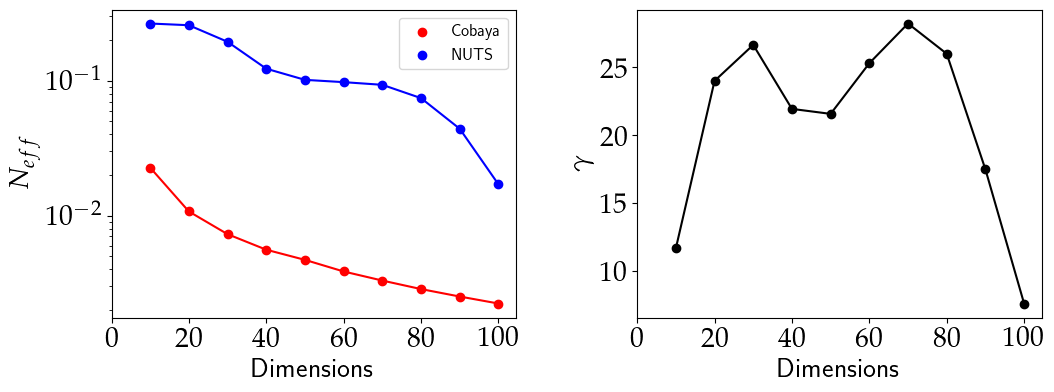

In [18]:
plt.figure(figsize = (12, 4))

plt.subplot(121)
plt.scatter(dimensions, df_neff['cb'], c = 'r', label = 'Cobaya')
plt.plot(dimensions, df_neff['cb'], c = 'r')
plt.scatter(dimensions, df_neff['nuts'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_neff['nuts'], c = 'b')
plt.xticks(np.arange(0, 120, step=20))
plt.ylabel(r'$N_{eff}$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})
plt.yscale('log')

plt.subplot(122)
plt.scatter(dimensions, df_neff['nuts'] / df_neff['cb'], c = 'k')
plt.plot(dimensions, df_neff['nuts'] / df_neff['cb'], c = 'k')
# plt.axhline(1.0, linestyle = '--', c = 'k')
# plt.ylim(0, 100)
plt.xticks(np.arange(0, 120, step=20))
plt.ylabel(r'$\gamma$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.yscale('log')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
# plt.savefig('/home/arrykrishna/Desktop/mvn_neff.pdf', bbox_inches = 'tight')
plt.show()

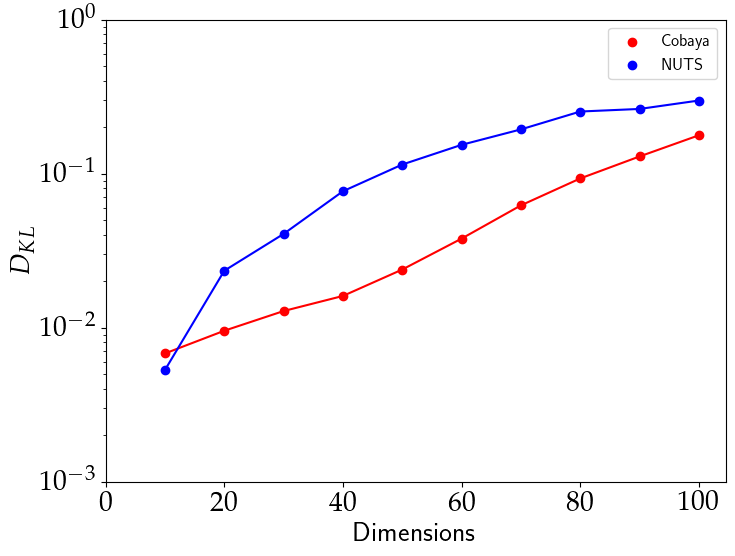

In [20]:
plt.figure(figsize = (8,6))
plt.scatter(dimensions, df_kl['cb'], c = 'r', label = 'Cobaya')
plt.plot(dimensions, df_kl['cb'], c = 'r')
plt.scatter(dimensions, df_kl['nuts'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_kl['nuts'], c = 'b')
plt.xticks(np.arange(0, 120, step=20))
plt.ylabel(r'$D_{KL}$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(1E-3, 1)
plt.yscale('log')
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})
# plt.savefig('plots/mvn_dist.pdf', bbox_inches = 'tight')
plt.show()

In [70]:
# for i in range(10):
#     print(nuts_record_stats[i].mean(0))
#     print(cb_record_stats[i].mean(0))
#     print('-'*50)

# Rosenbrock and Multivariate

In [166]:
nuts_rosen = pd.read_csv('rosenbrock/nuts_metrics_neff_nlike.csv', index_col=0)
cobaya_rosen = pd.read_csv('rosenbrock/cobaya_metrics_neff_nlike.csv', index_col=0)

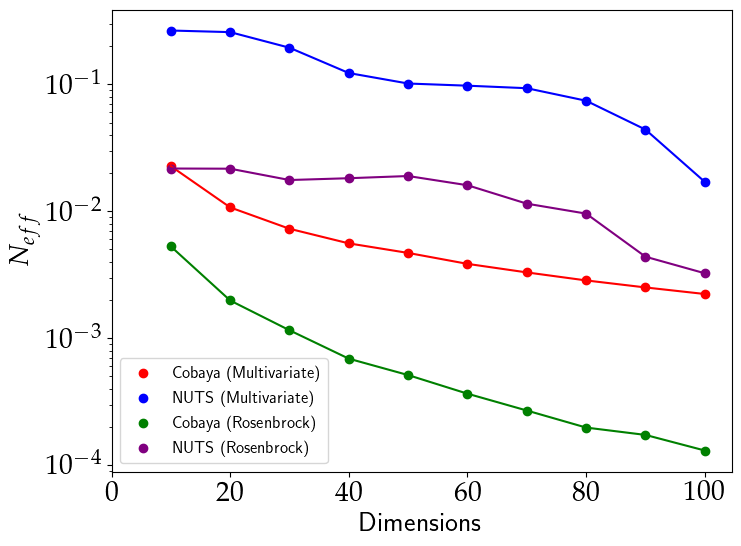

In [178]:
plt.figure(figsize = (8,6))
plt.scatter(dimensions, df_neff['cb'], c = 'r', label = 'Cobaya (Multivariate)')
plt.plot(dimensions, df_neff['cb'], c = 'r')
plt.scatter(dimensions, df_neff['nuts'], c = 'b', label = 'NUTS (Multivariate)')
plt.plot(dimensions, df_neff['nuts'], c = 'b')

plt.scatter(dimensions, cobaya_rosen['mean_neff'], c = 'g', label = 'Cobaya (Rosenbrock)')
plt.plot(dimensions, cobaya_rosen['mean_neff'], c = 'g')
plt.scatter(dimensions, nuts_rosen['mean_neff'], c = 'purple', label = 'NUTS (Rosenbrock)')
plt.plot(dimensions, nuts_rosen['mean_neff'], c = 'purple')

plt.xticks(np.arange(0, 120, step=20))
plt.ylabel(r'$N_{eff}$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})
plt.yscale('log')
# plt.savefig('plots/mvn_ros_neff.pdf', bbox_inches = 'tight')
plt.show()

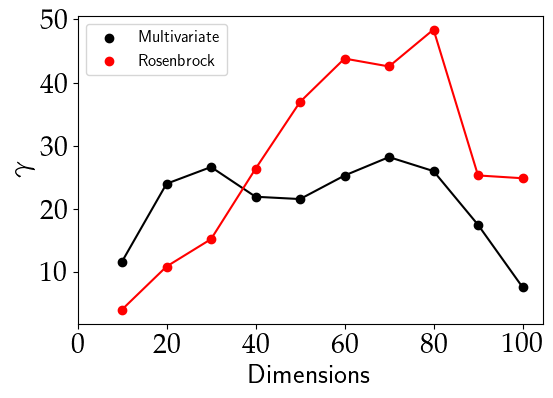

In [179]:
plt.figure(figsize=(6,4))
plt.scatter(dimensions, df_neff['nuts'] / df_neff['cb'], c = 'k', label = 'Multivariate')
plt.plot(dimensions, df_neff['nuts'] / df_neff['cb'], c = 'k')

ratio = nuts_rosen['mean_neff'] / cobaya_rosen['mean_neff']
plt.scatter(dimensions, ratio, c = 'r', label = 'Rosenbrock')
plt.plot(dimensions, ratio, c = 'r')
plt.xticks(np.arange(0, 120, step=20))
plt.ylabel(r'$\gamma$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})
# plt.savefig('plots/mvn_ros_gamma.pdf', bbox_inches = 'tight')
plt.show()